# Quantum Transformer


In [1]:
import os
import math
import random
from typing import Callable, Iterable
from copy import deepcopy
import numpy as np
from time import time

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch import Tensor, device
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

from torchtext.vocab import Vocab
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator

/group/pmc026/nchoong/quantum/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/group/pmc026/nchoong/quantum/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/group/pmc026/nchoong/quantum/lib/python3.11/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTAN

## Setting up environment


In [2]:
dev = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

print(dev)

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

1
0
Tesla V100-PCIE-32GB


## Helper functions


### Binary Accuracy


In [4]:
def binary_accuracy(preds: Tensor, y: Tensor):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # round predictions to the closest integer
    rounded_preds = preds.sigmoid().round()
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

### Clone Model


In [5]:
def get_clones(module: nn.Module, N: int):
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

### Data Loader


In [6]:
def yield_tokens(data: list[tuple[int, str]], tokenizer: Callable[[str], list[str]]):
    for label, text in data:
        yield tokenizer(text.lower())


def text_transform(text: str, vocab: Vocab, tokenizer: Callable[[str], list[str]]):
    return vocab([token for token in tokenizer(text.lower())])


def label_transform(label: int):
    return torch.tensor(1.0 if label == 2 else 0.0, dtype=torch.float)


def collate_batch(
    batch: Iterable[tuple[int, str]],
    vocab: Vocab,
    tokenizer: Callable[[str], list[str]],
):
    pad_idx = vocab["<pad>"]
    label_list, text_list = [], []

    for label, text in batch:
        label_list.append(label_transform(label))
        processed_text = torch.tensor(text_transform(text, vocab, tokenizer))
        text_list.append(processed_text)
    return torch.tensor(label_list), pad_sequence(text_list, padding_value=pad_idx)


def batch_sampler(data: list, batch_size: int, tokenizer: Callable[[str], list[str]]):
    indices = [(i, len(tokenizer(s[1]))) for i, s in enumerate(data)]
    random.shuffle(indices)
    pooled_indices = []
    # create pool of indices with similar lengths
    for i in range(0, len(indices), batch_size * 100):
        pooled_indices.extend(
            sorted(indices[i : i + batch_size * 100], key=lambda x: x[1])
        )

    pooled_indices = [x[0] for x in pooled_indices]

    # yield indices for current batch
    for i in range(0, len(pooled_indices), batch_size):
        yield pooled_indices[i : i + batch_size]

### Parameter Count


In [7]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Epoch Time


In [8]:
def epoch_time(start_time: float, end_time: float):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train


In [9]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: Optimizer,
    criterion: _Loss,
    max_seq_len: int,
    progress_bar,
):
    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.train()
    for i, (lab, text) in enumerate(dataloader):

        optimizer.zero_grad()
        inputs = torch.LongTensor(text.T).to(dev)
        if inputs.size(1) > max_seq_len:
            inputs = inputs[:, :max_seq_len]
        model.to(dev)
        predictions = model(inputs).squeeze(1)

        label = lab.to(dev)
        # label = label.unsqueeze(1)
        loss = criterion(predictions, label)
        # loss = F.nll_loss(predictions, label)
        acc = binary_accuracy(predictions, label)

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())
        epoch_true.extend(label.tolist())
        epoch_pred.extend(predictions.sigmoid().tolist())

        progress_bar.update(dataloader.batch_size)

    # print(epoch_loss, epoch_acc, len(dataloader.dataset))

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")
    # divide the total loss by the total number of batches per epoch
    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

### Evaluate


In [10]:
def evaluate(
    model: nn.Module, dataloader: DataLoader, criterion: _Loss, max_seq_len: int
):

    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.eval()

    with torch.no_grad():
        for i, (lab, text) in enumerate(dataloader):
            inputs = torch.LongTensor(text.T).to(dev)
            if inputs.size(1) > max_seq_len:
                inputs = inputs[:, :max_seq_len]

            predictions = model(inputs).squeeze(1)
            label = lab.to(dev)

            # label = label.unsqueeze(1)

            loss = criterion(predictions, label)
            # loss = F.nll_loss(predictions, label)

            acc = binary_accuracy(predictions, label)

            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())
            epoch_true.extend(label.tolist())
            epoch_pred.extend(predictions.sigmoid().tolist())

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")

    # divide the total loss by the total number of batches per epoch

    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

## Model


### Positional Encoding


In [11]:
class PositionalEncoder(nn.Module):

    def __init__(self, d_model: int, dropout=0.1, max_len=512, device=device("cpu")):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model, device=device)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        seq_len = x.size(1)
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

### Attention


In [12]:
def attention(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    mask: Tensor | None = None,
    dropout: nn.Dropout | None = None,
):
    """Scaled Dot Product Attention"""
    dim_k = query.size(-1)
    # scaled = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(dim_k)
    scaled = (query @ key.transpose(-2, -1)) / math.sqrt(dim_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scaled = scaled.masked_fill(mask == 0, -1e9)
    scores = scaled.softmax(-1)
    if dropout is not None:
        scores: Tensor = dropout(scores)
    # attn = torch.matmul(scores, value)
    attn = scores @ value
    return attn, scores

### Quantum Multi-Head Attention


In [13]:
import pennylane as qml
import pennylane.templates as qmlt
import pennylane.qnn.torch as qml_qnn_torch

In [14]:
class QuantumLayer(torch.nn.Module):
    def __init__(self, n_qubits, n_qlayers=1, q_device="default.qubit"):
        super().__init__()

        dev = qml.device(q_device, wires=n_qubits, torch_device="cuda")

        @qml.qnode(dev, interface="torch")
        def qlayer(inputs, weights):
            qmlt.AngleEmbedding(inputs, wires=range(n_qubits), rotation="X")
            qmlt.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Z")
            qmlt.BasicEntanglerLayers(weights, wires=range(n_qubits), rotation=qml.RZ)
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        self.linear = qml_qnn_torch.TorchLayer(qlayer, weight_shapes)

    def forward(self, inputs):
        return self.linear(inputs)

In [15]:
class MultiHeadedAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout=0.1,
        mask: Tensor | None = None,
        use_bias=False,
        n_qubits=4,
        n_qlayers=1,
        q_device="default.qubit",
    ):
        super(MultiHeadedAttention, self).__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mask = mask
        # We assume dim_v always equals dim_k
        self.dim_k = embed_dim // num_heads  # projection dimensions

        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        # The quantum layers for the query, key, and value projections
        self.k_linear = QuantumLayer(n_qubits, n_qlayers, q_device)
        self.q_linear = QuantumLayer(n_qubits, n_qlayers, q_device)
        self.v_linear = QuantumLayer(n_qubits, n_qlayers, q_device)
        # The quantum layer to combine the heads
        self.combine_heads = QuantumLayer(n_qubits, n_qlayers, q_device)

        self.attn_weights: Tensor | None = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor | None = None
    ):
        batch_size, seq_len, embed_dim = query.size()
        assert (
            embed_dim == self.embed_dim
        ), f"Input embedding ({embed_dim}) does not match layer embedding size ({self.embed_dim})"

        K = [self.k_linear(key[:, t, :]) for t in range(seq_len)]
        Q = [self.q_linear(query[:, t, :]) for t in range(seq_len)]
        V = [self.v_linear(value[:, t, :]) for t in range(seq_len)]

        K = torch.Tensor(pad_sequence(K))
        Q = torch.Tensor(pad_sequence(Q))
        V = torch.Tensor(pad_sequence(V))

        x: Tensor
        x, self.attn_weights = attention(Q, K, V, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, embed_dim)

        output = [self.combine_heads(x[:, t, :]) for t in range(seq_len)]
        output = torch.Tensor(pad_sequence(output))
        return output

### Quantum Feed-Forward Network


In [16]:
class FeedForward(nn.Module):
    """
    The x that is passed to the forward method is a tensor of shape (batch_size, sequence_length, embedding_dimension),
    rather than a flattened version of it (with shape (batch_size, sequence_length * embedding_dimension)).
    The (same) feed-forward layer applies to the last dimension only (the embedding dimension) for each batch and
    for each position in the sequence, hence position-wise.
    """

    def __init__(
        self,
        embed_dim: int,
        n_qubits: int,
        n_qlayers=1,
        dropout=0.1,
        q_device="default.qubit",
    ):
        super(FeedForward, self).__init__()
        self.ffn_dim = n_qubits

        self.linear_1 = nn.Linear(embed_dim, self.ffn_dim)
        self.linear_2 = nn.Linear(self.ffn_dim, embed_dim)
        self.vqc = QuantumLayer(n_qubits, n_qlayers, q_device)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        batch_size, seq_len, embed_dim = x.size()
        x = self.linear_1(x)
        X = [self.vqc(x[:, t, :]) for t in range(seq_len)]
        x = torch.Tensor(pad_sequence(X))
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

### Quantum Encoder


In [17]:
class Encoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        ffn_dim: int,
        dropout: float = 0.1,
        mask: Tensor | None = None,
        n_qubits_transformer=0,
        n_qubits_ffn=0,
        n_qlayers=1,
        q_device="default.qubit",
    ):
        super(Encoder, self).__init__()

        self.n_qubits_transformer = n_qubits_transformer
        self.n_qubits_ffn = n_qubits_ffn
        self.n_qlayers = n_qlayers

        self.attn = MultiHeadedAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            mask=mask,
            n_qubits=n_qubits_transformer,
            n_qlayers=n_qlayers,
            q_device=q_device,
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.ffn = FeedForward(
            embed_dim, n_qubits_ffn, n_qlayers, q_device=q_device, dropout=dropout
        )

        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        attn_output = self.attn(x, x, x)
        x = self.norm1(attn_output + x)
        x = self.dropout1(x)

        ff_output: Tensor = self.ffn(x)
        x = self.norm2(ff_output + x)
        x = self.dropout2(x)

        return x

### Text Classifier


In [18]:
class TextClassifier(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        num_blocks: int,
        num_classes: int,
        vocab_size: int,
        max_seq_len: int,
        ffn_dim=32,
        dropout=0.1,
        n_qubits_transformer=0,
        n_qubits_ffn=0,
        n_qlayers=1,
        q_device="default.qubit",
    ):
        super(TextClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.vocab_size = vocab_size

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = PositionalEncoder(embed_dim, max_len=max_seq_len)

        print(f"++ There will be {num_blocks} transformer blocks")

        print(
            f"++ Transformer will use {n_qubits_transformer} qubits and {n_qlayers} q layers"
        )

        print(f"The feed-forward head will use {n_qubits_ffn} qubits")

        print(f"Using quantum device {q_device}")

        self.transformers = get_clones(
            Encoder(
                embed_dim,
                num_heads,
                ffn_dim,
                n_qubits_transformer=n_qubits_transformer,
                n_qubits_ffn=n_qubits_ffn,
                n_qlayers=n_qlayers,
                q_device=q_device,
            ),
            num_blocks,
        )

        self.class_logits = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        tokens = self.token_embedding(x)
        x = self.pos_embedding(tokens)

        # # Normalise the data to range [0, 2*pi]
        # min_val = x.min()
        # max_val = x.max()

        # x = (x - min_val) / (max_val - min_val) * (2 * torch.pi)

        # print(f"Minimum value: {x.min()}, Maximum value: {x.max()}")

        for transformer in self.transformers:
            x = transformer(x)

        x = x.mean(dim=1)  # global average pooling, works in 1D
        x = self.dropout(x)
        x = self.class_logits(x)
        return x

### Main Function


In [19]:
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split


def main(
    max_seq_len=128,
    batch_size=32,
    total_size=3200,
    n_epochs=30,
    lr=0.001,
    embed_dim=8,
    num_heads=2,
    num_blocks=2,
    num_classes=2,
    vocab_size=50000,
    ffn_dim=16,
    n_qubits_transformer=0,
    n_qubits_ffn=0,
    n_qlayers=0,
    q_device="default.qubit",
    dropout_rate=0.1,
):

    save_dir = f".models_{n_epochs}_{n_qubits_transformer}_{n_qubits_ffn}_{n_qlayers}"
    save_path = os.path.join(save_dir, "model_and_metrics_epoch_{}.pt")
    os.makedirs(save_dir, exist_ok=True)

    # train_iter = IMDB(root="./.datatext", split="train")
    # test_iter = IMDB(root="./.datatext", split="test")

    # train_data = to_map_style_dataset(train_iter)
    # test_data = to_map_style_dataset(test_iter)

    size = total_size

    # test_data = np.array(test_data)[
    #     np.random.choice(len(test_data), size=size, replace=False)
    # ].tolist()

    train_iter = IMDB(root="./.datatext", split="train")

    train_data = to_map_style_dataset(train_iter)
    train_data = np.array(train_data)[
        np.random.choice(len(train_data), size=size, replace=False)
    ].tolist()

    train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

    train_data = [(int(label), text) for label, text in train_data]
    test_data = [(int(label), text) for label, text in test_data]

    print("pos: ", len([label for label, text in train_data if label == 1]))
    print("neg: ", len([label for label, text in train_data if label == 2]))

    tokenizer = get_tokenizer("basic_english")
    vocab = build_vocab_from_iterator(
        yield_tokens(train_data, tokenizer),
        specials=["<unk>", "<pad>"],
        max_tokens=vocab_size,
    )
    vocab.set_default_index(vocab["<unk>"])

    train_loader = DataLoader(
        train_data,  # type: ignore
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )
    test_loader = DataLoader(
        test_data,  # type: ignore
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )

    model = TextClassifier(
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_blocks=num_blocks,
        num_classes=num_classes,
        vocab_size=vocab_size,
        ffn_dim=ffn_dim,
        n_qubits_transformer=n_qubits_transformer,
        n_qubits_ffn=n_qubits_ffn,
        n_qlayers=n_qlayers,
        dropout=dropout_rate,
        q_device=q_device,
        max_seq_len=max_seq_len,
    )

    print(f"The model has {count_parameters(model):,} trainable parameters")
    start_time = time()

    model.to(dev)

    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    criterion = torch.nn.BCEWithLogitsLoss()  # logits -> sigmoid -> loss
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # training loop
    best_test_loss = float("inf")
    best_test_acc, best_epoch_acc = 0.0, 0
    best_test_auc, best_epoch_auc = 0.0, 0
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = [], [], [], []
    train_auc_list, test_auc_list = [], []
    for iepoch in range(n_epochs):
        with tqdm(
            total=len(train_loader.dataset),
            desc=f"Epoch {iepoch+1:3}/{n_epochs}",
            unit="batch",
            bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}",
            position=0,
            leave=True,
        ) as progress_bar:
            operation_start_time = time()

            train_loss, train_acc, train_auc = train(
                model, train_loader, optimizer, criterion, max_seq_len, progress_bar
            )

            # scheduler.step()

            test_loss, test_acc, test_auc = evaluate(
                model, test_loader, criterion, max_seq_len
            )

            end_time = time()

            epoch_mins, epoch_secs = epoch_time(operation_start_time, end_time)

            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            train_auc_list.append(train_auc)
            test_auc_list.append(test_auc)

            progress_bar.set_postfix_str(
                f"Epoch = {epoch_mins}m {epoch_secs}s, Loss = {train_loss:.4f}|{test_loss:.4f}, Acc = {train_acc:.3f}|{test_acc:.3f}, AUC = {train_auc:.3f}|{test_auc:.3f}"
            )
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_epoch_acc = iepoch + 1
            if test_auc > best_test_auc:
                best_test_auc = test_auc
                best_epoch_auc = iepoch + 1

            torch.save(
                {
                    "epoch": iepoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                    "train_loss": train_loss_list,
                    "train_acc": train_acc_list,
                    "train_auc": train_auc_list,
                    "test_loss": test_loss_list,
                    "test_acc": test_acc_list,
                    "test_auc": test_auc_list,
                },
                save_path.format(iepoch + 1),
            )

            # if test_loss < best_test_loss:
            #     best_test_loss = test_loss
            #     torch.save(model.state_dict(), "model.pt")

    print(f"TOTAL TIME = {time()-start_time:.2f}s")
    print(f"BEST ACC = {best_test_acc:.2f}% AT EPOCH {best_epoch_acc}")
    print(f"BEST AUC = {best_test_auc:.2f} AT EPOCH {best_epoch_auc}")

    return (
        train_loss_list,
        train_acc_list,
        test_loss_list,
        test_acc_list,
        train_auc_list,
        test_auc_list,
    )

## Training


In [20]:
qml.about()

Name: PennyLane
Version: 0.37.0
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /group/pmc026/nchoong/quantum/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, packaging, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane_Lightning

Platform info:           Linux-4.18.0-348.12.2.el8_5.x86_64-x86_64-with-glibc2.28
Python version:          3.11.8
Numpy version:           1.26.3
Scipy version:           1.14.0
Installed devices:
- lightning.qubit (PennyLane_Lightning-0.37.0)
- default.clifford (PennyLane-0.37.0)
- default.gaussian (PennyLane-0.37.0)
- default.mixed (PennyLane-0.37.0)
- default.qubit (PennyLane-0.37.0)
- default.qubit.a

In [21]:
# import gc

# gc.collect()

# torch.cuda.empty_cache()

In [22]:
train_loss, train_acc, test_loss, test_acc, train_auc, test_auc = main(
    n_epochs=20,
    embed_dim=8,
    n_qubits_transformer=8,
    n_qubits_ffn=8,
    n_qlayers=3,
    num_blocks=2,
    num_heads=2,
    q_device="default.qubit.torch",
    total_size=5000,
)

/group/pmc026/nchoong/quantum/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


pos:  1999
neg:  2001


++ There will be 2 transformer blocks
++ Transformer will use 8 qubits and 3 q layers
The feed-forward head will use 8 qubits
Using quantum device default.qubit.torch
weight_shapes = (n_qlayers, n_qubits) = (3, 8)
The model has 400,601 trainable parameters


Epoch   1/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   1/20:   1%|          | 32/4000 [00:50<1:44:28,  1.58s/batch]

Epoch   1/20:   2%|▏         | 64/4000 [01:43<1:46:26,  1.62s/batch]

Epoch   1/20:   2%|▏         | 96/4000 [02:35<1:45:34,  1.62s/batch]

Epoch   1/20:   3%|▎         | 128/4000 [03:27<1:44:34,  1.62s/batch]

Epoch   1/20:   4%|▍         | 160/4000 [04:22<1:46:27,  1.66s/batch]

Epoch   1/20:   5%|▍         | 192/4000 [05:17<1:46:45,  1.68s/batch]

Epoch   1/20:   6%|▌         | 224/4000 [06:13<1:47:06,  1.70s/batch]

Epoch   1/20:   6%|▋         | 256/4000 [07:09<1:47:13,  1.72s/batch]

Epoch   1/20:   7%|▋         | 288/4000 [08:04<1:46:04,  1.71s/batch]

Epoch   1/20:   8%|▊         | 320/4000 [08:57<1:44:18,  1.70s/batch]

Epoch   1/20:   9%|▉         | 352/4000 [09:50<1:42:22,  1.68s/batch]

Epoch   1/20:  10%|▉         | 384/4000 [10:42<1:40:38,  1.67s/batch]

Epoch   1/20:  10%|█         | 416/4000 [11:35<1:39:11,  1.66s/batch]

Epoch   1/20:  11%|█         | 448/4000 [12:27<1:37:51,  1.65s/batch]

Epoch   1/20:  12%|█▏        | 480/4000 [13:19<1:36:37,  1.65s/batch]

Epoch   1/20:  13%|█▎        | 512/4000 [14:12<1:35:28,  1.64s/batch]

Epoch   1/20:  14%|█▎        | 544/4000 [15:03<1:34:06,  1.63s/batch]

Epoch   1/20:  14%|█▍        | 576/4000 [15:55<1:33:11,  1.63s/batch]

Epoch   1/20:  15%|█▌        | 608/4000 [16:47<1:32:11,  1.63s/batch]

Epoch   1/20:  16%|█▌        | 640/4000 [17:39<1:30:58,  1.62s/batch]

Epoch   1/20:  17%|█▋        | 672/4000 [18:30<1:29:52,  1.62s/batch]

Epoch   1/20:  18%|█▊        | 704/4000 [19:22<1:29:05,  1.62s/batch]

Epoch   1/20:  18%|█▊        | 736/4000 [20:14<1:28:06,  1.62s/batch]

Epoch   1/20:  19%|█▉        | 768/4000 [21:05<1:26:59,  1.61s/batch]

Epoch   1/20:  20%|██        | 800/4000 [21:57<1:26:03,  1.61s/batch]

Epoch   1/20:  21%|██        | 832/4000 [22:49<1:25:09,  1.61s/batch]

Epoch   1/20:  22%|██▏       | 864/4000 [23:40<1:24:05,  1.61s/batch]

Epoch   1/20:  22%|██▏       | 896/4000 [24:31<1:23:02,  1.61s/batch]

Epoch   1/20:  23%|██▎       | 928/4000 [25:22<1:21:57,  1.60s/batch]

Epoch   1/20:  24%|██▍       | 960/4000 [26:13<1:20:57,  1.60s/batch]

Epoch   1/20:  25%|██▍       | 992/4000 [27:04<1:20:11,  1.60s/batch]

Epoch   1/20:  26%|██▌       | 1024/4000 [27:55<1:19:10,  1.60s/batch]

Epoch   1/20:  26%|██▋       | 1056/4000 [28:45<1:18:10,  1.59s/batch]

Epoch   1/20:  27%|██▋       | 1088/4000 [29:36<1:17:12,  1.59s/batch]

Epoch   1/20:  28%|██▊       | 1120/4000 [30:27<1:16:15,  1.59s/batch]

Epoch   1/20:  29%|██▉       | 1152/4000 [31:18<1:15:23,  1.59s/batch]

Epoch   1/20:  30%|██▉       | 1184/4000 [32:09<1:14:35,  1.59s/batch]

Epoch   1/20:  30%|███       | 1216/4000 [32:59<1:13:34,  1.59s/batch]

Epoch   1/20:  31%|███       | 1248/4000 [33:50<1:12:40,  1.58s/batch]

Epoch   1/20:  32%|███▏      | 1280/4000 [34:40<1:11:44,  1.58s/batch]

Epoch   1/20:  33%|███▎      | 1312/4000 [35:31<1:10:53,  1.58s/batch]

Epoch   1/20:  34%|███▎      | 1344/4000 [36:21<1:09:59,  1.58s/batch]

Epoch   1/20:  34%|███▍      | 1376/4000 [37:12<1:09:01,  1.58s/batch]

Epoch   1/20:  35%|███▌      | 1408/4000 [38:02<1:08:05,  1.58s/batch]

Epoch   1/20:  36%|███▌      | 1440/4000 [38:52<1:07:09,  1.57s/batch]

Epoch   1/20:  37%|███▋      | 1472/4000 [39:42<1:06:14,  1.57s/batch]

Epoch   1/20:  38%|███▊      | 1504/4000 [40:32<1:05:20,  1.57s/batch]

Epoch   1/20:  38%|███▊      | 1536/4000 [41:23<1:04:25,  1.57s/batch]

Epoch   1/20:  39%|███▉      | 1568/4000 [42:12<1:03:29,  1.57s/batch]

Epoch   1/20:  40%|████      | 1600/4000 [43:02<1:02:35,  1.56s/batch]

Epoch   1/20:  41%|████      | 1632/4000 [43:52<1:01:40,  1.56s/batch]

Epoch   1/20:  42%|████▏     | 1664/4000 [44:42<1:00:49,  1.56s/batch]

Epoch   1/20:  42%|████▏     | 1696/4000 [45:32<59:54,  1.56s/batch]  

Epoch   1/20:  43%|████▎     | 1728/4000 [46:22<59:01,  1.56s/batch]

Epoch   1/20:  44%|████▍     | 1760/4000 [47:12<58:09,  1.56s/batch]

Epoch   1/20:  45%|████▍     | 1792/4000 [48:01<57:17,  1.56s/batch]

Epoch   1/20:  46%|████▌     | 1824/4000 [48:51<56:23,  1.55s/batch]

Epoch   1/20:  46%|████▋     | 1856/4000 [49:40<55:28,  1.55s/batch]

Epoch   1/20:  47%|████▋     | 1888/4000 [50:30<54:34,  1.55s/batch]

Epoch   1/20:  48%|████▊     | 1920/4000 [51:19<53:44,  1.55s/batch]

Epoch   1/20:  49%|████▉     | 1952/4000 [52:09<52:52,  1.55s/batch]

Epoch   1/20:  50%|████▉     | 1984/4000 [52:58<52:01,  1.55s/batch]

Epoch   1/20:  50%|█████     | 2016/4000 [53:48<51:09,  1.55s/batch]

Epoch   1/20:  51%|█████     | 2048/4000 [54:37<50:19,  1.55s/batch]

Epoch   1/20:  52%|█████▏    | 2080/4000 [55:27<49:30,  1.55s/batch]

Epoch   1/20:  53%|█████▎    | 2112/4000 [56:16<48:40,  1.55s/batch]

Epoch   1/20:  54%|█████▎    | 2144/4000 [57:06<47:50,  1.55s/batch]

Epoch   1/20:  54%|█████▍    | 2176/4000 [57:55<47:01,  1.55s/batch]

Epoch   1/20:  55%|█████▌    | 2208/4000 [58:45<46:14,  1.55s/batch]

Epoch   1/20:  56%|█████▌    | 2240/4000 [59:34<45:24,  1.55s/batch]

Epoch   1/20:  57%|█████▋    | 2272/4000 [1:00:24<44:34,  1.55s/batch]

Epoch   1/20:  58%|█████▊    | 2304/4000 [1:01:14<43:45,  1.55s/batch]

Epoch   1/20:  58%|█████▊    | 2336/4000 [1:02:03<42:55,  1.55s/batch]

Epoch   1/20:  59%|█████▉    | 2368/4000 [1:02:53<42:06,  1.55s/batch]

Epoch   1/20:  60%|██████    | 2400/4000 [1:03:42<41:16,  1.55s/batch]

Epoch   1/20:  61%|██████    | 2432/4000 [1:04:32<40:26,  1.55s/batch]

Epoch   1/20:  62%|██████▏   | 2464/4000 [1:05:21<39:36,  1.55s/batch]

Epoch   1/20:  62%|██████▏   | 2496/4000 [1:06:11<38:46,  1.55s/batch]

Epoch   1/20:  63%|██████▎   | 2528/4000 [1:07:00<37:58,  1.55s/batch]

Epoch   1/20:  64%|██████▍   | 2560/4000 [1:07:50<37:08,  1.55s/batch]

Epoch   1/20:  65%|██████▍   | 2592/4000 [1:08:39<36:18,  1.55s/batch]

Epoch   1/20:  66%|██████▌   | 2624/4000 [1:09:29<35:28,  1.55s/batch]

Epoch   1/20:  66%|██████▋   | 2656/4000 [1:10:18<34:40,  1.55s/batch]

Epoch   1/20:  67%|██████▋   | 2688/4000 [1:11:08<33:50,  1.55s/batch]

Epoch   1/20:  68%|██████▊   | 2720/4000 [1:11:57<33:00,  1.55s/batch]

Epoch   1/20:  69%|██████▉   | 2752/4000 [1:12:47<32:10,  1.55s/batch]

Epoch   1/20:  70%|██████▉   | 2784/4000 [1:13:36<31:20,  1.55s/batch]

Epoch   1/20:  70%|███████   | 2816/4000 [1:14:26<30:32,  1.55s/batch]

Epoch   1/20:  71%|███████   | 2848/4000 [1:15:15<29:42,  1.55s/batch]

Epoch   1/20:  72%|███████▏  | 2880/4000 [1:16:05<28:52,  1.55s/batch]

Epoch   1/20:  73%|███████▎  | 2912/4000 [1:16:54<28:01,  1.55s/batch]

Epoch   1/20:  74%|███████▎  | 2944/4000 [1:17:44<27:13,  1.55s/batch]

Epoch   1/20:  74%|███████▍  | 2976/4000 [1:18:33<26:23,  1.55s/batch]

Epoch   1/20:  75%|███████▌  | 3008/4000 [1:19:23<25:33,  1.55s/batch]

Epoch   1/20:  76%|███████▌  | 3040/4000 [1:20:12<24:44,  1.55s/batch]

Epoch   1/20:  77%|███████▋  | 3072/4000 [1:21:02<23:55,  1.55s/batch]

Epoch   1/20:  78%|███████▊  | 3104/4000 [1:21:51<23:05,  1.55s/batch]

Epoch   1/20:  78%|███████▊  | 3136/4000 [1:22:41<22:16,  1.55s/batch]

Epoch   1/20:  79%|███████▉  | 3168/4000 [1:23:30<21:26,  1.55s/batch]

Epoch   1/20:  80%|████████  | 3200/4000 [1:24:20<20:37,  1.55s/batch]

Epoch   1/20:  81%|████████  | 3232/4000 [1:25:09<19:47,  1.55s/batch]

Epoch   1/20:  82%|████████▏ | 3264/4000 [1:25:58<18:57,  1.55s/batch]

Epoch   1/20:  82%|████████▏ | 3296/4000 [1:26:48<18:08,  1.55s/batch]

Epoch   1/20:  83%|████████▎ | 3328/4000 [1:27:37<17:18,  1.55s/batch]

Epoch   1/20:  84%|████████▍ | 3360/4000 [1:28:27<16:30,  1.55s/batch]

Epoch   1/20:  85%|████████▍ | 3392/4000 [1:29:17<15:40,  1.55s/batch]

Epoch   1/20:  86%|████████▌ | 3424/4000 [1:30:06<14:51,  1.55s/batch]

Epoch   1/20:  86%|████████▋ | 3456/4000 [1:30:56<14:02,  1.55s/batch]

Epoch   1/20:  87%|████████▋ | 3488/4000 [1:31:45<13:12,  1.55s/batch]

Epoch   1/20:  88%|████████▊ | 3520/4000 [1:32:35<12:22,  1.55s/batch]

Epoch   1/20:  89%|████████▉ | 3552/4000 [1:33:24<11:33,  1.55s/batch]

Epoch   1/20:  90%|████████▉ | 3584/4000 [1:34:14<10:43,  1.55s/batch]

Epoch   1/20:  90%|█████████ | 3616/4000 [1:35:03<09:54,  1.55s/batch]

Epoch   1/20:  91%|█████████ | 3648/4000 [1:35:53<09:04,  1.55s/batch]

Epoch   1/20:  92%|█████████▏| 3680/4000 [1:36:42<08:14,  1.55s/batch]

Epoch   1/20:  93%|█████████▎| 3712/4000 [1:37:32<07:25,  1.55s/batch]

Epoch   1/20:  94%|█████████▎| 3744/4000 [1:38:21<06:36,  1.55s/batch]

Epoch   1/20:  94%|█████████▍| 3776/4000 [1:39:11<05:46,  1.55s/batch]

Epoch   1/20:  95%|█████████▌| 3808/4000 [1:40:00<04:57,  1.55s/batch]

Epoch   1/20:  96%|█████████▌| 3840/4000 [1:40:50<04:07,  1.55s/batch]

Epoch   1/20:  97%|█████████▋| 3872/4000 [1:41:39<03:18,  1.55s/batch]

Epoch   1/20:  98%|█████████▊| 3904/4000 [1:42:29<02:28,  1.55s/batch]

Epoch   1/20:  98%|█████████▊| 3936/4000 [1:43:18<01:39,  1.55s/batch]

Epoch   1/20:  99%|█████████▉| 3968/4000 [1:44:08<00:49,  1.55s/batch]

Epoch   1/20: 100%|██████████| 4000/4000 [1:44:58<00:00,  1.55s/batch]

Epoch   1/20: 100%|██████████| 4000/4000 [1:53:29<00:00,  1.55s/batch, Epoch = 113m 29s, Loss = 0.7057|0.6971, Acc = 0.495|0.504, AUC = 48.889|50.082]

Epoch   1/20: 100%|██████████| 4000/4000 [1:53:29<00:00,  1.70s/batch, Epoch = 113m 29s, Loss = 0.7057|0.6971, Acc = 0.495|0.504, AUC = 48.889|50.082]

Epoch   2/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   2/20:   1%|          | 32/4000 [00:45<1:34:28,  1.43s/batch]

Epoch   2/20:   2%|▏         | 64/4000 [01:32<1:35:35,  1.46s/batch]

Epoch   2/20:   2%|▏         | 96/4000 [02:20<1:35:44,  1.47s/batch]

Epoch   2/20:   3%|▎         | 128/4000 [03:08<1:35:46,  1.48s/batch]

Epoch   2/20:   4%|▍         | 160/4000 [03:57<1:35:39,  1.49s/batch]

Epoch   2/20:   5%|▍         | 192/4000 [04:45<1:35:27,  1.50s/batch]

Epoch   2/20:   6%|▌         | 224/4000 [05:34<1:35:07,  1.51s/batch]

Epoch   2/20:   6%|▋         | 256/4000 [06:23<1:34:46,  1.52s/batch]

Epoch   2/20:   7%|▋         | 288/4000 [07:12<1:34:14,  1.52s/batch]

Epoch   2/20:   8%|▊         | 320/4000 [08:02<1:33:42,  1.53s/batch]

Epoch   2/20:   9%|▉         | 352/4000 [08:51<1:33:08,  1.53s/batch]

Epoch   2/20:  10%|▉         | 384/4000 [09:40<1:32:34,  1.54s/batch]

Epoch   2/20:  10%|█         | 416/4000 [10:30<1:31:54,  1.54s/batch]

Epoch   2/20:  11%|█         | 448/4000 [11:19<1:31:12,  1.54s/batch]

Epoch   2/20:  12%|█▏        | 480/4000 [12:09<1:30:30,  1.54s/batch]

Epoch   2/20:  13%|█▎        | 512/4000 [12:58<1:29:45,  1.54s/batch]

Epoch   2/20:  14%|█▎        | 544/4000 [13:48<1:29:00,  1.55s/batch]

Epoch   2/20:  14%|█▍        | 576/4000 [14:37<1:28:13,  1.55s/batch]

Epoch   2/20:  15%|█▌        | 608/4000 [15:27<1:27:37,  1.55s/batch]

Epoch   2/20:  16%|█▌        | 640/4000 [16:17<1:26:59,  1.55s/batch]

Epoch   2/20:  17%|█▋        | 672/4000 [17:07<1:26:08,  1.55s/batch]

Epoch   2/20:  18%|█▊        | 704/4000 [17:57<1:25:41,  1.56s/batch]

Epoch   2/20:  18%|█▊        | 736/4000 [18:49<1:25:42,  1.58s/batch]

Epoch   2/20:  19%|█▉        | 768/4000 [19:39<1:24:49,  1.57s/batch]

Epoch   2/20:  20%|██        | 800/4000 [20:29<1:23:34,  1.57s/batch]

Epoch   2/20:  21%|██        | 832/4000 [21:19<1:22:38,  1.57s/batch]

Epoch   2/20:  22%|██▏       | 864/4000 [22:09<1:21:58,  1.57s/batch]

Epoch   2/20:  22%|██▏       | 896/4000 [22:59<1:20:57,  1.56s/batch]

Epoch   2/20:  23%|██▎       | 928/4000 [23:49<1:20:01,  1.56s/batch]

Epoch   2/20:  24%|██▍       | 960/4000 [24:38<1:18:45,  1.55s/batch]

Epoch   2/20:  25%|██▍       | 992/4000 [25:27<1:17:37,  1.55s/batch]

Epoch   2/20:  26%|██▌       | 1024/4000 [26:16<1:16:39,  1.55s/batch]

Epoch   2/20:  26%|██▋       | 1056/4000 [27:05<1:15:39,  1.54s/batch]

Epoch   2/20:  27%|██▋       | 1088/4000 [27:54<1:14:43,  1.54s/batch]

Epoch   2/20:  28%|██▊       | 1120/4000 [28:45<1:14:18,  1.55s/batch]

Epoch   2/20:  29%|██▉       | 1152/4000 [29:34<1:13:32,  1.55s/batch]

Epoch   2/20:  30%|██▉       | 1184/4000 [30:24<1:12:44,  1.55s/batch]

Epoch   2/20:  30%|███       | 1216/4000 [31:14<1:11:55,  1.55s/batch]

Epoch   2/20:  31%|███       | 1248/4000 [32:03<1:11:04,  1.55s/batch]

Epoch   2/20:  32%|███▏      | 1280/4000 [32:53<1:10:14,  1.55s/batch]

Epoch   2/20:  33%|███▎      | 1312/4000 [33:42<1:09:29,  1.55s/batch]

Epoch   2/20:  34%|███▎      | 1344/4000 [34:32<1:08:39,  1.55s/batch]

Epoch   2/20:  34%|███▍      | 1376/4000 [35:22<1:07:51,  1.55s/batch]

Epoch   2/20:  35%|███▌      | 1408/4000 [36:11<1:06:59,  1.55s/batch]

Epoch   2/20:  36%|███▌      | 1440/4000 [37:01<1:06:11,  1.55s/batch]

Epoch   2/20:  37%|███▋      | 1472/4000 [37:51<1:05:18,  1.55s/batch]

Epoch   2/20:  38%|███▊      | 1504/4000 [38:40<1:04:26,  1.55s/batch]

Epoch   2/20:  38%|███▊      | 1536/4000 [39:30<1:03:36,  1.55s/batch]

Epoch   2/20:  39%|███▉      | 1568/4000 [40:19<1:02:50,  1.55s/batch]

Epoch   2/20:  40%|████      | 1600/4000 [41:09<1:02:00,  1.55s/batch]

Epoch   2/20:  41%|████      | 1632/4000 [41:58<1:01:08,  1.55s/batch]

Epoch   2/20:  42%|████▏     | 1664/4000 [42:48<1:00:18,  1.55s/batch]

Epoch   2/20:  42%|████▏     | 1696/4000 [43:38<59:29,  1.55s/batch]  

Epoch   2/20:  43%|████▎     | 1728/4000 [44:27<58:39,  1.55s/batch]

Epoch   2/20:  44%|████▍     | 1760/4000 [45:17<57:49,  1.55s/batch]

Epoch   2/20:  45%|████▍     | 1792/4000 [46:06<57:01,  1.55s/batch]

Epoch   2/20:  46%|████▌     | 1824/4000 [46:56<56:11,  1.55s/batch]

Epoch   2/20:  46%|████▋     | 1856/4000 [47:46<55:27,  1.55s/batch]

Epoch   2/20:  47%|████▋     | 1888/4000 [48:35<54:37,  1.55s/batch]

Epoch   2/20:  48%|████▊     | 1920/4000 [49:25<53:47,  1.55s/batch]

Epoch   2/20:  49%|████▉     | 1952/4000 [50:15<52:56,  1.55s/batch]

Epoch   2/20:  50%|████▉     | 1984/4000 [51:04<52:06,  1.55s/batch]

Epoch   2/20:  50%|█████     | 2016/4000 [51:54<51:15,  1.55s/batch]

Epoch   2/20:  51%|█████     | 2048/4000 [52:43<50:22,  1.55s/batch]

Epoch   2/20:  52%|█████▏    | 2080/4000 [53:33<49:36,  1.55s/batch]

Epoch   2/20:  53%|█████▎    | 2112/4000 [54:22<48:46,  1.55s/batch]

Epoch   2/20:  54%|█████▎    | 2144/4000 [55:12<47:56,  1.55s/batch]

Epoch   2/20:  54%|█████▍    | 2176/4000 [56:02<47:07,  1.55s/batch]

Epoch   2/20:  55%|█████▌    | 2208/4000 [56:51<46:19,  1.55s/batch]

Epoch   2/20:  56%|█████▌    | 2240/4000 [57:41<45:28,  1.55s/batch]

Epoch   2/20:  57%|█████▋    | 2272/4000 [58:31<44:38,  1.55s/batch]

Epoch   2/20:  58%|█████▊    | 2304/4000 [59:20<43:48,  1.55s/batch]

Epoch   2/20:  58%|█████▊    | 2336/4000 [1:00:10<43:00,  1.55s/batch]

Epoch   2/20:  59%|█████▉    | 2368/4000 [1:01:00<42:18,  1.56s/batch]

Epoch   2/20:  60%|██████    | 2400/4000 [1:01:50<41:33,  1.56s/batch]

Epoch   2/20:  61%|██████    | 2432/4000 [1:02:41<40:55,  1.57s/batch]

Epoch   2/20:  62%|██████▏   | 2464/4000 [1:03:31<40:06,  1.57s/batch]

Epoch   2/20:  62%|██████▏   | 2496/4000 [1:04:21<39:11,  1.56s/batch]

Epoch   2/20:  63%|██████▎   | 2528/4000 [1:05:10<38:14,  1.56s/batch]

Epoch   2/20:  64%|██████▍   | 2560/4000 [1:06:00<37:21,  1.56s/batch]

Epoch   2/20:  65%|██████▍   | 2592/4000 [1:06:50<36:34,  1.56s/batch]

Epoch   2/20:  66%|██████▌   | 2624/4000 [1:07:40<35:41,  1.56s/batch]

Epoch   2/20:  66%|██████▋   | 2656/4000 [1:08:29<34:48,  1.55s/batch]

Epoch   2/20:  67%|██████▋   | 2688/4000 [1:09:19<33:56,  1.55s/batch]

Epoch   2/20:  68%|██████▊   | 2720/4000 [1:10:08<33:05,  1.55s/batch]

Epoch   2/20:  69%|██████▉   | 2752/4000 [1:10:58<32:16,  1.55s/batch]

Epoch   2/20:  70%|██████▉   | 2784/4000 [1:11:47<31:25,  1.55s/batch]

Epoch   2/20:  70%|███████   | 2816/4000 [1:12:37<30:35,  1.55s/batch]

Epoch   2/20:  71%|███████   | 2848/4000 [1:13:27<29:45,  1.55s/batch]

Epoch   2/20:  72%|███████▏  | 2880/4000 [1:14:16<28:55,  1.55s/batch]

Epoch   2/20:  73%|███████▎  | 2912/4000 [1:15:06<28:09,  1.55s/batch]

Epoch   2/20:  74%|███████▎  | 2944/4000 [1:15:56<27:18,  1.55s/batch]

Epoch   2/20:  74%|███████▍  | 2976/4000 [1:16:45<26:28,  1.55s/batch]

Epoch   2/20:  75%|███████▌  | 3008/4000 [1:17:35<25:37,  1.55s/batch]

Epoch   2/20:  76%|███████▌  | 3040/4000 [1:18:24<24:48,  1.55s/batch]

Epoch   2/20:  77%|███████▋  | 3072/4000 [1:19:14<23:58,  1.55s/batch]

Epoch   2/20:  78%|███████▊  | 3104/4000 [1:20:04<23:10,  1.55s/batch]

Epoch   2/20:  78%|███████▊  | 3136/4000 [1:20:54<22:24,  1.56s/batch]

Epoch   2/20:  79%|███████▉  | 3168/4000 [1:21:44<21:35,  1.56s/batch]

Epoch   2/20:  80%|████████  | 3200/4000 [1:22:33<20:44,  1.56s/batch]

Epoch   2/20:  81%|████████  | 3232/4000 [1:23:23<19:52,  1.55s/batch]

Epoch   2/20:  82%|████████▏ | 3264/4000 [1:24:13<19:03,  1.55s/batch]

Epoch   2/20:  82%|████████▏ | 3296/4000 [1:25:03<18:14,  1.55s/batch]

Epoch   2/20:  83%|████████▎ | 3328/4000 [1:25:52<17:24,  1.55s/batch]

Epoch   2/20:  84%|████████▍ | 3360/4000 [1:26:42<16:35,  1.55s/batch]

Epoch   2/20:  85%|████████▍ | 3392/4000 [1:27:32<15:45,  1.56s/batch]

Epoch   2/20:  86%|████████▌ | 3424/4000 [1:28:22<14:59,  1.56s/batch]

Epoch   2/20:  86%|████████▋ | 3456/4000 [1:29:13<14:13,  1.57s/batch]

Epoch   2/20:  87%|████████▋ | 3488/4000 [1:30:04<13:24,  1.57s/batch]

Epoch   2/20:  88%|████████▊ | 3520/4000 [1:30:54<12:34,  1.57s/batch]

Epoch   2/20:  89%|████████▉ | 3552/4000 [1:31:44<11:42,  1.57s/batch]

Epoch   2/20:  90%|████████▉ | 3584/4000 [1:32:34<10:52,  1.57s/batch]

Epoch   2/20:  90%|█████████ | 3616/4000 [1:33:24<10:01,  1.57s/batch]

Epoch   2/20:  91%|█████████ | 3648/4000 [1:34:14<09:11,  1.57s/batch]

Epoch   2/20:  92%|█████████▏| 3680/4000 [1:35:04<08:21,  1.57s/batch]

Epoch   2/20:  93%|█████████▎| 3712/4000 [1:35:55<07:31,  1.57s/batch]

Epoch   2/20:  94%|█████████▎| 3744/4000 [1:36:45<06:40,  1.57s/batch]

Epoch   2/20:  94%|█████████▍| 3776/4000 [1:37:35<05:50,  1.56s/batch]

Epoch   2/20:  95%|█████████▌| 3808/4000 [1:38:25<05:00,  1.57s/batch]

Epoch   2/20:  96%|█████████▌| 3840/4000 [1:39:15<04:10,  1.57s/batch]

Epoch   2/20:  97%|█████████▋| 3872/4000 [1:40:05<03:20,  1.57s/batch]

Epoch   2/20:  98%|█████████▊| 3904/4000 [1:40:55<02:30,  1.57s/batch]

Epoch   2/20:  98%|█████████▊| 3936/4000 [1:41:45<01:40,  1.57s/batch]

Epoch   2/20:  99%|█████████▉| 3968/4000 [1:42:35<00:50,  1.57s/batch]

Epoch   2/20: 100%|██████████| 4000/4000 [1:43:25<00:00,  1.56s/batch]

Epoch   2/20: 100%|██████████| 4000/4000 [1:52:01<00:00,  1.56s/batch, Epoch = 112m 1s, Loss = 0.6981|0.6945, Acc = 0.485|0.518, AUC = 48.610|50.612]

Epoch   2/20: 100%|██████████| 4000/4000 [1:52:01<00:00,  1.68s/batch, Epoch = 112m 1s, Loss = 0.6981|0.6945, Acc = 0.485|0.518, AUC = 48.610|50.612]

Epoch   3/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   3/20:   1%|          | 32/4000 [00:46<1:35:26,  1.44s/batch]

Epoch   3/20:   2%|▏         | 64/4000 [01:33<1:36:22,  1.47s/batch]

Epoch   3/20:   2%|▏         | 96/4000 [02:21<1:36:42,  1.49s/batch]

Epoch   3/20:   3%|▎         | 128/4000 [03:10<1:36:36,  1.50s/batch]

Epoch   3/20:   4%|▍         | 160/4000 [03:59<1:36:30,  1.51s/batch]

Epoch   3/20:   5%|▍         | 192/4000 [04:48<1:36:15,  1.52s/batch]

Epoch   3/20:   6%|▌         | 224/4000 [05:37<1:35:58,  1.53s/batch]

Epoch   3/20:   6%|▋         | 256/4000 [06:27<1:35:32,  1.53s/batch]

Epoch   3/20:   7%|▋         | 288/4000 [07:16<1:35:03,  1.54s/batch]

Epoch   3/20:   8%|▊         | 320/4000 [08:06<1:34:32,  1.54s/batch]

Epoch   3/20:   9%|▉         | 352/4000 [08:56<1:33:55,  1.54s/batch]

Epoch   3/20:  10%|▉         | 384/4000 [09:45<1:33:18,  1.55s/batch]

Epoch   3/20:  10%|█         | 416/4000 [10:35<1:32:37,  1.55s/batch]

Epoch   3/20:  11%|█         | 448/4000 [11:25<1:31:52,  1.55s/batch]

Epoch   3/20:  12%|█▏        | 480/4000 [12:15<1:31:13,  1.56s/batch]

Epoch   3/20:  13%|█▎        | 512/4000 [13:05<1:30:28,  1.56s/batch]

Epoch   3/20:  14%|█▎        | 544/4000 [13:55<1:29:42,  1.56s/batch]

Epoch   3/20:  14%|█▍        | 576/4000 [14:45<1:28:55,  1.56s/batch]

Epoch   3/20:  15%|█▌        | 608/4000 [15:35<1:28:13,  1.56s/batch]

Epoch   3/20:  16%|█▌        | 640/4000 [16:25<1:27:22,  1.56s/batch]

Epoch   3/20:  17%|█▋        | 672/4000 [17:15<1:26:33,  1.56s/batch]

Epoch   3/20:  18%|█▊        | 704/4000 [18:05<1:25:44,  1.56s/batch]

Epoch   3/20:  18%|█▊        | 736/4000 [18:55<1:24:58,  1.56s/batch]

Epoch   3/20:  19%|█▉        | 768/4000 [19:45<1:24:07,  1.56s/batch]

Epoch   3/20:  20%|██        | 800/4000 [20:35<1:23:18,  1.56s/batch]

Epoch   3/20:  21%|██        | 832/4000 [21:25<1:22:27,  1.56s/batch]

Epoch   3/20:  22%|██▏       | 864/4000 [22:15<1:21:40,  1.56s/batch]

Epoch   3/20:  22%|██▏       | 896/4000 [23:05<1:20:50,  1.56s/batch]

Epoch   3/20:  23%|██▎       | 928/4000 [23:55<1:19:59,  1.56s/batch]

Epoch   3/20:  24%|██▍       | 960/4000 [24:45<1:19:08,  1.56s/batch]

Epoch   3/20:  25%|██▍       | 992/4000 [25:35<1:18:21,  1.56s/batch]

Epoch   3/20:  26%|██▌       | 1024/4000 [26:25<1:17:30,  1.56s/batch]

Epoch   3/20:  26%|██▋       | 1056/4000 [27:15<1:16:40,  1.56s/batch]

Epoch   3/20:  27%|██▋       | 1088/4000 [28:05<1:15:50,  1.56s/batch]

Epoch   3/20:  28%|██▊       | 1120/4000 [28:55<1:15:01,  1.56s/batch]

Epoch   3/20:  29%|██▉       | 1152/4000 [29:45<1:14:12,  1.56s/batch]

Epoch   3/20:  30%|██▉       | 1184/4000 [30:35<1:13:21,  1.56s/batch]

Epoch   3/20:  30%|███       | 1216/4000 [31:25<1:12:31,  1.56s/batch]

Epoch   3/20:  31%|███       | 1248/4000 [32:15<1:11:39,  1.56s/batch]

Epoch   3/20:  32%|███▏      | 1280/4000 [33:05<1:10:52,  1.56s/batch]

Epoch   3/20:  33%|███▎      | 1312/4000 [33:55<1:10:01,  1.56s/batch]

Epoch   3/20:  34%|███▎      | 1344/4000 [34:45<1:09:11,  1.56s/batch]

Epoch   3/20:  34%|███▍      | 1376/4000 [35:35<1:08:20,  1.56s/batch]

Epoch   3/20:  35%|███▌      | 1408/4000 [36:25<1:07:31,  1.56s/batch]

Epoch   3/20:  36%|███▌      | 1440/4000 [37:15<1:06:41,  1.56s/batch]

Epoch   3/20:  37%|███▋      | 1472/4000 [38:05<1:05:48,  1.56s/batch]

Epoch   3/20:  38%|███▊      | 1504/4000 [38:55<1:05:01,  1.56s/batch]

Epoch   3/20:  38%|███▊      | 1536/4000 [39:45<1:04:12,  1.56s/batch]

Epoch   3/20:  39%|███▉      | 1568/4000 [40:35<1:03:21,  1.56s/batch]

Epoch   3/20:  40%|████      | 1600/4000 [41:25<1:02:30,  1.56s/batch]

Epoch   3/20:  41%|████      | 1632/4000 [42:15<1:01:43,  1.56s/batch]

Epoch   3/20:  42%|████▏     | 1664/4000 [43:05<1:00:53,  1.56s/batch]

Epoch   3/20:  42%|████▏     | 1696/4000 [43:55<1:00:02,  1.56s/batch]

Epoch   3/20:  43%|████▎     | 1728/4000 [44:45<59:11,  1.56s/batch]  

Epoch   3/20:  44%|████▍     | 1760/4000 [45:35<58:22,  1.56s/batch]

Epoch   3/20:  45%|████▍     | 1792/4000 [46:25<57:33,  1.56s/batch]

Epoch   3/20:  46%|████▌     | 1824/4000 [47:15<56:43,  1.56s/batch]

Epoch   3/20:  46%|████▋     | 1856/4000 [48:05<55:53,  1.56s/batch]

Epoch   3/20:  47%|████▋     | 1888/4000 [48:55<55:03,  1.56s/batch]

Epoch   3/20:  48%|████▊     | 1920/4000 [49:45<54:15,  1.57s/batch]

Epoch   3/20:  49%|████▉     | 1952/4000 [50:36<53:24,  1.56s/batch]

Epoch   3/20:  50%|████▉     | 1984/4000 [51:26<52:32,  1.56s/batch]

Epoch   3/20:  50%|█████     | 2016/4000 [52:16<51:42,  1.56s/batch]

Epoch   3/20:  51%|█████     | 2048/4000 [53:06<50:54,  1.56s/batch]

Epoch   3/20:  52%|█████▏    | 2080/4000 [53:56<50:02,  1.56s/batch]

Epoch   3/20:  53%|█████▎    | 2112/4000 [54:46<49:12,  1.56s/batch]

Epoch   3/20:  54%|█████▎    | 2144/4000 [55:36<48:22,  1.56s/batch]

Epoch   3/20:  54%|█████▍    | 2176/4000 [56:26<47:34,  1.56s/batch]

Epoch   3/20:  55%|█████▌    | 2208/4000 [57:16<46:43,  1.56s/batch]

Epoch   3/20:  56%|█████▌    | 2240/4000 [58:06<45:53,  1.56s/batch]

Epoch   3/20:  57%|█████▋    | 2272/4000 [58:56<45:04,  1.57s/batch]

Epoch   3/20:  58%|█████▊    | 2304/4000 [59:46<44:15,  1.57s/batch]

Epoch   3/20:  58%|█████▊    | 2336/4000 [1:00:36<43:25,  1.57s/batch]

Epoch   3/20:  59%|█████▉    | 2368/4000 [1:01:27<42:36,  1.57s/batch]

Epoch   3/20:  60%|██████    | 2400/4000 [1:02:17<41:46,  1.57s/batch]

Epoch   3/20:  61%|██████    | 2432/4000 [1:03:07<40:56,  1.57s/batch]

Epoch   3/20:  62%|██████▏   | 2464/4000 [1:03:57<40:08,  1.57s/batch]

Epoch   3/20:  62%|██████▏   | 2496/4000 [1:04:47<39:18,  1.57s/batch]

Epoch   3/20:  63%|██████▎   | 2528/4000 [1:05:37<38:25,  1.57s/batch]

Epoch   3/20:  64%|██████▍   | 2560/4000 [1:06:28<37:38,  1.57s/batch]

Epoch   3/20:  65%|██████▍   | 2592/4000 [1:07:17<36:42,  1.56s/batch]

Epoch   3/20:  66%|██████▌   | 2624/4000 [1:08:07<35:47,  1.56s/batch]

Epoch   3/20:  66%|██████▋   | 2656/4000 [1:08:56<34:51,  1.56s/batch]

Epoch   3/20:  67%|██████▋   | 2688/4000 [1:09:47<34:08,  1.56s/batch]

Epoch   3/20:  68%|██████▊   | 2720/4000 [1:10:37<33:22,  1.56s/batch]

Epoch   3/20:  69%|██████▉   | 2752/4000 [1:11:27<32:30,  1.56s/batch]

Epoch   3/20:  70%|██████▉   | 2784/4000 [1:12:17<31:38,  1.56s/batch]

Epoch   3/20:  70%|███████   | 2816/4000 [1:13:07<30:50,  1.56s/batch]

Epoch   3/20:  71%|███████   | 2848/4000 [1:13:57<29:59,  1.56s/batch]

Epoch   3/20:  72%|███████▏  | 2880/4000 [1:14:47<29:09,  1.56s/batch]

Epoch   3/20:  73%|███████▎  | 2912/4000 [1:15:37<28:17,  1.56s/batch]

Epoch   3/20:  74%|███████▎  | 2944/4000 [1:16:27<27:26,  1.56s/batch]

Epoch   3/20:  74%|███████▍  | 2976/4000 [1:17:16<26:35,  1.56s/batch]

Epoch   3/20:  75%|███████▌  | 3008/4000 [1:18:06<25:45,  1.56s/batch]

Epoch   3/20:  76%|███████▌  | 3040/4000 [1:18:56<24:55,  1.56s/batch]

Epoch   3/20:  77%|███████▋  | 3072/4000 [1:19:46<24:03,  1.56s/batch]

Epoch   3/20:  78%|███████▊  | 3104/4000 [1:20:35<23:12,  1.55s/batch]

Epoch   3/20:  78%|███████▊  | 3136/4000 [1:21:25<22:19,  1.55s/batch]

Epoch   3/20:  79%|███████▉  | 3168/4000 [1:22:14<21:30,  1.55s/batch]

Epoch   3/20:  80%|████████  | 3200/4000 [1:23:04<20:39,  1.55s/batch]

Epoch   3/20:  81%|████████  | 3232/4000 [1:23:53<19:49,  1.55s/batch]

Epoch   3/20:  82%|████████▏ | 3264/4000 [1:24:43<18:59,  1.55s/batch]

Epoch   3/20:  82%|████████▏ | 3296/4000 [1:25:32<18:09,  1.55s/batch]

Epoch   3/20:  83%|████████▎ | 3328/4000 [1:26:21<17:18,  1.55s/batch]

Epoch   3/20:  84%|████████▍ | 3360/4000 [1:27:11<16:29,  1.55s/batch]

Epoch   3/20:  85%|████████▍ | 3392/4000 [1:28:00<15:39,  1.55s/batch]

Epoch   3/20:  86%|████████▌ | 3424/4000 [1:28:50<14:49,  1.55s/batch]

Epoch   3/20:  86%|████████▋ | 3456/4000 [1:29:39<14:00,  1.54s/batch]

Epoch   3/20:  87%|████████▋ | 3488/4000 [1:30:29<13:10,  1.54s/batch]

Epoch   3/20:  88%|████████▊ | 3520/4000 [1:31:18<12:21,  1.54s/batch]

Epoch   3/20:  89%|████████▉ | 3552/4000 [1:32:07<11:31,  1.54s/batch]

Epoch   3/20:  90%|████████▉ | 3584/4000 [1:32:57<10:42,  1.54s/batch]

Epoch   3/20:  90%|█████████ | 3616/4000 [1:33:46<09:52,  1.54s/batch]

Epoch   3/20:  91%|█████████ | 3648/4000 [1:34:36<09:04,  1.55s/batch]

Epoch   3/20:  92%|█████████▏| 3680/4000 [1:35:25<08:14,  1.55s/batch]

Epoch   3/20:  93%|█████████▎| 3712/4000 [1:36:15<07:25,  1.55s/batch]

Epoch   3/20:  94%|█████████▎| 3744/4000 [1:37:04<06:35,  1.54s/batch]

Epoch   3/20:  94%|█████████▍| 3776/4000 [1:37:53<05:45,  1.54s/batch]

Epoch   3/20:  95%|█████████▌| 3808/4000 [1:38:43<04:56,  1.54s/batch]

Epoch   3/20:  96%|█████████▌| 3840/4000 [1:39:32<04:06,  1.54s/batch]

Epoch   3/20:  97%|█████████▋| 3872/4000 [1:40:22<03:17,  1.55s/batch]

Epoch   3/20:  98%|█████████▊| 3904/4000 [1:41:12<02:28,  1.55s/batch]

Epoch   3/20:  98%|█████████▊| 3936/4000 [1:42:01<01:39,  1.55s/batch]

Epoch   3/20:  99%|█████████▉| 3968/4000 [1:42:50<00:49,  1.55s/batch]

Epoch   3/20: 100%|██████████| 4000/4000 [1:43:40<00:00,  1.55s/batch]

Epoch   3/20: 100%|██████████| 4000/4000 [1:52:10<00:00,  1.55s/batch, Epoch = 112m 10s, Loss = 0.6936|0.6934, Acc = 0.514|0.504, AUC = 51.434|50.444]

Epoch   3/20: 100%|██████████| 4000/4000 [1:52:10<00:00,  1.68s/batch, Epoch = 112m 10s, Loss = 0.6936|0.6934, Acc = 0.514|0.504, AUC = 51.434|50.444]

Epoch   4/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   4/20:   1%|          | 32/4000 [00:45<1:34:52,  1.43s/batch]

Epoch   4/20:   2%|▏         | 64/4000 [01:33<1:35:57,  1.46s/batch]

Epoch   4/20:   2%|▏         | 96/4000 [02:21<1:36:11,  1.48s/batch]

Epoch   4/20:   3%|▎         | 128/4000 [03:09<1:36:10,  1.49s/batch]

Epoch   4/20:   4%|▍         | 160/4000 [03:58<1:36:00,  1.50s/batch]

Epoch   4/20:   5%|▍         | 192/4000 [04:47<1:35:52,  1.51s/batch]

Epoch   4/20:   6%|▌         | 224/4000 [05:36<1:35:27,  1.52s/batch]

Epoch   4/20:   6%|▋         | 256/4000 [06:24<1:34:53,  1.52s/batch]

Epoch   4/20:   7%|▋         | 288/4000 [07:13<1:34:12,  1.52s/batch]

Epoch   4/20:   8%|▊         | 320/4000 [08:02<1:33:36,  1.53s/batch]

Epoch   4/20:   9%|▉         | 352/4000 [08:51<1:32:54,  1.53s/batch]

Epoch   4/20:  10%|▉         | 384/4000 [09:41<1:32:14,  1.53s/batch]

Epoch   4/20:  10%|█         | 416/4000 [10:30<1:31:31,  1.53s/batch]

Epoch   4/20:  11%|█         | 448/4000 [11:19<1:30:52,  1.53s/batch]

Epoch   4/20:  12%|█▏        | 480/4000 [12:08<1:30:06,  1.54s/batch]

Epoch   4/20:  13%|█▎        | 512/4000 [12:58<1:29:21,  1.54s/batch]

Epoch   4/20:  14%|█▎        | 544/4000 [13:47<1:28:35,  1.54s/batch]

Epoch   4/20:  14%|█▍        | 576/4000 [14:36<1:27:48,  1.54s/batch]

Epoch   4/20:  15%|█▌        | 608/4000 [15:25<1:26:59,  1.54s/batch]

Epoch   4/20:  16%|█▌        | 640/4000 [16:15<1:26:13,  1.54s/batch]

Epoch   4/20:  17%|█▋        | 672/4000 [17:04<1:25:25,  1.54s/batch]

Epoch   4/20:  18%|█▊        | 704/4000 [17:54<1:24:42,  1.54s/batch]

Epoch   4/20:  18%|█▊        | 736/4000 [18:43<1:23:52,  1.54s/batch]

Epoch   4/20:  19%|█▉        | 768/4000 [19:33<1:23:17,  1.55s/batch]

Epoch   4/20:  20%|██        | 800/4000 [20:22<1:22:31,  1.55s/batch]

Epoch   4/20:  21%|██        | 832/4000 [21:12<1:21:49,  1.55s/batch]

Epoch   4/20:  22%|██▏       | 864/4000 [22:02<1:21:06,  1.55s/batch]

Epoch   4/20:  22%|██▏       | 896/4000 [22:52<1:20:15,  1.55s/batch]

Epoch   4/20:  23%|██▎       | 928/4000 [23:41<1:19:32,  1.55s/batch]

Epoch   4/20:  24%|██▍       | 960/4000 [24:31<1:18:43,  1.55s/batch]

Epoch   4/20:  25%|██▍       | 992/4000 [25:21<1:17:54,  1.55s/batch]

Epoch   4/20:  26%|██▌       | 1024/4000 [26:11<1:17:12,  1.56s/batch]

Epoch   4/20:  26%|██▋       | 1056/4000 [27:01<1:16:31,  1.56s/batch]

Epoch   4/20:  27%|██▋       | 1088/4000 [27:51<1:15:43,  1.56s/batch]

Epoch   4/20:  28%|██▊       | 1120/4000 [28:41<1:14:54,  1.56s/batch]

Epoch   4/20:  29%|██▉       | 1152/4000 [29:31<1:14:05,  1.56s/batch]

Epoch   4/20:  30%|██▉       | 1184/4000 [30:21<1:13:19,  1.56s/batch]

Epoch   4/20:  30%|███       | 1216/4000 [31:11<1:12:29,  1.56s/batch]

Epoch   4/20:  31%|███       | 1248/4000 [32:01<1:11:39,  1.56s/batch]

Epoch   4/20:  32%|███▏      | 1280/4000 [32:51<1:10:49,  1.56s/batch]

Epoch   4/20:  33%|███▎      | 1312/4000 [33:41<1:09:59,  1.56s/batch]

Epoch   4/20:  34%|███▎      | 1344/4000 [34:31<1:09:13,  1.56s/batch]

Epoch   4/20:  34%|███▍      | 1376/4000 [35:21<1:08:22,  1.56s/batch]

Epoch   4/20:  35%|███▌      | 1408/4000 [36:11<1:07:31,  1.56s/batch]

Epoch   4/20:  36%|███▌      | 1440/4000 [37:01<1:06:41,  1.56s/batch]

Epoch   4/20:  37%|███▋      | 1472/4000 [37:51<1:05:53,  1.56s/batch]

Epoch   4/20:  38%|███▊      | 1504/4000 [38:41<1:05:03,  1.56s/batch]

Epoch   4/20:  38%|███▊      | 1536/4000 [39:31<1:04:13,  1.56s/batch]

Epoch   4/20:  39%|███▉      | 1568/4000 [40:21<1:03:21,  1.56s/batch]

Epoch   4/20:  40%|████      | 1600/4000 [41:12<1:02:35,  1.56s/batch]

Epoch   4/20:  41%|████      | 1632/4000 [42:02<1:01:44,  1.56s/batch]

Epoch   4/20:  42%|████▏     | 1664/4000 [42:52<1:00:54,  1.56s/batch]

Epoch   4/20:  42%|████▏     | 1696/4000 [43:42<1:00:03,  1.56s/batch]

Epoch   4/20:  43%|████▎     | 1728/4000 [44:32<59:13,  1.56s/batch]  

Epoch   4/20:  44%|████▍     | 1760/4000 [45:22<58:22,  1.56s/batch]

Epoch   4/20:  45%|████▍     | 1792/4000 [46:12<57:31,  1.56s/batch]

Epoch   4/20:  46%|████▌     | 1824/4000 [47:02<56:41,  1.56s/batch]

Epoch   4/20:  46%|████▋     | 1856/4000 [47:52<55:50,  1.56s/batch]

Epoch   4/20:  47%|████▋     | 1888/4000 [48:42<55:05,  1.57s/batch]

Epoch   4/20:  48%|████▊     | 1920/4000 [49:32<54:14,  1.56s/batch]

Epoch   4/20:  49%|████▉     | 1952/4000 [50:22<53:26,  1.57s/batch]

Epoch   4/20:  50%|████▉     | 1984/4000 [51:12<52:37,  1.57s/batch]

Epoch   4/20:  50%|█████     | 2016/4000 [52:02<51:46,  1.57s/batch]

Epoch   4/20:  51%|█████     | 2048/4000 [52:52<50:55,  1.57s/batch]

Epoch   4/20:  52%|█████▏    | 2080/4000 [53:42<50:01,  1.56s/batch]

Epoch   4/20:  53%|█████▎    | 2112/4000 [54:33<49:14,  1.57s/batch]

Epoch   4/20:  54%|█████▎    | 2144/4000 [55:23<48:23,  1.56s/batch]

Epoch   4/20:  54%|█████▍    | 2176/4000 [56:13<47:33,  1.56s/batch]

Epoch   4/20:  55%|█████▌    | 2208/4000 [57:03<46:42,  1.56s/batch]

Epoch   4/20:  56%|█████▌    | 2240/4000 [57:53<45:54,  1.57s/batch]

Epoch   4/20:  57%|█████▋    | 2272/4000 [58:43<45:03,  1.56s/batch]

Epoch   4/20:  58%|█████▊    | 2304/4000 [59:33<44:12,  1.56s/batch]

Epoch   4/20:  58%|█████▊    | 2336/4000 [1:00:23<43:22,  1.56s/batch]

Epoch   4/20:  59%|█████▉    | 2368/4000 [1:01:13<42:33,  1.56s/batch]

Epoch   4/20:  60%|██████    | 2400/4000 [1:02:03<41:43,  1.56s/batch]

Epoch   4/20:  61%|██████    | 2432/4000 [1:02:53<40:52,  1.56s/batch]

Epoch   4/20:  62%|██████▏   | 2464/4000 [1:03:43<40:01,  1.56s/batch]

Epoch   4/20:  62%|██████▏   | 2496/4000 [1:04:33<39:11,  1.56s/batch]

Epoch   4/20:  63%|██████▎   | 2528/4000 [1:05:23<38:23,  1.56s/batch]

Epoch   4/20:  64%|██████▍   | 2560/4000 [1:06:13<37:32,  1.56s/batch]

Epoch   4/20:  65%|██████▍   | 2592/4000 [1:07:03<36:43,  1.56s/batch]

Epoch   4/20:  66%|██████▌   | 2624/4000 [1:07:53<35:52,  1.56s/batch]

Epoch   4/20:  66%|██████▋   | 2656/4000 [1:08:43<35:02,  1.56s/batch]

Epoch   4/20:  67%|██████▋   | 2688/4000 [1:09:33<34:12,  1.56s/batch]

Epoch   4/20:  68%|██████▊   | 2720/4000 [1:10:24<33:22,  1.56s/batch]

Epoch   4/20:  69%|██████▉   | 2752/4000 [1:11:14<32:31,  1.56s/batch]

Epoch   4/20:  70%|██████▉   | 2784/4000 [1:12:04<31:42,  1.56s/batch]

Epoch   4/20:  70%|███████   | 2816/4000 [1:12:54<30:52,  1.56s/batch]

Epoch   4/20:  71%|███████   | 2848/4000 [1:13:44<30:02,  1.56s/batch]

Epoch   4/20:  72%|███████▏  | 2880/4000 [1:14:34<29:12,  1.56s/batch]

Epoch   4/20:  73%|███████▎  | 2912/4000 [1:15:24<28:21,  1.56s/batch]

Epoch   4/20:  74%|███████▎  | 2944/4000 [1:16:14<27:30,  1.56s/batch]

Epoch   4/20:  74%|███████▍  | 2976/4000 [1:17:04<26:40,  1.56s/batch]

Epoch   4/20:  75%|███████▌  | 3008/4000 [1:17:54<25:50,  1.56s/batch]

Epoch   4/20:  76%|███████▌  | 3040/4000 [1:18:44<25:00,  1.56s/batch]

Epoch   4/20:  77%|███████▋  | 3072/4000 [1:19:34<24:11,  1.56s/batch]

Epoch   4/20:  78%|███████▊  | 3104/4000 [1:20:24<23:21,  1.56s/batch]

Epoch   4/20:  78%|███████▊  | 3136/4000 [1:21:14<22:31,  1.56s/batch]

Epoch   4/20:  79%|███████▉  | 3168/4000 [1:22:04<21:41,  1.56s/batch]

Epoch   4/20:  80%|████████  | 3200/4000 [1:22:54<20:51,  1.56s/batch]

Epoch   4/20:  81%|████████  | 3232/4000 [1:23:44<20:00,  1.56s/batch]

Epoch   4/20:  82%|████████▏ | 3264/4000 [1:24:34<19:10,  1.56s/batch]

Epoch   4/20:  82%|████████▏ | 3296/4000 [1:25:24<18:21,  1.56s/batch]

Epoch   4/20:  83%|████████▎ | 3328/4000 [1:26:14<17:30,  1.56s/batch]

Epoch   4/20:  84%|████████▍ | 3360/4000 [1:27:04<16:40,  1.56s/batch]

Epoch   4/20:  85%|████████▍ | 3392/4000 [1:27:54<15:50,  1.56s/batch]

Epoch   4/20:  86%|████████▌ | 3424/4000 [1:28:45<15:01,  1.56s/batch]

Epoch   4/20:  86%|████████▋ | 3456/4000 [1:29:34<14:10,  1.56s/batch]

Epoch   4/20:  87%|████████▋ | 3488/4000 [1:30:24<13:20,  1.56s/batch]

Epoch   4/20:  88%|████████▊ | 3520/4000 [1:31:14<12:30,  1.56s/batch]

Epoch   4/20:  89%|████████▉ | 3552/4000 [1:32:05<11:40,  1.56s/batch]

Epoch   4/20:  90%|████████▉ | 3584/4000 [1:32:55<10:50,  1.56s/batch]

Epoch   4/20:  90%|█████████ | 3616/4000 [1:33:45<10:00,  1.56s/batch]

Epoch   4/20:  91%|█████████ | 3648/4000 [1:34:34<09:09,  1.56s/batch]

Epoch   4/20:  92%|█████████▏| 3680/4000 [1:35:24<08:19,  1.56s/batch]

Epoch   4/20:  93%|█████████▎| 3712/4000 [1:36:14<07:29,  1.56s/batch]

Epoch   4/20:  94%|█████████▎| 3744/4000 [1:37:04<06:38,  1.56s/batch]

Epoch   4/20:  94%|█████████▍| 3776/4000 [1:37:54<05:49,  1.56s/batch]

Epoch   4/20:  95%|█████████▌| 3808/4000 [1:38:43<04:58,  1.56s/batch]

Epoch   4/20:  96%|█████████▌| 3840/4000 [1:39:33<04:09,  1.56s/batch]

Epoch   4/20:  97%|█████████▋| 3872/4000 [1:40:23<03:19,  1.56s/batch]

Epoch   4/20:  98%|█████████▊| 3904/4000 [1:41:13<02:29,  1.56s/batch]

Epoch   4/20:  98%|█████████▊| 3936/4000 [1:42:03<01:39,  1.56s/batch]

Epoch   4/20:  99%|█████████▉| 3968/4000 [1:42:53<00:49,  1.56s/batch]

Epoch   4/20: 100%|██████████| 4000/4000 [1:43:43<00:00,  1.56s/batch]

Epoch   4/20: 100%|██████████| 4000/4000 [1:52:14<00:00,  1.56s/batch, Epoch = 112m 14s, Loss = 0.6920|0.6884, Acc = 0.514|0.539, AUC = 52.822|56.403]

Epoch   4/20: 100%|██████████| 4000/4000 [1:52:14<00:00,  1.68s/batch, Epoch = 112m 14s, Loss = 0.6920|0.6884, Acc = 0.514|0.539, AUC = 52.822|56.403]

Epoch   5/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   5/20:   1%|          | 32/4000 [00:45<1:34:48,  1.43s/batch]

Epoch   5/20:   2%|▏         | 64/4000 [01:33<1:35:44,  1.46s/batch]

Epoch   5/20:   2%|▏         | 96/4000 [02:21<1:36:06,  1.48s/batch]

Epoch   5/20:   3%|▎         | 128/4000 [03:09<1:36:04,  1.49s/batch]

Epoch   5/20:   4%|▍         | 160/4000 [03:57<1:35:55,  1.50s/batch]

Epoch   5/20:   5%|▍         | 192/4000 [04:46<1:35:40,  1.51s/batch]

Epoch   5/20:   6%|▌         | 224/4000 [05:35<1:35:19,  1.51s/batch]

Epoch   5/20:   6%|▋         | 256/4000 [06:24<1:35:01,  1.52s/batch]

Epoch   5/20:   7%|▋         | 288/4000 [07:14<1:34:31,  1.53s/batch]

Epoch   5/20:   8%|▊         | 320/4000 [08:03<1:34:00,  1.53s/batch]

Epoch   5/20:   9%|▉         | 352/4000 [08:52<1:33:23,  1.54s/batch]

Epoch   5/20:  10%|▉         | 384/4000 [09:42<1:32:49,  1.54s/batch]

Epoch   5/20:  10%|█         | 416/4000 [10:32<1:32:10,  1.54s/batch]

Epoch   5/20:  11%|█         | 448/4000 [11:21<1:31:28,  1.55s/batch]

Epoch   5/20:  12%|█▏        | 480/4000 [12:11<1:30:45,  1.55s/batch]

Epoch   5/20:  13%|█▎        | 512/4000 [13:00<1:30:02,  1.55s/batch]

Epoch   5/20:  14%|█▎        | 544/4000 [13:50<1:29:15,  1.55s/batch]

Epoch   5/20:  14%|█▍        | 576/4000 [14:40<1:28:28,  1.55s/batch]

Epoch   5/20:  15%|█▌        | 608/4000 [15:29<1:27:37,  1.55s/batch]

Epoch   5/20:  16%|█▌        | 640/4000 [16:19<1:26:54,  1.55s/batch]

Epoch   5/20:  17%|█▋        | 672/4000 [17:09<1:26:05,  1.55s/batch]

Epoch   5/20:  18%|█▊        | 704/4000 [17:59<1:25:18,  1.55s/batch]

Epoch   5/20:  18%|█▊        | 736/4000 [18:48<1:24:28,  1.55s/batch]

Epoch   5/20:  19%|█▉        | 768/4000 [19:38<1:23:43,  1.55s/batch]

Epoch   5/20:  20%|██        | 800/4000 [20:28<1:22:55,  1.55s/batch]

Epoch   5/20:  21%|██        | 832/4000 [21:18<1:22:04,  1.55s/batch]

Epoch   5/20:  22%|██▏       | 864/4000 [22:07<1:21:13,  1.55s/batch]

Epoch   5/20:  22%|██▏       | 896/4000 [22:57<1:20:26,  1.56s/batch]

Epoch   5/20:  23%|██▎       | 928/4000 [23:47<1:19:36,  1.55s/batch]

Epoch   5/20:  24%|██▍       | 960/4000 [24:37<1:18:45,  1.55s/batch]

Epoch   5/20:  25%|██▍       | 992/4000 [25:26<1:17:55,  1.55s/batch]

Epoch   5/20:  26%|██▌       | 1024/4000 [26:16<1:17:10,  1.56s/batch]

Epoch   5/20:  26%|██▋       | 1056/4000 [27:06<1:16:20,  1.56s/batch]

Epoch   5/20:  27%|██▋       | 1088/4000 [27:56<1:15:30,  1.56s/batch]

Epoch   5/20:  28%|██▊       | 1120/4000 [28:46<1:14:41,  1.56s/batch]

Epoch   5/20:  29%|██▉       | 1152/4000 [29:36<1:13:53,  1.56s/batch]

Epoch   5/20:  30%|██▉       | 1184/4000 [30:25<1:13:02,  1.56s/batch]

Epoch   5/20:  30%|███       | 1216/4000 [31:15<1:12:11,  1.56s/batch]

Epoch   5/20:  31%|███       | 1248/4000 [32:05<1:11:17,  1.55s/batch]

Epoch   5/20:  32%|███▏      | 1280/4000 [32:55<1:10:29,  1.56s/batch]

Epoch   5/20:  33%|███▎      | 1312/4000 [33:44<1:09:41,  1.56s/batch]

Epoch   5/20:  34%|███▎      | 1344/4000 [34:34<1:08:51,  1.56s/batch]

Epoch   5/20:  34%|███▍      | 1376/4000 [35:24<1:08:01,  1.56s/batch]

Epoch   5/20:  35%|███▌      | 1408/4000 [36:14<1:07:14,  1.56s/batch]

Epoch   5/20:  36%|███▌      | 1440/4000 [37:04<1:06:23,  1.56s/batch]

Epoch   5/20:  37%|███▋      | 1472/4000 [37:53<1:05:31,  1.56s/batch]

Epoch   5/20:  38%|███▊      | 1504/4000 [38:43<1:04:42,  1.56s/batch]

Epoch   5/20:  38%|███▊      | 1536/4000 [39:33<1:03:55,  1.56s/batch]

Epoch   5/20:  39%|███▉      | 1568/4000 [40:23<1:03:03,  1.56s/batch]

Epoch   5/20:  40%|████      | 1600/4000 [41:12<1:02:13,  1.56s/batch]

Epoch   5/20:  41%|████      | 1632/4000 [42:02<1:01:23,  1.56s/batch]

Epoch   5/20:  42%|████▏     | 1664/4000 [42:52<1:00:33,  1.56s/batch]

Epoch   5/20:  42%|████▏     | 1696/4000 [43:42<59:46,  1.56s/batch]  

Epoch   5/20:  43%|████▎     | 1728/4000 [44:32<58:56,  1.56s/batch]

Epoch   5/20:  44%|████▍     | 1760/4000 [45:21<58:05,  1.56s/batch]

Epoch   5/20:  45%|████▍     | 1792/4000 [46:11<57:15,  1.56s/batch]

Epoch   5/20:  46%|████▌     | 1824/4000 [47:01<56:27,  1.56s/batch]

Epoch   5/20:  46%|████▋     | 1856/4000 [47:51<55:36,  1.56s/batch]

Epoch   5/20:  47%|████▋     | 1888/4000 [48:41<54:46,  1.56s/batch]

Epoch   5/20:  48%|████▊     | 1920/4000 [49:30<53:55,  1.56s/batch]

Epoch   5/20:  49%|████▉     | 1952/4000 [50:20<53:07,  1.56s/batch]

Epoch   5/20:  50%|████▉     | 1984/4000 [51:10<52:17,  1.56s/batch]

Epoch   5/20:  50%|█████     | 2016/4000 [52:00<51:26,  1.56s/batch]

Epoch   5/20:  51%|█████     | 2048/4000 [52:49<50:35,  1.56s/batch]

Epoch   5/20:  52%|█████▏    | 2080/4000 [53:39<49:46,  1.56s/batch]

Epoch   5/20:  53%|█████▎    | 2112/4000 [54:29<48:56,  1.56s/batch]

Epoch   5/20:  54%|█████▎    | 2144/4000 [55:19<48:06,  1.56s/batch]

Epoch   5/20:  54%|█████▍    | 2176/4000 [56:09<47:17,  1.56s/batch]

Epoch   5/20:  55%|█████▌    | 2208/4000 [56:58<46:27,  1.56s/batch]

Epoch   5/20:  56%|█████▌    | 2240/4000 [57:48<45:40,  1.56s/batch]

Epoch   5/20:  57%|█████▋    | 2272/4000 [58:38<44:51,  1.56s/batch]

Epoch   5/20:  58%|█████▊    | 2304/4000 [59:28<44:01,  1.56s/batch]

Epoch   5/20:  58%|█████▊    | 2336/4000 [1:00:18<43:10,  1.56s/batch]

Epoch   5/20:  59%|█████▉    | 2368/4000 [1:01:08<42:23,  1.56s/batch]

Epoch   5/20:  60%|██████    | 2400/4000 [1:01:58<41:36,  1.56s/batch]

Epoch   5/20:  61%|██████    | 2432/4000 [1:02:48<40:45,  1.56s/batch]

Epoch   5/20:  62%|██████▏   | 2464/4000 [1:03:38<39:58,  1.56s/batch]

Epoch   5/20:  62%|██████▏   | 2496/4000 [1:04:28<39:09,  1.56s/batch]

Epoch   5/20:  63%|██████▎   | 2528/4000 [1:05:18<38:18,  1.56s/batch]

Epoch   5/20:  64%|██████▍   | 2560/4000 [1:06:08<37:29,  1.56s/batch]

Epoch   5/20:  65%|██████▍   | 2592/4000 [1:06:58<36:41,  1.56s/batch]

Epoch   5/20:  66%|██████▌   | 2624/4000 [1:07:48<35:50,  1.56s/batch]

Epoch   5/20:  66%|██████▋   | 2656/4000 [1:08:38<35:00,  1.56s/batch]

Epoch   5/20:  67%|██████▋   | 2688/4000 [1:09:28<34:10,  1.56s/batch]

Epoch   5/20:  68%|██████▊   | 2720/4000 [1:10:18<33:21,  1.56s/batch]

Epoch   5/20:  69%|██████▉   | 2752/4000 [1:11:08<32:31,  1.56s/batch]

Epoch   5/20:  70%|██████▉   | 2784/4000 [1:11:58<31:41,  1.56s/batch]

Epoch   5/20:  70%|███████   | 2816/4000 [1:12:48<30:51,  1.56s/batch]

Epoch   5/20:  71%|███████   | 2848/4000 [1:13:38<30:02,  1.56s/batch]

Epoch   5/20:  72%|███████▏  | 2880/4000 [1:14:29<29:14,  1.57s/batch]

Epoch   5/20:  73%|███████▎  | 2912/4000 [1:15:19<28:24,  1.57s/batch]

Epoch   5/20:  74%|███████▎  | 2944/4000 [1:16:09<27:33,  1.57s/batch]

Epoch   5/20:  74%|███████▍  | 2976/4000 [1:16:59<26:43,  1.57s/batch]

Epoch   5/20:  75%|███████▌  | 3008/4000 [1:17:49<25:54,  1.57s/batch]

Epoch   5/20:  76%|███████▌  | 3040/4000 [1:18:39<25:04,  1.57s/batch]

Epoch   5/20:  77%|███████▋  | 3072/4000 [1:19:29<24:13,  1.57s/batch]

Epoch   5/20:  78%|███████▊  | 3104/4000 [1:20:19<23:22,  1.57s/batch]

Epoch   5/20:  78%|███████▊  | 3136/4000 [1:21:10<22:33,  1.57s/batch]

Epoch   5/20:  79%|███████▉  | 3168/4000 [1:22:00<21:42,  1.57s/batch]

Epoch   5/20:  80%|████████  | 3200/4000 [1:22:50<20:52,  1.57s/batch]

Epoch   5/20:  81%|████████  | 3232/4000 [1:23:40<20:01,  1.57s/batch]

Epoch   5/20:  82%|████████▏ | 3264/4000 [1:24:30<19:11,  1.56s/batch]

Epoch   5/20:  82%|████████▏ | 3296/4000 [1:25:20<18:22,  1.57s/batch]

Epoch   5/20:  83%|████████▎ | 3328/4000 [1:26:10<17:31,  1.56s/batch]

Epoch   5/20:  84%|████████▍ | 3360/4000 [1:27:00<16:40,  1.56s/batch]

Epoch   5/20:  85%|████████▍ | 3392/4000 [1:27:50<15:50,  1.56s/batch]

Epoch   5/20:  86%|████████▌ | 3424/4000 [1:28:40<15:01,  1.56s/batch]

Epoch   5/20:  86%|████████▋ | 3456/4000 [1:29:30<14:10,  1.56s/batch]

Epoch   5/20:  87%|████████▋ | 3488/4000 [1:30:20<13:20,  1.56s/batch]

Epoch   5/20:  88%|████████▊ | 3520/4000 [1:31:10<12:31,  1.56s/batch]

Epoch   5/20:  89%|████████▉ | 3552/4000 [1:32:00<11:40,  1.56s/batch]

Epoch   5/20:  90%|████████▉ | 3584/4000 [1:32:50<10:50,  1.56s/batch]

Epoch   5/20:  90%|█████████ | 3616/4000 [1:33:40<10:00,  1.56s/batch]

Epoch   5/20:  91%|█████████ | 3648/4000 [1:34:30<09:10,  1.56s/batch]

Epoch   5/20:  92%|█████████▏| 3680/4000 [1:35:20<08:20,  1.56s/batch]

Epoch   5/20:  93%|█████████▎| 3712/4000 [1:36:10<07:30,  1.56s/batch]

Epoch   5/20:  94%|█████████▎| 3744/4000 [1:37:00<06:40,  1.56s/batch]

Epoch   5/20:  94%|█████████▍| 3776/4000 [1:37:50<05:50,  1.56s/batch]

Epoch   5/20:  95%|█████████▌| 3808/4000 [1:38:41<05:00,  1.56s/batch]

Epoch   5/20:  96%|█████████▌| 3840/4000 [1:39:30<04:10,  1.56s/batch]

Epoch   5/20:  97%|█████████▋| 3872/4000 [1:40:20<03:20,  1.56s/batch]

Epoch   5/20:  98%|█████████▊| 3904/4000 [1:41:11<02:30,  1.56s/batch]

Epoch   5/20:  98%|█████████▊| 3936/4000 [1:42:01<01:40,  1.56s/batch]

Epoch   5/20:  99%|█████████▉| 3968/4000 [1:42:51<00:50,  1.56s/batch]

Epoch   5/20: 100%|██████████| 4000/4000 [1:43:41<00:00,  1.56s/batch]

Epoch   5/20: 100%|██████████| 4000/4000 [1:52:14<00:00,  1.56s/batch, Epoch = 112m 14s, Loss = 0.6900|0.6876, Acc = 0.531|0.539, AUC = 54.787|56.503]

Epoch   5/20: 100%|██████████| 4000/4000 [1:52:14<00:00,  1.68s/batch, Epoch = 112m 14s, Loss = 0.6900|0.6876, Acc = 0.531|0.539, AUC = 54.787|56.503]

Epoch   6/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   6/20:   1%|          | 32/4000 [00:46<1:35:11,  1.44s/batch]

Epoch   6/20:   2%|▏         | 64/4000 [01:33<1:36:13,  1.47s/batch]

Epoch   6/20:   2%|▏         | 96/4000 [02:21<1:36:25,  1.48s/batch]

Epoch   6/20:   3%|▎         | 128/4000 [03:10<1:36:32,  1.50s/batch]

Epoch   6/20:   4%|▍         | 160/4000 [03:58<1:36:21,  1.51s/batch]

Epoch   6/20:   5%|▍         | 192/4000 [04:47<1:36:05,  1.51s/batch]

Epoch   6/20:   6%|▌         | 224/4000 [05:37<1:35:47,  1.52s/batch]

Epoch   6/20:   6%|▋         | 256/4000 [06:26<1:35:27,  1.53s/batch]

Epoch   6/20:   7%|▋         | 288/4000 [07:16<1:34:58,  1.54s/batch]

Epoch   6/20:   8%|▊         | 320/4000 [08:05<1:34:26,  1.54s/batch]

Epoch   6/20:   9%|▉         | 352/4000 [08:55<1:33:50,  1.54s/batch]

Epoch   6/20:  10%|▉         | 384/4000 [09:45<1:33:18,  1.55s/batch]

Epoch   6/20:  10%|█         | 416/4000 [10:35<1:32:39,  1.55s/batch]

Epoch   6/20:  11%|█         | 448/4000 [11:24<1:31:56,  1.55s/batch]

Epoch   6/20:  12%|█▏        | 480/4000 [12:14<1:31:07,  1.55s/batch]

Epoch   6/20:  13%|█▎        | 512/4000 [13:04<1:30:29,  1.56s/batch]

Epoch   6/20:  14%|█▎        | 544/4000 [13:54<1:29:43,  1.56s/batch]

Epoch   6/20:  14%|█▍        | 576/4000 [14:44<1:28:57,  1.56s/batch]

Epoch   6/20:  15%|█▌        | 608/4000 [15:34<1:28:12,  1.56s/batch]

Epoch   6/20:  16%|█▌        | 640/4000 [16:24<1:27:29,  1.56s/batch]

Epoch   6/20:  17%|█▋        | 672/4000 [17:14<1:26:40,  1.56s/batch]

Epoch   6/20:  18%|█▊        | 704/4000 [18:04<1:25:50,  1.56s/batch]

Epoch   6/20:  18%|█▊        | 736/4000 [18:54<1:25:00,  1.56s/batch]

Epoch   6/20:  19%|█▉        | 768/4000 [19:44<1:24:13,  1.56s/batch]

Epoch   6/20:  20%|██        | 800/4000 [20:34<1:23:20,  1.56s/batch]

Epoch   6/20:  21%|██        | 832/4000 [21:24<1:22:30,  1.56s/batch]

Epoch   6/20:  22%|██▏       | 864/4000 [22:14<1:21:42,  1.56s/batch]

Epoch   6/20:  22%|██▏       | 896/4000 [23:04<1:20:51,  1.56s/batch]

Epoch   6/20:  23%|██▎       | 928/4000 [23:55<1:20:03,  1.56s/batch]

Epoch   6/20:  24%|██▍       | 960/4000 [24:45<1:19:12,  1.56s/batch]

Epoch   6/20:  25%|██▍       | 992/4000 [25:35<1:18:21,  1.56s/batch]

Epoch   6/20:  26%|██▌       | 1024/4000 [26:24<1:17:29,  1.56s/batch]

Epoch   6/20:  26%|██▋       | 1056/4000 [27:15<1:16:43,  1.56s/batch]

Epoch   6/20:  27%|██▋       | 1088/4000 [28:05<1:15:53,  1.56s/batch]

Epoch   6/20:  28%|██▊       | 1120/4000 [28:55<1:15:01,  1.56s/batch]

Epoch   6/20:  29%|██▉       | 1152/4000 [29:45<1:14:10,  1.56s/batch]

Epoch   6/20:  30%|██▉       | 1184/4000 [30:35<1:13:26,  1.56s/batch]

Epoch   6/20:  30%|███       | 1216/4000 [31:25<1:12:34,  1.56s/batch]

Epoch   6/20:  31%|███       | 1248/4000 [32:15<1:11:42,  1.56s/batch]

Epoch   6/20:  32%|███▏      | 1280/4000 [33:05<1:10:54,  1.56s/batch]

Epoch   6/20:  33%|███▎      | 1312/4000 [33:55<1:10:04,  1.56s/batch]

Epoch   6/20:  34%|███▎      | 1344/4000 [34:45<1:09:14,  1.56s/batch]

Epoch   6/20:  34%|███▍      | 1376/4000 [35:35<1:08:24,  1.56s/batch]

Epoch   6/20:  35%|███▌      | 1408/4000 [36:25<1:07:33,  1.56s/batch]

Epoch   6/20:  36%|███▌      | 1440/4000 [37:15<1:06:42,  1.56s/batch]

Epoch   6/20:  37%|███▋      | 1472/4000 [38:05<1:05:56,  1.57s/batch]

Epoch   6/20:  38%|███▊      | 1504/4000 [38:55<1:05:04,  1.56s/batch]

Epoch   6/20:  38%|███▊      | 1536/4000 [39:45<1:04:14,  1.56s/batch]

Epoch   6/20:  39%|███▉      | 1568/4000 [40:35<1:03:25,  1.56s/batch]

Epoch   6/20:  40%|████      | 1600/4000 [41:25<1:02:34,  1.56s/batch]

Epoch   6/20:  41%|████      | 1632/4000 [42:16<1:01:43,  1.56s/batch]

Epoch   6/20:  42%|████▏     | 1664/4000 [43:05<1:00:50,  1.56s/batch]

Epoch   6/20:  42%|████▏     | 1696/4000 [43:56<1:00:03,  1.56s/batch]

Epoch   6/20:  43%|████▎     | 1728/4000 [44:45<59:06,  1.56s/batch]  

Epoch   6/20:  44%|████▍     | 1760/4000 [45:35<58:14,  1.56s/batch]

Epoch   6/20:  45%|████▍     | 1792/4000 [46:25<57:23,  1.56s/batch]

Epoch   6/20:  46%|████▌     | 1824/4000 [47:15<56:34,  1.56s/batch]

Epoch   6/20:  46%|████▋     | 1856/4000 [48:05<55:44,  1.56s/batch]

Epoch   6/20:  47%|████▋     | 1888/4000 [48:55<54:53,  1.56s/batch]

Epoch   6/20:  48%|████▊     | 1920/4000 [49:45<54:03,  1.56s/batch]

Epoch   6/20:  49%|████▉     | 1952/4000 [50:35<53:16,  1.56s/batch]

Epoch   6/20:  50%|████▉     | 1984/4000 [51:25<52:24,  1.56s/batch]

Epoch   6/20:  50%|█████     | 2016/4000 [52:14<51:34,  1.56s/batch]

Epoch   6/20:  51%|█████     | 2048/4000 [53:04<50:43,  1.56s/batch]

Epoch   6/20:  52%|█████▏    | 2080/4000 [53:54<49:50,  1.56s/batch]

Epoch   6/20:  53%|█████▎    | 2112/4000 [54:44<49:02,  1.56s/batch]

Epoch   6/20:  54%|█████▎    | 2144/4000 [55:34<48:11,  1.56s/batch]

Epoch   6/20:  54%|█████▍    | 2176/4000 [56:23<47:19,  1.56s/batch]

Epoch   6/20:  55%|█████▌    | 2208/4000 [57:13<46:28,  1.56s/batch]

Epoch   6/20:  56%|█████▌    | 2240/4000 [58:03<45:41,  1.56s/batch]

Epoch   6/20:  57%|█████▋    | 2272/4000 [58:53<44:50,  1.56s/batch]

Epoch   6/20:  58%|█████▊    | 2304/4000 [59:43<44:00,  1.56s/batch]

Epoch   6/20:  58%|█████▊    | 2336/4000 [1:00:33<43:10,  1.56s/batch]

Epoch   6/20:  59%|█████▉    | 2368/4000 [1:01:22<42:22,  1.56s/batch]

Epoch   6/20:  60%|██████    | 2400/4000 [1:02:12<41:31,  1.56s/batch]

Epoch   6/20:  61%|██████    | 2432/4000 [1:03:02<40:41,  1.56s/batch]

Epoch   6/20:  62%|██████▏   | 2464/4000 [1:03:52<39:50,  1.56s/batch]

Epoch   6/20:  62%|██████▏   | 2496/4000 [1:04:42<39:00,  1.56s/batch]

Epoch   6/20:  63%|██████▎   | 2528/4000 [1:05:32<38:11,  1.56s/batch]

Epoch   6/20:  64%|██████▍   | 2560/4000 [1:06:21<37:21,  1.56s/batch]

Epoch   6/20:  65%|██████▍   | 2592/4000 [1:07:11<36:31,  1.56s/batch]

Epoch   6/20:  66%|██████▌   | 2624/4000 [1:08:01<35:41,  1.56s/batch]

Epoch   6/20:  66%|██████▋   | 2656/4000 [1:08:51<34:54,  1.56s/batch]

Epoch   6/20:  67%|██████▋   | 2688/4000 [1:09:41<34:06,  1.56s/batch]

Epoch   6/20:  68%|██████▊   | 2720/4000 [1:10:31<33:18,  1.56s/batch]

Epoch   6/20:  69%|██████▉   | 2752/4000 [1:11:21<32:29,  1.56s/batch]

Epoch   6/20:  70%|██████▉   | 2784/4000 [1:12:11<31:38,  1.56s/batch]

Epoch   6/20:  70%|███████   | 2816/4000 [1:13:01<30:48,  1.56s/batch]

Epoch   6/20:  71%|███████   | 2848/4000 [1:13:51<29:56,  1.56s/batch]

Epoch   6/20:  72%|███████▏  | 2880/4000 [1:14:41<29:07,  1.56s/batch]

Epoch   6/20:  73%|███████▎  | 2912/4000 [1:15:31<28:18,  1.56s/batch]

Epoch   6/20:  74%|███████▎  | 2944/4000 [1:16:21<27:28,  1.56s/batch]

Epoch   6/20:  74%|███████▍  | 2976/4000 [1:17:11<26:37,  1.56s/batch]

Epoch   6/20:  75%|███████▌  | 3008/4000 [1:18:01<25:49,  1.56s/batch]

Epoch   6/20:  76%|███████▌  | 3040/4000 [1:18:51<24:59,  1.56s/batch]

Epoch   6/20:  77%|███████▋  | 3072/4000 [1:19:40<24:08,  1.56s/batch]

Epoch   6/20:  78%|███████▊  | 3104/4000 [1:20:30<23:18,  1.56s/batch]

Epoch   6/20:  78%|███████▊  | 3136/4000 [1:21:20<22:29,  1.56s/batch]

Epoch   6/20:  79%|███████▉  | 3168/4000 [1:22:10<21:38,  1.56s/batch]

Epoch   6/20:  80%|████████  | 3200/4000 [1:23:00<20:49,  1.56s/batch]

Epoch   6/20:  81%|████████  | 3232/4000 [1:23:50<19:59,  1.56s/batch]

Epoch   6/20:  82%|████████▏ | 3264/4000 [1:24:40<19:09,  1.56s/batch]

Epoch   6/20:  82%|████████▏ | 3296/4000 [1:25:30<18:20,  1.56s/batch]

Epoch   6/20:  83%|████████▎ | 3328/4000 [1:26:20<17:30,  1.56s/batch]

Epoch   6/20:  84%|████████▍ | 3360/4000 [1:27:10<16:39,  1.56s/batch]

Epoch   6/20:  85%|████████▍ | 3392/4000 [1:28:00<15:49,  1.56s/batch]

Epoch   6/20:  86%|████████▌ | 3424/4000 [1:28:50<15:00,  1.56s/batch]

Epoch   6/20:  86%|████████▋ | 3456/4000 [1:29:40<14:09,  1.56s/batch]

Epoch   6/20:  87%|████████▋ | 3488/4000 [1:30:30<13:19,  1.56s/batch]

Epoch   6/20:  88%|████████▊ | 3520/4000 [1:31:20<12:29,  1.56s/batch]

Epoch   6/20:  89%|████████▉ | 3552/4000 [1:32:10<11:40,  1.56s/batch]

Epoch   6/20:  90%|████████▉ | 3584/4000 [1:33:00<10:50,  1.56s/batch]

Epoch   6/20:  90%|█████████ | 3616/4000 [1:33:50<09:59,  1.56s/batch]

Epoch   6/20:  91%|█████████ | 3648/4000 [1:34:40<09:09,  1.56s/batch]

Epoch   6/20:  92%|█████████▏| 3680/4000 [1:35:30<08:20,  1.56s/batch]

Epoch   6/20:  93%|█████████▎| 3712/4000 [1:36:20<07:29,  1.56s/batch]

Epoch   6/20:  94%|█████████▎| 3744/4000 [1:37:10<06:39,  1.56s/batch]

Epoch   6/20:  94%|█████████▍| 3776/4000 [1:38:00<05:49,  1.56s/batch]

Epoch   6/20:  95%|█████████▌| 3808/4000 [1:38:50<04:59,  1.56s/batch]

Epoch   6/20:  96%|█████████▌| 3840/4000 [1:39:40<04:09,  1.56s/batch]

Epoch   6/20:  97%|█████████▋| 3872/4000 [1:40:30<03:19,  1.56s/batch]

Epoch   6/20:  98%|█████████▊| 3904/4000 [1:41:20<02:29,  1.56s/batch]

Epoch   6/20:  98%|█████████▊| 3936/4000 [1:42:10<01:39,  1.56s/batch]

Epoch   6/20:  99%|█████████▉| 3968/4000 [1:43:00<00:49,  1.56s/batch]

Epoch   6/20: 100%|██████████| 4000/4000 [1:43:50<00:00,  1.56s/batch]

Epoch   6/20: 100%|██████████| 4000/4000 [1:52:22<00:00,  1.56s/batch, Epoch = 112m 22s, Loss = 0.6852|0.6876, Acc = 0.555|0.515, AUC = 58.308|55.418]

Epoch   6/20: 100%|██████████| 4000/4000 [1:52:22<00:00,  1.69s/batch, Epoch = 112m 22s, Loss = 0.6852|0.6876, Acc = 0.555|0.515, AUC = 58.308|55.418]

Epoch   7/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   7/20:   1%|          | 32/4000 [00:45<1:35:01,  1.44s/batch]

Epoch   7/20:   2%|▏         | 64/4000 [01:33<1:36:07,  1.47s/batch]

Epoch   7/20:   2%|▏         | 96/4000 [02:21<1:36:23,  1.48s/batch]

Epoch   7/20:   3%|▎         | 128/4000 [03:10<1:36:30,  1.50s/batch]

Epoch   7/20:   4%|▍         | 160/4000 [03:58<1:36:20,  1.51s/batch]

Epoch   7/20:   5%|▍         | 192/4000 [04:47<1:36:07,  1.51s/batch]

Epoch   7/20:   6%|▌         | 224/4000 [05:37<1:35:47,  1.52s/batch]

Epoch   7/20:   6%|▋         | 256/4000 [06:26<1:35:24,  1.53s/batch]

Epoch   7/20:   7%|▋         | 288/4000 [07:15<1:34:55,  1.53s/batch]

Epoch   7/20:   8%|▊         | 320/4000 [08:05<1:34:30,  1.54s/batch]

Epoch   7/20:   9%|▉         | 352/4000 [08:55<1:33:56,  1.55s/batch]

Epoch   7/20:  10%|▉         | 384/4000 [09:45<1:33:19,  1.55s/batch]

Epoch   7/20:  10%|█         | 416/4000 [10:35<1:32:40,  1.55s/batch]

Epoch   7/20:  11%|█         | 448/4000 [11:24<1:31:58,  1.55s/batch]

Epoch   7/20:  12%|█▏        | 480/4000 [12:14<1:31:15,  1.56s/batch]

Epoch   7/20:  13%|█▎        | 512/4000 [13:04<1:30:24,  1.56s/batch]

Epoch   7/20:  14%|█▎        | 544/4000 [13:54<1:29:45,  1.56s/batch]

Epoch   7/20:  14%|█▍        | 576/4000 [14:44<1:28:59,  1.56s/batch]

Epoch   7/20:  15%|█▌        | 608/4000 [15:34<1:28:13,  1.56s/batch]

Epoch   7/20:  16%|█▌        | 640/4000 [16:24<1:27:22,  1.56s/batch]

Epoch   7/20:  17%|█▋        | 672/4000 [17:14<1:26:37,  1.56s/batch]

Epoch   7/20:  18%|█▊        | 704/4000 [18:04<1:25:52,  1.56s/batch]

Epoch   7/20:  18%|█▊        | 736/4000 [18:54<1:25:03,  1.56s/batch]

Epoch   7/20:  19%|█▉        | 768/4000 [19:45<1:24:14,  1.56s/batch]

Epoch   7/20:  20%|██        | 800/4000 [20:35<1:23:28,  1.57s/batch]

Epoch   7/20:  21%|██        | 832/4000 [21:25<1:22:39,  1.57s/batch]

Epoch   7/20:  22%|██▏       | 864/4000 [22:15<1:21:50,  1.57s/batch]

Epoch   7/20:  22%|██▏       | 896/4000 [23:05<1:21:00,  1.57s/batch]

Epoch   7/20:  23%|██▎       | 928/4000 [23:55<1:20:08,  1.57s/batch]

Epoch   7/20:  24%|██▍       | 960/4000 [24:45<1:19:22,  1.57s/batch]

Epoch   7/20:  25%|██▍       | 992/4000 [25:35<1:18:28,  1.57s/batch]

Epoch   7/20:  26%|██▌       | 1024/4000 [26:25<1:17:35,  1.56s/batch]

Epoch   7/20:  26%|██▋       | 1056/4000 [27:15<1:16:43,  1.56s/batch]

Epoch   7/20:  27%|██▋       | 1088/4000 [28:05<1:15:55,  1.56s/batch]

Epoch   7/20:  28%|██▊       | 1120/4000 [28:55<1:15:04,  1.56s/batch]

Epoch   7/20:  29%|██▉       | 1152/4000 [29:45<1:14:13,  1.56s/batch]

Epoch   7/20:  30%|██▉       | 1184/4000 [30:35<1:13:21,  1.56s/batch]

Epoch   7/20:  30%|███       | 1216/4000 [31:26<1:12:33,  1.56s/batch]

Epoch   7/20:  31%|███       | 1248/4000 [32:16<1:11:43,  1.56s/batch]

Epoch   7/20:  32%|███▏      | 1280/4000 [33:06<1:10:52,  1.56s/batch]

Epoch   7/20:  33%|███▎      | 1312/4000 [33:56<1:10:02,  1.56s/batch]

Epoch   7/20:  34%|███▎      | 1344/4000 [34:46<1:09:12,  1.56s/batch]

Epoch   7/20:  34%|███▍      | 1376/4000 [35:36<1:08:21,  1.56s/batch]

Epoch   7/20:  35%|███▌      | 1408/4000 [36:26<1:07:31,  1.56s/batch]

Epoch   7/20:  36%|███▌      | 1440/4000 [37:16<1:06:42,  1.56s/batch]

Epoch   7/20:  37%|███▋      | 1472/4000 [38:06<1:05:52,  1.56s/batch]

Epoch   7/20:  38%|███▊      | 1504/4000 [38:56<1:05:03,  1.56s/batch]

Epoch   7/20:  38%|███▊      | 1536/4000 [39:46<1:04:14,  1.56s/batch]

Epoch   7/20:  39%|███▉      | 1568/4000 [40:36<1:03:22,  1.56s/batch]

Epoch   7/20:  40%|████      | 1600/4000 [41:26<1:02:31,  1.56s/batch]

Epoch   7/20:  41%|████      | 1632/4000 [42:16<1:01:41,  1.56s/batch]

Epoch   7/20:  42%|████▏     | 1664/4000 [43:06<1:00:52,  1.56s/batch]

Epoch   7/20:  42%|████▏     | 1696/4000 [43:56<59:58,  1.56s/batch]  

Epoch   7/20:  43%|████▎     | 1728/4000 [44:46<59:11,  1.56s/batch]

Epoch   7/20:  44%|████▍     | 1760/4000 [45:36<58:20,  1.56s/batch]

Epoch   7/20:  45%|████▍     | 1792/4000 [46:26<57:29,  1.56s/batch]

Epoch   7/20:  46%|████▌     | 1824/4000 [47:16<56:39,  1.56s/batch]

Epoch   7/20:  46%|████▋     | 1856/4000 [48:06<55:52,  1.56s/batch]

Epoch   7/20:  47%|████▋     | 1888/4000 [48:56<55:00,  1.56s/batch]

Epoch   7/20:  48%|████▊     | 1920/4000 [49:46<54:11,  1.56s/batch]

Epoch   7/20:  49%|████▉     | 1952/4000 [50:36<53:20,  1.56s/batch]

Epoch   7/20:  50%|████▉     | 1984/4000 [51:26<52:32,  1.56s/batch]

Epoch   7/20:  50%|█████     | 2016/4000 [52:16<51:44,  1.56s/batch]

Epoch   7/20:  51%|█████     | 2048/4000 [53:06<50:55,  1.57s/batch]

Epoch   7/20:  52%|█████▏    | 2080/4000 [53:56<50:05,  1.57s/batch]

Epoch   7/20:  53%|█████▎    | 2112/4000 [54:47<49:15,  1.57s/batch]

Epoch   7/20:  54%|█████▎    | 2144/4000 [55:37<48:27,  1.57s/batch]

Epoch   7/20:  54%|█████▍    | 2176/4000 [56:27<47:36,  1.57s/batch]

Epoch   7/20:  55%|█████▌    | 2208/4000 [57:17<46:46,  1.57s/batch]

Epoch   7/20:  56%|█████▌    | 2240/4000 [58:07<45:54,  1.57s/batch]

Epoch   7/20:  57%|█████▋    | 2272/4000 [58:57<45:06,  1.57s/batch]

Epoch   7/20:  58%|█████▊    | 2304/4000 [59:47<44:16,  1.57s/batch]

Epoch   7/20:  58%|█████▊    | 2336/4000 [1:00:37<43:25,  1.57s/batch]

Epoch   7/20:  59%|█████▉    | 2368/4000 [1:01:27<42:34,  1.57s/batch]

Epoch   7/20:  60%|██████    | 2400/4000 [1:02:18<41:47,  1.57s/batch]

Epoch   7/20:  61%|██████    | 2432/4000 [1:03:08<40:56,  1.57s/batch]

Epoch   7/20:  62%|██████▏   | 2464/4000 [1:03:58<40:06,  1.57s/batch]

Epoch   7/20:  62%|██████▏   | 2496/4000 [1:04:48<39:16,  1.57s/batch]

Epoch   7/20:  63%|██████▎   | 2528/4000 [1:05:38<38:25,  1.57s/batch]

Epoch   7/20:  64%|██████▍   | 2560/4000 [1:06:28<37:36,  1.57s/batch]

Epoch   7/20:  65%|██████▍   | 2592/4000 [1:07:19<36:46,  1.57s/batch]

Epoch   7/20:  66%|██████▌   | 2624/4000 [1:08:09<35:56,  1.57s/batch]

Epoch   7/20:  66%|██████▋   | 2656/4000 [1:08:59<35:05,  1.57s/batch]

Epoch   7/20:  67%|██████▋   | 2688/4000 [1:09:49<34:16,  1.57s/batch]

Epoch   7/20:  68%|██████▊   | 2720/4000 [1:10:39<33:26,  1.57s/batch]

Epoch   7/20:  69%|██████▉   | 2752/4000 [1:11:29<32:35,  1.57s/batch]

Epoch   7/20:  70%|██████▉   | 2784/4000 [1:12:19<31:45,  1.57s/batch]

Epoch   7/20:  70%|███████   | 2816/4000 [1:13:09<30:54,  1.57s/batch]

Epoch   7/20:  71%|███████   | 2848/4000 [1:14:00<30:04,  1.57s/batch]

Epoch   7/20:  72%|███████▏  | 2880/4000 [1:14:50<29:12,  1.56s/batch]

Epoch   7/20:  73%|███████▎  | 2912/4000 [1:15:40<28:24,  1.57s/batch]

Epoch   7/20:  74%|███████▎  | 2944/4000 [1:16:30<27:34,  1.57s/batch]

Epoch   7/20:  74%|███████▍  | 2976/4000 [1:17:20<26:43,  1.57s/batch]

Epoch   7/20:  75%|███████▌  | 3008/4000 [1:18:10<25:53,  1.57s/batch]

Epoch   7/20:  76%|███████▌  | 3040/4000 [1:19:00<25:04,  1.57s/batch]

Epoch   7/20:  77%|███████▋  | 3072/4000 [1:19:50<24:13,  1.57s/batch]

Epoch   7/20:  78%|███████▊  | 3104/4000 [1:20:41<23:23,  1.57s/batch]

Epoch   7/20:  78%|███████▊  | 3136/4000 [1:21:31<22:32,  1.57s/batch]

Epoch   7/20:  79%|███████▉  | 3168/4000 [1:22:21<21:43,  1.57s/batch]

Epoch   7/20:  80%|████████  | 3200/4000 [1:23:11<20:53,  1.57s/batch]

Epoch   7/20:  81%|████████  | 3232/4000 [1:24:01<20:03,  1.57s/batch]

Epoch   7/20:  82%|████████▏ | 3264/4000 [1:24:51<19:13,  1.57s/batch]

Epoch   7/20:  82%|████████▏ | 3296/4000 [1:25:41<18:22,  1.57s/batch]

Epoch   7/20:  83%|████████▎ | 3328/4000 [1:26:32<17:33,  1.57s/batch]

Epoch   7/20:  84%|████████▍ | 3360/4000 [1:27:22<16:43,  1.57s/batch]

Epoch   7/20:  85%|████████▍ | 3392/4000 [1:28:12<15:52,  1.57s/batch]

Epoch   7/20:  86%|████████▌ | 3424/4000 [1:29:02<15:02,  1.57s/batch]

Epoch   7/20:  86%|████████▋ | 3456/4000 [1:29:52<14:12,  1.57s/batch]

Epoch   7/20:  87%|████████▋ | 3488/4000 [1:30:42<13:22,  1.57s/batch]

Epoch   7/20:  88%|████████▊ | 3520/4000 [1:31:32<12:32,  1.57s/batch]

Epoch   7/20:  89%|████████▉ | 3552/4000 [1:32:23<11:41,  1.57s/batch]

Epoch   7/20:  90%|████████▉ | 3584/4000 [1:33:13<10:52,  1.57s/batch]

Epoch   7/20:  90%|█████████ | 3616/4000 [1:34:03<10:01,  1.57s/batch]

Epoch   7/20:  91%|█████████ | 3648/4000 [1:34:53<09:11,  1.57s/batch]

Epoch   7/20:  92%|█████████▏| 3680/4000 [1:35:43<08:21,  1.57s/batch]

Epoch   7/20:  93%|█████████▎| 3712/4000 [1:36:33<07:31,  1.57s/batch]

Epoch   7/20:  94%|█████████▎| 3744/4000 [1:37:23<06:40,  1.57s/batch]

Epoch   7/20:  94%|█████████▍| 3776/4000 [1:38:13<05:50,  1.57s/batch]

Epoch   7/20:  95%|█████████▌| 3808/4000 [1:39:04<05:00,  1.57s/batch]

Epoch   7/20:  96%|█████████▌| 3840/4000 [1:39:54<04:10,  1.57s/batch]

Epoch   7/20:  97%|█████████▋| 3872/4000 [1:40:44<03:20,  1.57s/batch]

Epoch   7/20:  98%|█████████▊| 3904/4000 [1:41:34<02:30,  1.57s/batch]

Epoch   7/20:  98%|█████████▊| 3936/4000 [1:42:24<01:40,  1.57s/batch]

Epoch   7/20:  99%|█████████▉| 3968/4000 [1:43:15<00:50,  1.57s/batch]

Epoch   7/20: 100%|██████████| 4000/4000 [1:44:05<00:00,  1.57s/batch]

Epoch   7/20: 100%|██████████| 4000/4000 [1:52:43<00:00,  1.57s/batch, Epoch = 112m 43s, Loss = 0.6848|0.6839, Acc = 0.554|0.528, AUC = 57.584|57.845]

Epoch   7/20: 100%|██████████| 4000/4000 [1:52:43<00:00,  1.69s/batch, Epoch = 112m 43s, Loss = 0.6848|0.6839, Acc = 0.554|0.528, AUC = 57.584|57.845]

Epoch   8/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   8/20:   1%|          | 32/4000 [00:46<1:35:36,  1.45s/batch]

Epoch   8/20:   2%|▏         | 64/4000 [01:33<1:36:30,  1.47s/batch]

Epoch   8/20:   2%|▏         | 96/4000 [02:22<1:36:44,  1.49s/batch]

Epoch   8/20:   3%|▎         | 128/4000 [03:10<1:36:52,  1.50s/batch]

Epoch   8/20:   4%|▍         | 160/4000 [03:59<1:36:43,  1.51s/batch]

Epoch   8/20:   5%|▍         | 192/4000 [04:48<1:36:26,  1.52s/batch]

Epoch   8/20:   6%|▌         | 224/4000 [05:38<1:36:06,  1.53s/batch]

Epoch   8/20:   6%|▋         | 256/4000 [06:27<1:35:39,  1.53s/batch]

Epoch   8/20:   7%|▋         | 288/4000 [07:17<1:35:16,  1.54s/batch]

Epoch   8/20:   8%|▊         | 320/4000 [08:07<1:34:44,  1.54s/batch]

Epoch   8/20:   9%|▉         | 352/4000 [08:57<1:34:09,  1.55s/batch]

Epoch   8/20:  10%|▉         | 384/4000 [09:46<1:33:30,  1.55s/batch]

Epoch   8/20:  10%|█         | 416/4000 [10:37<1:32:55,  1.56s/batch]

Epoch   8/20:  11%|█         | 448/4000 [11:26<1:32:10,  1.56s/batch]

Epoch   8/20:  12%|█▏        | 480/4000 [12:16<1:31:26,  1.56s/batch]

Epoch   8/20:  13%|█▎        | 512/4000 [13:06<1:30:40,  1.56s/batch]

Epoch   8/20:  14%|█▎        | 544/4000 [13:57<1:29:58,  1.56s/batch]

Epoch   8/20:  14%|█▍        | 576/4000 [14:47<1:29:09,  1.56s/batch]

Epoch   8/20:  15%|█▌        | 608/4000 [15:37<1:28:22,  1.56s/batch]

Epoch   8/20:  16%|█▌        | 640/4000 [16:27<1:27:33,  1.56s/batch]

Epoch   8/20:  17%|█▋        | 672/4000 [17:17<1:26:44,  1.56s/batch]

Epoch   8/20:  18%|█▊        | 704/4000 [18:07<1:25:53,  1.56s/batch]

Epoch   8/20:  18%|█▊        | 736/4000 [18:57<1:25:06,  1.56s/batch]

Epoch   8/20:  19%|█▉        | 768/4000 [19:47<1:24:16,  1.56s/batch]

Epoch   8/20:  20%|██        | 800/4000 [20:37<1:23:28,  1.57s/batch]

Epoch   8/20:  21%|██        | 832/4000 [21:27<1:22:39,  1.57s/batch]

Epoch   8/20:  22%|██▏       | 864/4000 [22:18<1:21:53,  1.57s/batch]

Epoch   8/20:  22%|██▏       | 896/4000 [23:08<1:21:02,  1.57s/batch]

Epoch   8/20:  23%|██▎       | 928/4000 [23:58<1:20:09,  1.57s/batch]

Epoch   8/20:  24%|██▍       | 960/4000 [24:48<1:19:23,  1.57s/batch]

Epoch   8/20:  25%|██▍       | 992/4000 [25:38<1:18:34,  1.57s/batch]

Epoch   8/20:  26%|██▌       | 1024/4000 [26:28<1:17:42,  1.57s/batch]

Epoch   8/20:  26%|██▋       | 1056/4000 [27:18<1:16:51,  1.57s/batch]

Epoch   8/20:  27%|██▋       | 1088/4000 [28:08<1:16:01,  1.57s/batch]

Epoch   8/20:  28%|██▊       | 1120/4000 [28:59<1:15:11,  1.57s/batch]

Epoch   8/20:  29%|██▉       | 1152/4000 [29:49<1:14:16,  1.56s/batch]

Epoch   8/20:  30%|██▉       | 1184/4000 [30:39<1:13:31,  1.57s/batch]

Epoch   8/20:  30%|███       | 1216/4000 [31:29<1:12:40,  1.57s/batch]

Epoch   8/20:  31%|███       | 1248/4000 [32:19<1:11:51,  1.57s/batch]

Epoch   8/20:  32%|███▏      | 1280/4000 [33:09<1:11:01,  1.57s/batch]

Epoch   8/20:  33%|███▎      | 1312/4000 [33:59<1:10:12,  1.57s/batch]

Epoch   8/20:  34%|███▎      | 1344/4000 [34:50<1:09:24,  1.57s/batch]

Epoch   8/20:  34%|███▍      | 1376/4000 [35:40<1:08:31,  1.57s/batch]

Epoch   8/20:  35%|███▌      | 1408/4000 [36:29<1:07:33,  1.56s/batch]

Epoch   8/20:  36%|███▌      | 1440/4000 [37:19<1:06:42,  1.56s/batch]

Epoch   8/20:  37%|███▋      | 1472/4000 [38:09<1:05:49,  1.56s/batch]

Epoch   8/20:  38%|███▊      | 1504/4000 [38:59<1:04:55,  1.56s/batch]

Epoch   8/20:  38%|███▊      | 1536/4000 [39:49<1:04:05,  1.56s/batch]

Epoch   8/20:  39%|███▉      | 1568/4000 [40:39<1:03:13,  1.56s/batch]

Epoch   8/20:  40%|████      | 1600/4000 [41:29<1:02:26,  1.56s/batch]

Epoch   8/20:  41%|████      | 1632/4000 [42:19<1:01:34,  1.56s/batch]

Epoch   8/20:  42%|████▏     | 1664/4000 [43:09<1:00:43,  1.56s/batch]

Epoch   8/20:  42%|████▏     | 1696/4000 [43:59<59:51,  1.56s/batch]  

Epoch   8/20:  43%|████▎     | 1728/4000 [44:49<59:03,  1.56s/batch]

Epoch   8/20:  44%|████▍     | 1760/4000 [45:38<58:12,  1.56s/batch]

Epoch   8/20:  45%|████▍     | 1792/4000 [46:28<57:21,  1.56s/batch]

Epoch   8/20:  46%|████▌     | 1824/4000 [47:18<56:31,  1.56s/batch]

Epoch   8/20:  46%|████▋     | 1856/4000 [48:08<55:44,  1.56s/batch]

Epoch   8/20:  47%|████▋     | 1888/4000 [48:58<54:53,  1.56s/batch]

Epoch   8/20:  48%|████▊     | 1920/4000 [49:48<54:07,  1.56s/batch]

Epoch   8/20:  49%|████▉     | 1952/4000 [50:38<53:18,  1.56s/batch]

Epoch   8/20:  50%|████▉     | 1984/4000 [51:28<52:29,  1.56s/batch]

Epoch   8/20:  50%|█████     | 2016/4000 [52:18<51:41,  1.56s/batch]

Epoch   8/20:  51%|█████     | 2048/4000 [53:08<50:51,  1.56s/batch]

Epoch   8/20:  52%|█████▏    | 2080/4000 [53:58<50:00,  1.56s/batch]

Epoch   8/20:  53%|█████▎    | 2112/4000 [54:48<49:11,  1.56s/batch]

Epoch   8/20:  54%|█████▎    | 2144/4000 [55:38<48:23,  1.56s/batch]

Epoch   8/20:  54%|█████▍    | 2176/4000 [56:28<47:32,  1.56s/batch]

Epoch   8/20:  55%|█████▌    | 2208/4000 [57:19<46:42,  1.56s/batch]

Epoch   8/20:  56%|█████▌    | 2240/4000 [58:09<45:52,  1.56s/batch]

Epoch   8/20:  57%|█████▋    | 2272/4000 [58:59<45:01,  1.56s/batch]

Epoch   8/20:  58%|█████▊    | 2304/4000 [59:49<44:13,  1.56s/batch]

Epoch   8/20:  58%|█████▊    | 2336/4000 [1:00:39<43:20,  1.56s/batch]

Epoch   8/20:  59%|█████▉    | 2368/4000 [1:01:29<42:32,  1.56s/batch]

Epoch   8/20:  60%|██████    | 2400/4000 [1:02:19<41:42,  1.56s/batch]

Epoch   8/20:  61%|██████    | 2432/4000 [1:03:09<40:51,  1.56s/batch]

Epoch   8/20:  62%|██████▏   | 2464/4000 [1:03:59<40:00,  1.56s/batch]

Epoch   8/20:  62%|██████▏   | 2496/4000 [1:04:49<39:13,  1.56s/batch]

Epoch   8/20:  63%|██████▎   | 2528/4000 [1:05:39<38:22,  1.56s/batch]

Epoch   8/20:  64%|██████▍   | 2560/4000 [1:06:29<37:31,  1.56s/batch]

Epoch   8/20:  65%|██████▍   | 2592/4000 [1:07:19<36:41,  1.56s/batch]

Epoch   8/20:  66%|██████▌   | 2624/4000 [1:08:09<35:52,  1.56s/batch]

Epoch   8/20:  66%|██████▋   | 2656/4000 [1:08:59<35:02,  1.56s/batch]

Epoch   8/20:  67%|██████▋   | 2688/4000 [1:09:49<34:12,  1.56s/batch]

Epoch   8/20:  68%|██████▊   | 2720/4000 [1:10:39<33:22,  1.56s/batch]

Epoch   8/20:  69%|██████▉   | 2752/4000 [1:11:29<32:31,  1.56s/batch]

Epoch   8/20:  70%|██████▉   | 2784/4000 [1:12:19<31:43,  1.57s/batch]

Epoch   8/20:  70%|███████   | 2816/4000 [1:13:09<30:52,  1.56s/batch]

Epoch   8/20:  71%|███████   | 2848/4000 [1:14:00<30:02,  1.56s/batch]

Epoch   8/20:  72%|███████▏  | 2880/4000 [1:14:50<29:13,  1.57s/batch]

Epoch   8/20:  73%|███████▎  | 2912/4000 [1:15:40<28:24,  1.57s/batch]

Epoch   8/20:  74%|███████▎  | 2944/4000 [1:16:30<27:34,  1.57s/batch]

Epoch   8/20:  74%|███████▍  | 2976/4000 [1:17:20<26:45,  1.57s/batch]

Epoch   8/20:  75%|███████▌  | 3008/4000 [1:18:10<25:54,  1.57s/batch]

Epoch   8/20:  76%|███████▌  | 3040/4000 [1:19:01<25:05,  1.57s/batch]

Epoch   8/20:  77%|███████▋  | 3072/4000 [1:19:51<24:15,  1.57s/batch]

Epoch   8/20:  78%|███████▊  | 3104/4000 [1:20:41<23:25,  1.57s/batch]

Epoch   8/20:  78%|███████▊  | 3136/4000 [1:21:31<22:34,  1.57s/batch]

Epoch   8/20:  79%|███████▉  | 3168/4000 [1:22:21<21:43,  1.57s/batch]

Epoch   8/20:  80%|████████  | 3200/4000 [1:23:11<20:52,  1.57s/batch]

Epoch   8/20:  81%|████████  | 3232/4000 [1:24:01<20:02,  1.57s/batch]

Epoch   8/20:  82%|████████▏ | 3264/4000 [1:24:51<19:11,  1.56s/batch]

Epoch   8/20:  82%|████████▏ | 3296/4000 [1:25:41<18:21,  1.56s/batch]

Epoch   8/20:  83%|████████▎ | 3328/4000 [1:26:32<17:32,  1.57s/batch]

Epoch   8/20:  84%|████████▍ | 3360/4000 [1:27:22<16:41,  1.57s/batch]

Epoch   8/20:  85%|████████▍ | 3392/4000 [1:28:12<15:51,  1.56s/batch]

Epoch   8/20:  86%|████████▌ | 3424/4000 [1:29:02<15:01,  1.56s/batch]

Epoch   8/20:  86%|████████▋ | 3456/4000 [1:29:52<14:11,  1.56s/batch]

Epoch   8/20:  87%|████████▋ | 3488/4000 [1:30:42<13:21,  1.56s/batch]

Epoch   8/20:  88%|████████▊ | 3520/4000 [1:31:32<12:30,  1.56s/batch]

Epoch   8/20:  89%|████████▉ | 3552/4000 [1:32:22<11:40,  1.56s/batch]

Epoch   8/20:  90%|████████▉ | 3584/4000 [1:33:12<10:50,  1.56s/batch]

Epoch   8/20:  90%|█████████ | 3616/4000 [1:34:02<10:00,  1.57s/batch]

Epoch   8/20:  91%|█████████ | 3648/4000 [1:34:52<09:10,  1.57s/batch]

Epoch   8/20:  92%|█████████▏| 3680/4000 [1:35:42<08:21,  1.57s/batch]

Epoch   8/20:  93%|█████████▎| 3712/4000 [1:36:33<07:30,  1.57s/batch]

Epoch   8/20:  94%|█████████▎| 3744/4000 [1:37:23<06:40,  1.56s/batch]

Epoch   8/20:  94%|█████████▍| 3776/4000 [1:38:13<05:50,  1.56s/batch]

Epoch   8/20:  95%|█████████▌| 3808/4000 [1:39:03<05:00,  1.57s/batch]

Epoch   8/20:  96%|█████████▌| 3840/4000 [1:39:53<04:10,  1.57s/batch]

Epoch   8/20:  97%|█████████▋| 3872/4000 [1:40:43<03:20,  1.56s/batch]

Epoch   8/20:  98%|█████████▊| 3904/4000 [1:41:33<02:30,  1.56s/batch]

Epoch   8/20:  98%|█████████▊| 3936/4000 [1:42:23<01:40,  1.56s/batch]

Epoch   8/20:  99%|█████████▉| 3968/4000 [1:43:13<00:50,  1.57s/batch]

Epoch   8/20: 100%|██████████| 4000/4000 [1:44:03<00:00,  1.57s/batch]

Epoch   8/20: 100%|██████████| 4000/4000 [1:52:35<00:00,  1.57s/batch, Epoch = 112m 35s, Loss = 0.6790|0.6752, Acc = 0.582|0.569, AUC = 61.576|60.876]

Epoch   8/20: 100%|██████████| 4000/4000 [1:52:35<00:00,  1.69s/batch, Epoch = 112m 35s, Loss = 0.6790|0.6752, Acc = 0.582|0.569, AUC = 61.576|60.876]

Epoch   9/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   9/20:   1%|          | 32/4000 [00:46<1:35:49,  1.45s/batch]

Epoch   9/20:   2%|▏         | 64/4000 [01:33<1:36:28,  1.47s/batch]

Epoch   9/20:   2%|▏         | 96/4000 [02:22<1:36:40,  1.49s/batch]

Epoch   9/20:   3%|▎         | 128/4000 [03:10<1:36:38,  1.50s/batch]

Epoch   9/20:   4%|▍         | 160/4000 [03:59<1:36:30,  1.51s/batch]

Epoch   9/20:   5%|▍         | 192/4000 [04:48<1:36:16,  1.52s/batch]

Epoch   9/20:   6%|▌         | 224/4000 [05:37<1:36:01,  1.53s/batch]

Epoch   9/20:   6%|▋         | 256/4000 [06:27<1:35:36,  1.53s/batch]

Epoch   9/20:   7%|▋         | 288/4000 [07:16<1:35:05,  1.54s/batch]

Epoch   9/20:   8%|▊         | 320/4000 [08:06<1:34:29,  1.54s/batch]

Epoch   9/20:   9%|▉         | 352/4000 [08:56<1:33:54,  1.54s/batch]

Epoch   9/20:  10%|▉         | 384/4000 [09:45<1:33:17,  1.55s/batch]

Epoch   9/20:  10%|█         | 416/4000 [10:35<1:32:37,  1.55s/batch]

Epoch   9/20:  11%|█         | 448/4000 [11:25<1:31:56,  1.55s/batch]

Epoch   9/20:  12%|█▏        | 480/4000 [12:15<1:31:11,  1.55s/batch]

Epoch   9/20:  13%|█▎        | 512/4000 [13:05<1:30:32,  1.56s/batch]

Epoch   9/20:  14%|█▎        | 544/4000 [13:55<1:29:45,  1.56s/batch]

Epoch   9/20:  14%|█▍        | 576/4000 [14:45<1:28:59,  1.56s/batch]

Epoch   9/20:  15%|█▌        | 608/4000 [15:35<1:28:10,  1.56s/batch]

Epoch   9/20:  16%|█▌        | 640/4000 [16:25<1:27:23,  1.56s/batch]

Epoch   9/20:  17%|█▋        | 672/4000 [17:15<1:26:32,  1.56s/batch]

Epoch   9/20:  18%|█▊        | 704/4000 [18:05<1:25:38,  1.56s/batch]

Epoch   9/20:  18%|█▊        | 736/4000 [18:55<1:24:54,  1.56s/batch]

Epoch   9/20:  19%|█▉        | 768/4000 [19:45<1:24:02,  1.56s/batch]

Epoch   9/20:  20%|██        | 800/4000 [20:34<1:23:12,  1.56s/batch]

Epoch   9/20:  21%|██        | 832/4000 [21:24<1:22:23,  1.56s/batch]

Epoch   9/20:  22%|██▏       | 864/4000 [22:14<1:21:35,  1.56s/batch]

Epoch   9/20:  22%|██▏       | 896/4000 [23:04<1:20:45,  1.56s/batch]

Epoch   9/20:  23%|██▎       | 928/4000 [23:54<1:19:54,  1.56s/batch]

Epoch   9/20:  24%|██▍       | 960/4000 [24:44<1:19:04,  1.56s/batch]

Epoch   9/20:  25%|██▍       | 992/4000 [25:34<1:18:15,  1.56s/batch]

Epoch   9/20:  26%|██▌       | 1024/4000 [26:24<1:17:26,  1.56s/batch]

Epoch   9/20:  26%|██▋       | 1056/4000 [27:14<1:16:35,  1.56s/batch]

Epoch   9/20:  27%|██▋       | 1088/4000 [28:04<1:15:45,  1.56s/batch]

Epoch   9/20:  28%|██▊       | 1120/4000 [28:54<1:14:54,  1.56s/batch]

Epoch   9/20:  29%|██▉       | 1152/4000 [29:44<1:14:07,  1.56s/batch]

Epoch   9/20:  30%|██▉       | 1184/4000 [30:34<1:13:16,  1.56s/batch]

Epoch   9/20:  30%|███       | 1216/4000 [31:24<1:12:26,  1.56s/batch]

Epoch   9/20:  31%|███       | 1248/4000 [32:14<1:11:34,  1.56s/batch]

Epoch   9/20:  32%|███▏      | 1280/4000 [33:04<1:10:48,  1.56s/batch]

Epoch   9/20:  33%|███▎      | 1312/4000 [33:54<1:09:58,  1.56s/batch]

Epoch   9/20:  34%|███▎      | 1344/4000 [34:44<1:09:06,  1.56s/batch]

Epoch   9/20:  34%|███▍      | 1376/4000 [35:34<1:08:15,  1.56s/batch]

Epoch   9/20:  35%|███▌      | 1408/4000 [36:24<1:07:29,  1.56s/batch]

Epoch   9/20:  36%|███▌      | 1440/4000 [37:14<1:06:38,  1.56s/batch]

Epoch   9/20:  37%|███▋      | 1472/4000 [38:04<1:05:47,  1.56s/batch]

Epoch   9/20:  38%|███▊      | 1504/4000 [38:54<1:04:58,  1.56s/batch]

Epoch   9/20:  38%|███▊      | 1536/4000 [39:44<1:04:06,  1.56s/batch]

Epoch   9/20:  39%|███▉      | 1568/4000 [40:34<1:03:15,  1.56s/batch]

Epoch   9/20:  40%|████      | 1600/4000 [41:24<1:02:27,  1.56s/batch]

Epoch   9/20:  41%|████      | 1632/4000 [42:13<1:01:35,  1.56s/batch]

Epoch   9/20:  42%|████▏     | 1664/4000 [43:03<1:00:46,  1.56s/batch]

Epoch   9/20:  42%|████▏     | 1696/4000 [43:53<59:59,  1.56s/batch]  

Epoch   9/20:  43%|████▎     | 1728/4000 [44:43<59:08,  1.56s/batch]

Epoch   9/20:  44%|████▍     | 1760/4000 [45:33<58:18,  1.56s/batch]

Epoch   9/20:  45%|████▍     | 1792/4000 [46:23<57:28,  1.56s/batch]

Epoch   9/20:  46%|████▌     | 1824/4000 [47:13<56:40,  1.56s/batch]

Epoch   9/20:  46%|████▋     | 1856/4000 [48:04<55:51,  1.56s/batch]

Epoch   9/20:  47%|████▋     | 1888/4000 [48:53<55:00,  1.56s/batch]

Epoch   9/20:  48%|████▊     | 1920/4000 [49:44<54:13,  1.56s/batch]

Epoch   9/20:  49%|████▉     | 1952/4000 [50:34<53:24,  1.56s/batch]

Epoch   9/20:  50%|████▉     | 1984/4000 [51:24<52:33,  1.56s/batch]

Epoch   9/20:  50%|█████     | 2016/4000 [52:14<51:44,  1.56s/batch]

Epoch   9/20:  51%|█████     | 2048/4000 [53:04<50:58,  1.57s/batch]

Epoch   9/20:  52%|█████▏    | 2080/4000 [53:54<50:06,  1.57s/batch]

Epoch   9/20:  53%|█████▎    | 2112/4000 [54:44<49:13,  1.56s/batch]

Epoch   9/20:  54%|█████▎    | 2144/4000 [55:34<48:21,  1.56s/batch]

Epoch   9/20:  54%|█████▍    | 2176/4000 [56:24<47:32,  1.56s/batch]

Epoch   9/20:  55%|█████▌    | 2208/4000 [57:14<46:41,  1.56s/batch]

Epoch   9/20:  56%|█████▌    | 2240/4000 [58:04<45:50,  1.56s/batch]

Epoch   9/20:  57%|█████▋    | 2272/4000 [58:54<45:00,  1.56s/batch]

Epoch   9/20:  58%|█████▊    | 2304/4000 [59:44<44:09,  1.56s/batch]

Epoch   9/20:  58%|█████▊    | 2336/4000 [1:00:34<43:20,  1.56s/batch]

Epoch   9/20:  59%|█████▉    | 2368/4000 [1:01:24<42:29,  1.56s/batch]

Epoch   9/20:  60%|██████    | 2400/4000 [1:02:14<41:38,  1.56s/batch]

Epoch   9/20:  61%|██████    | 2432/4000 [1:03:04<40:48,  1.56s/batch]

Epoch   9/20:  62%|██████▏   | 2464/4000 [1:03:54<40:00,  1.56s/batch]

Epoch   9/20:  62%|██████▏   | 2496/4000 [1:04:44<39:09,  1.56s/batch]

Epoch   9/20:  63%|██████▎   | 2528/4000 [1:05:34<38:19,  1.56s/batch]

Epoch   9/20:  64%|██████▍   | 2560/4000 [1:06:24<37:29,  1.56s/batch]

Epoch   9/20:  65%|██████▍   | 2592/4000 [1:07:14<36:40,  1.56s/batch]

Epoch   9/20:  66%|██████▌   | 2624/4000 [1:08:04<35:50,  1.56s/batch]

Epoch   9/20:  66%|██████▋   | 2656/4000 [1:08:54<34:59,  1.56s/batch]

Epoch   9/20:  67%|██████▋   | 2688/4000 [1:09:44<34:08,  1.56s/batch]

Epoch   9/20:  68%|██████▊   | 2720/4000 [1:10:34<33:18,  1.56s/batch]

Epoch   9/20:  69%|██████▉   | 2752/4000 [1:11:24<32:29,  1.56s/batch]

Epoch   9/20:  70%|██████▉   | 2784/4000 [1:12:14<31:38,  1.56s/batch]

Epoch   9/20:  70%|███████   | 2816/4000 [1:13:04<30:49,  1.56s/batch]

Epoch   9/20:  71%|███████   | 2848/4000 [1:13:54<29:59,  1.56s/batch]

Epoch   9/20:  72%|███████▏  | 2880/4000 [1:14:44<29:10,  1.56s/batch]

Epoch   9/20:  73%|███████▎  | 2912/4000 [1:15:34<28:20,  1.56s/batch]

Epoch   9/20:  74%|███████▎  | 2944/4000 [1:16:24<27:29,  1.56s/batch]

Epoch   9/20:  74%|███████▍  | 2976/4000 [1:17:14<26:39,  1.56s/batch]

Epoch   9/20:  75%|███████▌  | 3008/4000 [1:18:04<25:49,  1.56s/batch]

Epoch   9/20:  76%|███████▌  | 3040/4000 [1:18:54<25:00,  1.56s/batch]

Epoch   9/20:  77%|███████▋  | 3072/4000 [1:19:44<24:08,  1.56s/batch]

Epoch   9/20:  78%|███████▊  | 3104/4000 [1:20:34<23:20,  1.56s/batch]

Epoch   9/20:  78%|███████▊  | 3136/4000 [1:21:24<22:30,  1.56s/batch]

Epoch   9/20:  79%|███████▉  | 3168/4000 [1:22:14<21:40,  1.56s/batch]

Epoch   9/20:  80%|████████  | 3200/4000 [1:23:04<20:50,  1.56s/batch]

Epoch   9/20:  81%|████████  | 3232/4000 [1:23:54<20:00,  1.56s/batch]

Epoch   9/20:  82%|████████▏ | 3264/4000 [1:24:44<19:10,  1.56s/batch]

Epoch   9/20:  82%|████████▏ | 3296/4000 [1:25:34<18:20,  1.56s/batch]

Epoch   9/20:  83%|████████▎ | 3328/4000 [1:26:24<17:29,  1.56s/batch]

Epoch   9/20:  84%|████████▍ | 3360/4000 [1:27:14<16:40,  1.56s/batch]

Epoch   9/20:  85%|████████▍ | 3392/4000 [1:28:04<15:50,  1.56s/batch]

Epoch   9/20:  86%|████████▌ | 3424/4000 [1:28:54<15:00,  1.56s/batch]

Epoch   9/20:  86%|████████▋ | 3456/4000 [1:29:44<14:09,  1.56s/batch]

Epoch   9/20:  87%|████████▋ | 3488/4000 [1:30:34<13:19,  1.56s/batch]

Epoch   9/20:  88%|████████▊ | 3520/4000 [1:31:24<12:30,  1.56s/batch]

Epoch   9/20:  89%|████████▉ | 3552/4000 [1:32:14<11:40,  1.56s/batch]

Epoch   9/20:  90%|████████▉ | 3584/4000 [1:33:04<10:50,  1.56s/batch]

Epoch   9/20:  90%|█████████ | 3616/4000 [1:33:54<09:59,  1.56s/batch]

Epoch   9/20:  91%|█████████ | 3648/4000 [1:34:44<09:10,  1.56s/batch]

Epoch   9/20:  92%|█████████▏| 3680/4000 [1:35:34<08:20,  1.56s/batch]

Epoch   9/20:  93%|█████████▎| 3712/4000 [1:36:24<07:30,  1.56s/batch]

Epoch   9/20:  94%|█████████▎| 3744/4000 [1:37:14<06:40,  1.56s/batch]

Epoch   9/20:  94%|█████████▍| 3776/4000 [1:38:04<05:50,  1.56s/batch]

Epoch   9/20:  95%|█████████▌| 3808/4000 [1:38:54<05:00,  1.56s/batch]

Epoch   9/20:  96%|█████████▌| 3840/4000 [1:39:44<04:10,  1.56s/batch]

Epoch   9/20:  97%|█████████▋| 3872/4000 [1:40:34<03:20,  1.56s/batch]

Epoch   9/20:  98%|█████████▊| 3904/4000 [1:41:24<02:29,  1.56s/batch]

Epoch   9/20:  98%|█████████▊| 3936/4000 [1:42:14<01:40,  1.56s/batch]

Epoch   9/20:  99%|█████████▉| 3968/4000 [1:43:04<00:50,  1.56s/batch]

Epoch   9/20: 100%|██████████| 4000/4000 [1:43:54<00:00,  1.56s/batch]

Epoch   9/20: 100%|██████████| 4000/4000 [1:52:27<00:00,  1.56s/batch, Epoch = 112m 27s, Loss = 0.6739|0.6738, Acc = 0.595|0.571, AUC = 63.259|62.190]

Epoch   9/20: 100%|██████████| 4000/4000 [1:52:27<00:00,  1.69s/batch, Epoch = 112m 27s, Loss = 0.6739|0.6738, Acc = 0.595|0.571, AUC = 63.259|62.190]

Epoch  10/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  10/20:   1%|          | 32/4000 [00:46<1:35:40,  1.45s/batch]

Epoch  10/20:   2%|▏         | 64/4000 [01:33<1:36:26,  1.47s/batch]

Epoch  10/20:   2%|▏         | 96/4000 [02:21<1:36:36,  1.48s/batch]

Epoch  10/20:   3%|▎         | 128/4000 [03:10<1:36:38,  1.50s/batch]

Epoch  10/20:   4%|▍         | 160/4000 [03:59<1:36:27,  1.51s/batch]

Epoch  10/20:   5%|▍         | 192/4000 [04:48<1:36:20,  1.52s/batch]

Epoch  10/20:   6%|▌         | 224/4000 [05:37<1:35:58,  1.52s/batch]

Epoch  10/20:   6%|▋         | 256/4000 [06:27<1:35:33,  1.53s/batch]

Epoch  10/20:   7%|▋         | 288/4000 [07:16<1:35:02,  1.54s/batch]

Epoch  10/20:   8%|▊         | 320/4000 [08:06<1:34:35,  1.54s/batch]

Epoch  10/20:   9%|▉         | 352/4000 [08:56<1:33:58,  1.55s/batch]

Epoch  10/20:  10%|▉         | 384/4000 [09:45<1:33:20,  1.55s/batch]

Epoch  10/20:  10%|█         | 416/4000 [10:35<1:32:41,  1.55s/batch]

Epoch  10/20:  11%|█         | 448/4000 [11:25<1:32:01,  1.55s/batch]

Epoch  10/20:  12%|█▏        | 480/4000 [12:15<1:31:16,  1.56s/batch]

Epoch  10/20:  13%|█▎        | 512/4000 [13:05<1:30:31,  1.56s/batch]

Epoch  10/20:  14%|█▎        | 544/4000 [13:55<1:29:39,  1.56s/batch]

Epoch  10/20:  14%|█▍        | 576/4000 [14:45<1:28:56,  1.56s/batch]

Epoch  10/20:  15%|█▌        | 608/4000 [15:35<1:28:09,  1.56s/batch]

Epoch  10/20:  16%|█▌        | 640/4000 [16:25<1:27:21,  1.56s/batch]

Epoch  10/20:  17%|█▋        | 672/4000 [17:15<1:26:31,  1.56s/batch]

Epoch  10/20:  18%|█▊        | 704/4000 [18:05<1:25:48,  1.56s/batch]

Epoch  10/20:  18%|█▊        | 736/4000 [18:55<1:24:58,  1.56s/batch]

Epoch  10/20:  19%|█▉        | 768/4000 [19:45<1:24:12,  1.56s/batch]

Epoch  10/20:  20%|██        | 800/4000 [20:35<1:23:24,  1.56s/batch]

Epoch  10/20:  21%|██        | 832/4000 [21:25<1:22:39,  1.57s/batch]

Epoch  10/20:  22%|██▏       | 864/4000 [22:15<1:21:49,  1.57s/batch]

Epoch  10/20:  22%|██▏       | 896/4000 [23:06<1:21:00,  1.57s/batch]

Epoch  10/20:  23%|██▎       | 928/4000 [23:56<1:20:10,  1.57s/batch]

Epoch  10/20:  24%|██▍       | 960/4000 [24:46<1:19:23,  1.57s/batch]

Epoch  10/20:  25%|██▍       | 992/4000 [25:36<1:18:34,  1.57s/batch]

Epoch  10/20:  26%|██▌       | 1024/4000 [26:26<1:17:39,  1.57s/batch]

Epoch  10/20:  26%|██▋       | 1056/4000 [27:16<1:16:47,  1.57s/batch]

Epoch  10/20:  27%|██▋       | 1088/4000 [28:06<1:16:00,  1.57s/batch]

Epoch  10/20:  28%|██▊       | 1120/4000 [28:56<1:15:07,  1.57s/batch]

Epoch  10/20:  29%|██▉       | 1152/4000 [29:46<1:14:15,  1.56s/batch]

Epoch  10/20:  30%|██▉       | 1184/4000 [30:36<1:13:21,  1.56s/batch]

Epoch  10/20:  30%|███       | 1216/4000 [31:26<1:12:36,  1.56s/batch]

Epoch  10/20:  31%|███       | 1248/4000 [32:16<1:11:44,  1.56s/batch]

Epoch  10/20:  32%|███▏      | 1280/4000 [33:06<1:10:54,  1.56s/batch]

Epoch  10/20:  33%|███▎      | 1312/4000 [33:57<1:10:04,  1.56s/batch]

Epoch  10/20:  34%|███▎      | 1344/4000 [34:47<1:09:17,  1.57s/batch]

Epoch  10/20:  34%|███▍      | 1376/4000 [35:37<1:08:26,  1.56s/batch]

Epoch  10/20:  35%|███▌      | 1408/4000 [36:27<1:07:36,  1.56s/batch]

Epoch  10/20:  36%|███▌      | 1440/4000 [37:17<1:06:45,  1.56s/batch]

Epoch  10/20:  37%|███▋      | 1472/4000 [38:07<1:05:58,  1.57s/batch]

Epoch  10/20:  38%|███▊      | 1504/4000 [38:57<1:05:06,  1.57s/batch]

Epoch  10/20:  38%|███▊      | 1536/4000 [39:47<1:04:15,  1.56s/batch]

Epoch  10/20:  39%|███▉      | 1568/4000 [40:37<1:03:24,  1.56s/batch]

Epoch  10/20:  40%|████      | 1600/4000 [41:27<1:02:32,  1.56s/batch]

Epoch  10/20:  41%|████      | 1632/4000 [42:17<1:01:46,  1.57s/batch]

Epoch  10/20:  42%|████▏     | 1664/4000 [43:07<1:00:56,  1.57s/batch]

Epoch  10/20:  42%|████▏     | 1696/4000 [43:58<1:00:05,  1.56s/batch]

Epoch  10/20:  43%|████▎     | 1728/4000 [44:48<59:15,  1.56s/batch]  

Epoch  10/20:  44%|████▍     | 1760/4000 [45:38<58:26,  1.57s/batch]

Epoch  10/20:  45%|████▍     | 1792/4000 [46:28<57:35,  1.57s/batch]

Epoch  10/20:  46%|████▌     | 1824/4000 [47:18<56:46,  1.57s/batch]

Epoch  10/20:  46%|████▋     | 1856/4000 [48:08<55:55,  1.57s/batch]

Epoch  10/20:  47%|████▋     | 1888/4000 [48:58<55:07,  1.57s/batch]

Epoch  10/20:  48%|████▊     | 1920/4000 [49:48<54:16,  1.57s/batch]

Epoch  10/20:  49%|████▉     | 1952/4000 [50:38<53:25,  1.56s/batch]

Epoch  10/20:  50%|████▉     | 1984/4000 [51:28<52:33,  1.56s/batch]

Epoch  10/20:  50%|█████     | 2016/4000 [52:18<51:43,  1.56s/batch]

Epoch  10/20:  51%|█████     | 2048/4000 [53:08<50:53,  1.56s/batch]

Epoch  10/20:  52%|█████▏    | 2080/4000 [53:58<50:04,  1.56s/batch]

Epoch  10/20:  53%|█████▎    | 2112/4000 [54:49<49:14,  1.56s/batch]

Epoch  10/20:  54%|█████▎    | 2144/4000 [55:39<48:23,  1.56s/batch]

Epoch  10/20:  54%|█████▍    | 2176/4000 [56:29<47:33,  1.56s/batch]

Epoch  10/20:  55%|█████▌    | 2208/4000 [57:19<46:42,  1.56s/batch]

Epoch  10/20:  56%|█████▌    | 2240/4000 [58:09<45:51,  1.56s/batch]

Epoch  10/20:  57%|█████▋    | 2272/4000 [58:59<45:00,  1.56s/batch]

Epoch  10/20:  58%|█████▊    | 2304/4000 [59:49<44:10,  1.56s/batch]

Epoch  10/20:  58%|█████▊    | 2336/4000 [1:00:39<43:20,  1.56s/batch]

Epoch  10/20:  59%|█████▉    | 2368/4000 [1:01:28<42:27,  1.56s/batch]

Epoch  10/20:  60%|██████    | 2400/4000 [1:02:19<41:39,  1.56s/batch]

Epoch  10/20:  61%|██████    | 2432/4000 [1:03:08<40:48,  1.56s/batch]

Epoch  10/20:  62%|██████▏   | 2464/4000 [1:03:58<39:58,  1.56s/batch]

Epoch  10/20:  62%|██████▏   | 2496/4000 [1:04:48<39:08,  1.56s/batch]

Epoch  10/20:  63%|██████▎   | 2528/4000 [1:05:38<38:19,  1.56s/batch]

Epoch  10/20:  64%|██████▍   | 2560/4000 [1:06:28<37:29,  1.56s/batch]

Epoch  10/20:  65%|██████▍   | 2592/4000 [1:07:18<36:40,  1.56s/batch]

Epoch  10/20:  66%|██████▌   | 2624/4000 [1:08:08<35:49,  1.56s/batch]

Epoch  10/20:  66%|██████▋   | 2656/4000 [1:08:58<35:00,  1.56s/batch]

Epoch  10/20:  67%|██████▋   | 2688/4000 [1:09:48<34:10,  1.56s/batch]

Epoch  10/20:  68%|██████▊   | 2720/4000 [1:10:38<33:20,  1.56s/batch]

Epoch  10/20:  69%|██████▉   | 2752/4000 [1:11:28<32:29,  1.56s/batch]

Epoch  10/20:  70%|██████▉   | 2784/4000 [1:12:18<31:39,  1.56s/batch]

Epoch  10/20:  70%|███████   | 2816/4000 [1:13:09<30:50,  1.56s/batch]

Epoch  10/20:  71%|███████   | 2848/4000 [1:13:58<30:00,  1.56s/batch]

Epoch  10/20:  72%|███████▏  | 2880/4000 [1:14:48<29:09,  1.56s/batch]

Epoch  10/20:  73%|███████▎  | 2912/4000 [1:15:38<28:19,  1.56s/batch]

Epoch  10/20:  74%|███████▎  | 2944/4000 [1:16:28<27:30,  1.56s/batch]

Epoch  10/20:  74%|███████▍  | 2976/4000 [1:17:18<26:40,  1.56s/batch]

Epoch  10/20:  75%|███████▌  | 3008/4000 [1:18:09<25:50,  1.56s/batch]

Epoch  10/20:  76%|███████▌  | 3040/4000 [1:18:58<24:59,  1.56s/batch]

Epoch  10/20:  77%|███████▋  | 3072/4000 [1:19:49<24:11,  1.56s/batch]

Epoch  10/20:  78%|███████▊  | 3104/4000 [1:20:39<23:21,  1.56s/batch]

Epoch  10/20:  78%|███████▊  | 3136/4000 [1:21:29<22:30,  1.56s/batch]

Epoch  10/20:  79%|███████▉  | 3168/4000 [1:22:19<21:40,  1.56s/batch]

Epoch  10/20:  80%|████████  | 3200/4000 [1:23:09<20:50,  1.56s/batch]

Epoch  10/20:  81%|████████  | 3232/4000 [1:23:59<20:00,  1.56s/batch]

Epoch  10/20:  82%|████████▏ | 3264/4000 [1:24:49<19:10,  1.56s/batch]

Epoch  10/20:  82%|████████▏ | 3296/4000 [1:25:39<18:19,  1.56s/batch]

Epoch  10/20:  83%|████████▎ | 3328/4000 [1:26:29<17:29,  1.56s/batch]

Epoch  10/20:  84%|████████▍ | 3360/4000 [1:27:19<16:40,  1.56s/batch]

Epoch  10/20:  85%|████████▍ | 3392/4000 [1:28:09<15:50,  1.56s/batch]

Epoch  10/20:  86%|████████▌ | 3424/4000 [1:28:59<14:59,  1.56s/batch]

Epoch  10/20:  86%|████████▋ | 3456/4000 [1:29:49<14:09,  1.56s/batch]

Epoch  10/20:  87%|████████▋ | 3488/4000 [1:30:39<13:19,  1.56s/batch]

Epoch  10/20:  88%|████████▊ | 3520/4000 [1:31:29<12:29,  1.56s/batch]

Epoch  10/20:  89%|████████▉ | 3552/4000 [1:32:19<11:39,  1.56s/batch]

Epoch  10/20:  90%|████████▉ | 3584/4000 [1:33:09<10:49,  1.56s/batch]

Epoch  10/20:  90%|█████████ | 3616/4000 [1:33:59<09:59,  1.56s/batch]

Epoch  10/20:  91%|█████████ | 3648/4000 [1:34:49<09:10,  1.56s/batch]

Epoch  10/20:  92%|█████████▏| 3680/4000 [1:35:39<08:19,  1.56s/batch]

Epoch  10/20:  93%|█████████▎| 3712/4000 [1:36:29<07:30,  1.56s/batch]

Epoch  10/20:  94%|█████████▎| 3744/4000 [1:37:19<06:40,  1.56s/batch]

Epoch  10/20:  94%|█████████▍| 3776/4000 [1:38:09<05:50,  1.56s/batch]

Epoch  10/20:  95%|█████████▌| 3808/4000 [1:38:59<05:00,  1.56s/batch]

Epoch  10/20:  96%|█████████▌| 3840/4000 [1:39:49<04:10,  1.56s/batch]

Epoch  10/20:  97%|█████████▋| 3872/4000 [1:40:39<03:20,  1.56s/batch]

Epoch  10/20:  98%|█████████▊| 3904/4000 [1:41:29<02:30,  1.56s/batch]

Epoch  10/20:  98%|█████████▊| 3936/4000 [1:42:19<01:40,  1.56s/batch]

Epoch  10/20:  99%|█████████▉| 3968/4000 [1:43:09<00:50,  1.56s/batch]

Epoch  10/20: 100%|██████████| 4000/4000 [1:43:59<00:00,  1.57s/batch]

Epoch  10/20: 100%|██████████| 4000/4000 [1:52:36<00:00,  1.57s/batch, Epoch = 112m 36s, Loss = 0.6660|0.6608, Acc = 0.612|0.610, AUC = 65.471|65.425]

Epoch  10/20: 100%|██████████| 4000/4000 [1:52:36<00:00,  1.69s/batch, Epoch = 112m 36s, Loss = 0.6660|0.6608, Acc = 0.612|0.610, AUC = 65.471|65.425]

Epoch  11/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  11/20:   1%|          | 32/4000 [00:46<1:35:16,  1.44s/batch]

Epoch  11/20:   2%|▏         | 64/4000 [01:33<1:36:27,  1.47s/batch]

Epoch  11/20:   2%|▏         | 96/4000 [02:21<1:36:40,  1.49s/batch]

Epoch  11/20:   3%|▎         | 128/4000 [03:10<1:36:38,  1.50s/batch]

Epoch  11/20:   4%|▍         | 160/4000 [03:59<1:36:31,  1.51s/batch]

Epoch  11/20:   5%|▍         | 192/4000 [04:48<1:36:19,  1.52s/batch]

Epoch  11/20:   6%|▌         | 224/4000 [05:37<1:35:59,  1.53s/batch]

Epoch  11/20:   6%|▋         | 256/4000 [06:27<1:35:34,  1.53s/batch]

Epoch  11/20:   7%|▋         | 288/4000 [07:16<1:35:08,  1.54s/batch]

Epoch  11/20:   8%|▊         | 320/4000 [08:06<1:34:35,  1.54s/batch]

Epoch  11/20:   9%|▉         | 352/4000 [08:56<1:34:00,  1.55s/batch]

Epoch  11/20:  10%|▉         | 384/4000 [09:46<1:33:20,  1.55s/batch]

Epoch  11/20:  10%|█         | 416/4000 [10:35<1:32:40,  1.55s/batch]

Epoch  11/20:  11%|█         | 448/4000 [11:25<1:32:01,  1.55s/batch]

Epoch  11/20:  12%|█▏        | 480/4000 [12:15<1:31:11,  1.55s/batch]

Epoch  11/20:  13%|█▎        | 512/4000 [13:05<1:30:32,  1.56s/batch]

Epoch  11/20:  14%|█▎        | 544/4000 [13:55<1:29:49,  1.56s/batch]

Epoch  11/20:  14%|█▍        | 576/4000 [14:45<1:29:00,  1.56s/batch]

Epoch  11/20:  15%|█▌        | 608/4000 [15:35<1:28:11,  1.56s/batch]

Epoch  11/20:  16%|█▌        | 640/4000 [16:25<1:27:28,  1.56s/batch]

Epoch  11/20:  17%|█▋        | 672/4000 [17:15<1:26:39,  1.56s/batch]

Epoch  11/20:  18%|█▊        | 704/4000 [18:05<1:25:49,  1.56s/batch]

Epoch  11/20:  18%|█▊        | 736/4000 [18:55<1:25:00,  1.56s/batch]

Epoch  11/20:  19%|█▉        | 768/4000 [19:45<1:24:11,  1.56s/batch]

Epoch  11/20:  20%|██        | 800/4000 [20:35<1:23:20,  1.56s/batch]

Epoch  11/20:  21%|██        | 832/4000 [21:25<1:22:30,  1.56s/batch]

Epoch  11/20:  22%|██▏       | 864/4000 [22:15<1:21:38,  1.56s/batch]

Epoch  11/20:  22%|██▏       | 896/4000 [23:05<1:20:48,  1.56s/batch]

Epoch  11/20:  23%|██▎       | 928/4000 [23:55<1:20:01,  1.56s/batch]

Epoch  11/20:  24%|██▍       | 960/4000 [24:45<1:19:08,  1.56s/batch]

Epoch  11/20:  25%|██▍       | 992/4000 [25:35<1:18:17,  1.56s/batch]

Epoch  11/20:  26%|██▌       | 1024/4000 [26:25<1:17:27,  1.56s/batch]

Epoch  11/20:  26%|██▋       | 1056/4000 [27:15<1:16:40,  1.56s/batch]

Epoch  11/20:  27%|██▋       | 1088/4000 [28:05<1:15:47,  1.56s/batch]

Epoch  11/20:  28%|██▊       | 1120/4000 [28:55<1:14:57,  1.56s/batch]

Epoch  11/20:  29%|██▉       | 1152/4000 [29:45<1:14:06,  1.56s/batch]

Epoch  11/20:  30%|██▉       | 1184/4000 [30:35<1:13:20,  1.56s/batch]

Epoch  11/20:  30%|███       | 1216/4000 [31:25<1:12:29,  1.56s/batch]

Epoch  11/20:  31%|███       | 1248/4000 [32:15<1:11:38,  1.56s/batch]

Epoch  11/20:  32%|███▏      | 1280/4000 [33:05<1:10:48,  1.56s/batch]

Epoch  11/20:  33%|███▎      | 1312/4000 [33:55<1:09:59,  1.56s/batch]

Epoch  11/20:  34%|███▎      | 1344/4000 [34:45<1:09:08,  1.56s/batch]

Epoch  11/20:  34%|███▍      | 1376/4000 [35:35<1:08:18,  1.56s/batch]

Epoch  11/20:  35%|███▌      | 1408/4000 [36:25<1:07:27,  1.56s/batch]

Epoch  11/20:  36%|███▌      | 1440/4000 [37:15<1:06:36,  1.56s/batch]

Epoch  11/20:  37%|███▋      | 1472/4000 [38:05<1:05:50,  1.56s/batch]

Epoch  11/20:  38%|███▊      | 1504/4000 [38:55<1:05:00,  1.56s/batch]

Epoch  11/20:  38%|███▊      | 1536/4000 [39:45<1:04:08,  1.56s/batch]

Epoch  11/20:  39%|███▉      | 1568/4000 [40:35<1:03:19,  1.56s/batch]

Epoch  11/20:  40%|████      | 1600/4000 [41:25<1:02:30,  1.56s/batch]

Epoch  11/20:  41%|████      | 1632/4000 [42:15<1:01:39,  1.56s/batch]

Epoch  11/20:  42%|████▏     | 1664/4000 [43:05<1:00:46,  1.56s/batch]

Epoch  11/20:  42%|████▏     | 1696/4000 [43:55<1:00:01,  1.56s/batch]

Epoch  11/20:  43%|████▎     | 1728/4000 [44:45<59:10,  1.56s/batch]  

Epoch  11/20:  44%|████▍     | 1760/4000 [45:35<58:20,  1.56s/batch]

Epoch  11/20:  45%|████▍     | 1792/4000 [46:25<57:29,  1.56s/batch]

Epoch  11/20:  46%|████▌     | 1824/4000 [47:15<56:40,  1.56s/batch]

Epoch  11/20:  46%|████▋     | 1856/4000 [48:05<55:49,  1.56s/batch]

Epoch  11/20:  47%|████▋     | 1888/4000 [48:55<54:58,  1.56s/batch]

Epoch  11/20:  48%|████▊     | 1920/4000 [49:45<54:08,  1.56s/batch]

Epoch  11/20:  49%|████▉     | 1952/4000 [50:35<53:21,  1.56s/batch]

Epoch  11/20:  50%|████▉     | 1984/4000 [51:25<52:30,  1.56s/batch]

Epoch  11/20:  50%|█████     | 2016/4000 [52:15<51:39,  1.56s/batch]

Epoch  11/20:  51%|█████     | 2048/4000 [53:05<50:49,  1.56s/batch]

Epoch  11/20:  52%|█████▏    | 2080/4000 [53:55<49:59,  1.56s/batch]

Epoch  11/20:  53%|█████▎    | 2112/4000 [54:45<49:12,  1.56s/batch]

Epoch  11/20:  54%|█████▎    | 2144/4000 [55:35<48:22,  1.56s/batch]

Epoch  11/20:  54%|█████▍    | 2176/4000 [56:25<47:32,  1.56s/batch]

Epoch  11/20:  55%|█████▌    | 2208/4000 [57:15<46:41,  1.56s/batch]

Epoch  11/20:  56%|█████▌    | 2240/4000 [58:05<45:54,  1.56s/batch]

Epoch  11/20:  57%|█████▋    | 2272/4000 [58:55<45:03,  1.56s/batch]

Epoch  11/20:  58%|█████▊    | 2304/4000 [59:45<44:12,  1.56s/batch]

Epoch  11/20:  58%|█████▊    | 2336/4000 [1:00:35<43:21,  1.56s/batch]

Epoch  11/20:  59%|█████▉    | 2368/4000 [1:01:26<42:34,  1.57s/batch]

Epoch  11/20:  60%|██████    | 2400/4000 [1:02:16<41:43,  1.56s/batch]

Epoch  11/20:  61%|██████    | 2432/4000 [1:03:06<40:53,  1.56s/batch]

Epoch  11/20:  62%|██████▏   | 2464/4000 [1:03:56<40:03,  1.56s/batch]

Epoch  11/20:  62%|██████▏   | 2496/4000 [1:04:46<39:12,  1.56s/batch]

Epoch  11/20:  63%|██████▎   | 2528/4000 [1:05:36<38:22,  1.56s/batch]

Epoch  11/20:  64%|██████▍   | 2560/4000 [1:06:26<37:32,  1.56s/batch]

Epoch  11/20:  65%|██████▍   | 2592/4000 [1:07:16<36:41,  1.56s/batch]

Epoch  11/20:  66%|██████▌   | 2624/4000 [1:08:06<35:50,  1.56s/batch]

Epoch  11/20:  66%|██████▋   | 2656/4000 [1:08:56<35:01,  1.56s/batch]

Epoch  11/20:  67%|██████▋   | 2688/4000 [1:09:46<34:10,  1.56s/batch]

Epoch  11/20:  68%|██████▊   | 2720/4000 [1:10:36<33:20,  1.56s/batch]

Epoch  11/20:  69%|██████▉   | 2752/4000 [1:11:26<32:29,  1.56s/batch]

Epoch  11/20:  70%|██████▉   | 2784/4000 [1:12:16<31:38,  1.56s/batch]

Epoch  11/20:  70%|███████   | 2816/4000 [1:13:06<30:50,  1.56s/batch]

Epoch  11/20:  71%|███████   | 2848/4000 [1:13:56<29:59,  1.56s/batch]

Epoch  11/20:  72%|███████▏  | 2880/4000 [1:14:46<29:10,  1.56s/batch]

Epoch  11/20:  73%|███████▎  | 2912/4000 [1:15:36<28:20,  1.56s/batch]

Epoch  11/20:  74%|███████▎  | 2944/4000 [1:16:26<27:31,  1.56s/batch]

Epoch  11/20:  74%|███████▍  | 2976/4000 [1:17:16<26:42,  1.56s/batch]

Epoch  11/20:  75%|███████▌  | 3008/4000 [1:18:06<25:53,  1.57s/batch]

Epoch  11/20:  76%|███████▌  | 3040/4000 [1:18:56<25:03,  1.57s/batch]

Epoch  11/20:  77%|███████▋  | 3072/4000 [1:19:46<24:12,  1.57s/batch]

Epoch  11/20:  78%|███████▊  | 3104/4000 [1:20:37<23:22,  1.57s/batch]

Epoch  11/20:  78%|███████▊  | 3136/4000 [1:21:27<22:33,  1.57s/batch]

Epoch  11/20:  79%|███████▉  | 3168/4000 [1:22:17<21:43,  1.57s/batch]

Epoch  11/20:  80%|████████  | 3200/4000 [1:23:07<20:52,  1.57s/batch]

Epoch  11/20:  81%|████████  | 3232/4000 [1:23:57<20:01,  1.56s/batch]

Epoch  11/20:  82%|████████▏ | 3264/4000 [1:24:47<19:11,  1.56s/batch]

Epoch  11/20:  82%|████████▏ | 3296/4000 [1:25:37<18:21,  1.56s/batch]

Epoch  11/20:  83%|████████▎ | 3328/4000 [1:26:27<17:30,  1.56s/batch]

Epoch  11/20:  84%|████████▍ | 3360/4000 [1:27:17<16:40,  1.56s/batch]

Epoch  11/20:  85%|████████▍ | 3392/4000 [1:28:07<15:50,  1.56s/batch]

Epoch  11/20:  86%|████████▌ | 3424/4000 [1:28:57<15:00,  1.56s/batch]

Epoch  11/20:  86%|████████▋ | 3456/4000 [1:29:47<14:10,  1.56s/batch]

Epoch  11/20:  87%|████████▋ | 3488/4000 [1:30:37<13:20,  1.56s/batch]

Epoch  11/20:  88%|████████▊ | 3520/4000 [1:31:27<12:30,  1.56s/batch]

Epoch  11/20:  89%|████████▉ | 3552/4000 [1:32:17<11:40,  1.56s/batch]

Epoch  11/20:  90%|████████▉ | 3584/4000 [1:33:07<10:50,  1.56s/batch]

Epoch  11/20:  90%|█████████ | 3616/4000 [1:33:57<10:00,  1.56s/batch]

Epoch  11/20:  91%|█████████ | 3648/4000 [1:34:47<09:10,  1.56s/batch]

Epoch  11/20:  92%|█████████▏| 3680/4000 [1:35:37<08:20,  1.56s/batch]

Epoch  11/20:  93%|█████████▎| 3712/4000 [1:36:27<07:30,  1.56s/batch]

Epoch  11/20:  94%|█████████▎| 3744/4000 [1:37:17<06:40,  1.56s/batch]

Epoch  11/20:  94%|█████████▍| 3776/4000 [1:38:07<05:50,  1.56s/batch]

Epoch  11/20:  95%|█████████▌| 3808/4000 [1:38:57<04:59,  1.56s/batch]

Epoch  11/20:  96%|█████████▌| 3840/4000 [1:39:48<04:10,  1.56s/batch]

Epoch  11/20:  97%|█████████▋| 3872/4000 [1:40:38<03:20,  1.56s/batch]

Epoch  11/20:  98%|█████████▊| 3904/4000 [1:41:28<02:30,  1.56s/batch]

Epoch  11/20:  98%|█████████▊| 3936/4000 [1:42:18<01:40,  1.56s/batch]

Epoch  11/20:  99%|█████████▉| 3968/4000 [1:43:08<00:50,  1.56s/batch]

Epoch  11/20: 100%|██████████| 4000/4000 [1:43:58<00:00,  1.56s/batch]

Epoch  11/20: 100%|██████████| 4000/4000 [1:52:34<00:00,  1.56s/batch, Epoch = 112m 34s, Loss = 0.6561|0.6671, Acc = 0.631|0.565, AUC = 67.763|66.673]

Epoch  11/20: 100%|██████████| 4000/4000 [1:52:34<00:00,  1.69s/batch, Epoch = 112m 34s, Loss = 0.6561|0.6671, Acc = 0.631|0.565, AUC = 67.763|66.673]

Epoch  12/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  12/20:   1%|          | 32/4000 [00:46<1:35:19,  1.44s/batch]

Epoch  12/20:   2%|▏         | 64/4000 [01:33<1:36:20,  1.47s/batch]

Epoch  12/20:   2%|▏         | 96/4000 [02:21<1:36:35,  1.48s/batch]

Epoch  12/20:   3%|▎         | 128/4000 [03:10<1:36:39,  1.50s/batch]

Epoch  12/20:   4%|▍         | 160/4000 [03:59<1:36:30,  1.51s/batch]

Epoch  12/20:   5%|▍         | 192/4000 [04:48<1:36:16,  1.52s/batch]

Epoch  12/20:   6%|▌         | 224/4000 [05:37<1:35:54,  1.52s/batch]

Epoch  12/20:   6%|▋         | 256/4000 [06:26<1:35:28,  1.53s/batch]

Epoch  12/20:   7%|▋         | 288/4000 [07:16<1:34:59,  1.54s/batch]

Epoch  12/20:   8%|▊         | 320/4000 [08:06<1:34:32,  1.54s/batch]

Epoch  12/20:   9%|▉         | 352/4000 [08:55<1:33:54,  1.54s/batch]

Epoch  12/20:  10%|▉         | 384/4000 [09:45<1:33:19,  1.55s/batch]

Epoch  12/20:  10%|█         | 416/4000 [10:35<1:32:37,  1.55s/batch]

Epoch  12/20:  11%|█         | 448/4000 [11:25<1:31:57,  1.55s/batch]

Epoch  12/20:  12%|█▏        | 480/4000 [12:15<1:31:15,  1.56s/batch]

Epoch  12/20:  13%|█▎        | 512/4000 [13:05<1:30:25,  1.56s/batch]

Epoch  12/20:  14%|█▎        | 544/4000 [13:55<1:29:44,  1.56s/batch]

Epoch  12/20:  14%|█▍        | 576/4000 [14:45<1:28:57,  1.56s/batch]

Epoch  12/20:  15%|█▌        | 608/4000 [15:34<1:28:07,  1.56s/batch]

Epoch  12/20:  16%|█▌        | 640/4000 [16:24<1:27:19,  1.56s/batch]

Epoch  12/20:  17%|█▋        | 672/4000 [17:15<1:26:35,  1.56s/batch]

Epoch  12/20:  18%|█▊        | 704/4000 [18:04<1:25:46,  1.56s/batch]

Epoch  12/20:  18%|█▊        | 736/4000 [18:54<1:24:55,  1.56s/batch]

Epoch  12/20:  19%|█▉        | 768/4000 [19:44<1:24:06,  1.56s/batch]

Epoch  12/20:  20%|██        | 800/4000 [20:35<1:23:22,  1.56s/batch]

Epoch  12/20:  21%|██        | 832/4000 [21:25<1:22:32,  1.56s/batch]

Epoch  12/20:  22%|██▏       | 864/4000 [22:15<1:21:43,  1.56s/batch]

Epoch  12/20:  22%|██▏       | 896/4000 [23:05<1:20:51,  1.56s/batch]

Epoch  12/20:  23%|██▎       | 928/4000 [23:55<1:20:01,  1.56s/batch]

Epoch  12/20:  24%|██▍       | 960/4000 [24:45<1:19:17,  1.56s/batch]

Epoch  12/20:  25%|██▍       | 992/4000 [25:35<1:18:27,  1.56s/batch]

Epoch  12/20:  26%|██▌       | 1024/4000 [26:25<1:17:34,  1.56s/batch]

Epoch  12/20:  26%|██▋       | 1056/4000 [27:15<1:16:44,  1.56s/batch]

Epoch  12/20:  27%|██▋       | 1088/4000 [28:05<1:15:55,  1.56s/batch]

Epoch  12/20:  28%|██▊       | 1120/4000 [28:55<1:15:02,  1.56s/batch]

Epoch  12/20:  29%|██▉       | 1152/4000 [29:45<1:14:12,  1.56s/batch]

Epoch  12/20:  30%|██▉       | 1184/4000 [30:35<1:13:21,  1.56s/batch]

Epoch  12/20:  30%|███       | 1216/4000 [31:25<1:12:34,  1.56s/batch]

Epoch  12/20:  31%|███       | 1248/4000 [32:15<1:11:43,  1.56s/batch]

Epoch  12/20:  32%|███▏      | 1280/4000 [33:05<1:10:53,  1.56s/batch]

Epoch  12/20:  33%|███▎      | 1312/4000 [33:55<1:10:03,  1.56s/batch]

Epoch  12/20:  34%|███▎      | 1344/4000 [34:45<1:09:13,  1.56s/batch]

Epoch  12/20:  34%|███▍      | 1376/4000 [35:35<1:08:21,  1.56s/batch]

Epoch  12/20:  35%|███▌      | 1408/4000 [36:25<1:07:31,  1.56s/batch]

Epoch  12/20:  36%|███▌      | 1440/4000 [37:15<1:06:42,  1.56s/batch]

Epoch  12/20:  37%|███▋      | 1472/4000 [38:05<1:05:51,  1.56s/batch]

Epoch  12/20:  38%|███▊      | 1504/4000 [38:56<1:05:04,  1.56s/batch]

Epoch  12/20:  38%|███▊      | 1536/4000 [39:46<1:04:14,  1.56s/batch]

Epoch  12/20:  39%|███▉      | 1568/4000 [40:36<1:03:21,  1.56s/batch]

Epoch  12/20:  40%|████      | 1600/4000 [41:26<1:02:31,  1.56s/batch]

Epoch  12/20:  41%|████      | 1632/4000 [42:16<1:01:41,  1.56s/batch]

Epoch  12/20:  42%|████▏     | 1664/4000 [43:06<1:00:50,  1.56s/batch]

Epoch  12/20:  42%|████▏     | 1696/4000 [43:55<59:57,  1.56s/batch]  

Epoch  12/20:  43%|████▎     | 1728/4000 [44:46<59:11,  1.56s/batch]

Epoch  12/20:  44%|████▍     | 1760/4000 [45:35<58:20,  1.56s/batch]

Epoch  12/20:  45%|████▍     | 1792/4000 [46:26<57:30,  1.56s/batch]

Epoch  12/20:  46%|████▌     | 1824/4000 [47:16<56:40,  1.56s/batch]

Epoch  12/20:  46%|████▋     | 1856/4000 [48:06<55:53,  1.56s/batch]

Epoch  12/20:  47%|████▋     | 1888/4000 [48:56<55:04,  1.56s/batch]

Epoch  12/20:  48%|████▊     | 1920/4000 [49:46<54:15,  1.57s/batch]

Epoch  12/20:  49%|████▉     | 1952/4000 [50:36<53:26,  1.57s/batch]

Epoch  12/20:  50%|████▉     | 1984/4000 [51:26<52:40,  1.57s/batch]

Epoch  12/20:  50%|█████     | 2016/4000 [52:17<51:50,  1.57s/batch]

Epoch  12/20:  51%|█████     | 2048/4000 [53:07<50:59,  1.57s/batch]

Epoch  12/20:  52%|█████▏    | 2080/4000 [53:57<50:08,  1.57s/batch]

Epoch  12/20:  53%|█████▎    | 2112/4000 [54:47<49:18,  1.57s/batch]

Epoch  12/20:  54%|█████▎    | 2144/4000 [55:37<48:28,  1.57s/batch]

Epoch  12/20:  54%|█████▍    | 2176/4000 [56:27<47:37,  1.57s/batch]

Epoch  12/20:  55%|█████▌    | 2208/4000 [57:17<46:45,  1.57s/batch]

Epoch  12/20:  56%|█████▌    | 2240/4000 [58:07<45:53,  1.56s/batch]

Epoch  12/20:  57%|█████▋    | 2272/4000 [58:57<45:04,  1.56s/batch]

Epoch  12/20:  58%|█████▊    | 2304/4000 [59:47<44:13,  1.56s/batch]

Epoch  12/20:  58%|█████▊    | 2336/4000 [1:00:37<43:20,  1.56s/batch]

Epoch  12/20:  59%|█████▉    | 2368/4000 [1:01:27<42:29,  1.56s/batch]

Epoch  12/20:  60%|██████    | 2400/4000 [1:02:17<41:40,  1.56s/batch]

Epoch  12/20:  61%|██████    | 2432/4000 [1:03:07<40:50,  1.56s/batch]

Epoch  12/20:  62%|██████▏   | 2464/4000 [1:03:57<39:59,  1.56s/batch]

Epoch  12/20:  62%|██████▏   | 2496/4000 [1:04:47<39:10,  1.56s/batch]

Epoch  12/20:  63%|██████▎   | 2528/4000 [1:05:37<38:19,  1.56s/batch]

Epoch  12/20:  64%|██████▍   | 2560/4000 [1:06:27<37:30,  1.56s/batch]

Epoch  12/20:  65%|██████▍   | 2592/4000 [1:07:17<36:40,  1.56s/batch]

Epoch  12/20:  66%|██████▌   | 2624/4000 [1:08:07<35:50,  1.56s/batch]

Epoch  12/20:  66%|██████▋   | 2656/4000 [1:08:57<35:00,  1.56s/batch]

Epoch  12/20:  67%|██████▋   | 2688/4000 [1:09:48<34:13,  1.57s/batch]

Epoch  12/20:  68%|██████▊   | 2720/4000 [1:10:38<33:22,  1.56s/batch]

Epoch  12/20:  69%|██████▉   | 2752/4000 [1:11:28<32:33,  1.56s/batch]

Epoch  12/20:  70%|██████▉   | 2784/4000 [1:12:18<31:42,  1.56s/batch]

Epoch  12/20:  70%|███████   | 2816/4000 [1:13:08<30:52,  1.56s/batch]

Epoch  12/20:  71%|███████   | 2848/4000 [1:13:58<30:02,  1.56s/batch]

Epoch  12/20:  72%|███████▏  | 2880/4000 [1:14:48<29:10,  1.56s/batch]

Epoch  12/20:  73%|███████▎  | 2912/4000 [1:15:38<28:22,  1.56s/batch]

Epoch  12/20:  74%|███████▎  | 2944/4000 [1:16:28<27:31,  1.56s/batch]

Epoch  12/20:  74%|███████▍  | 2976/4000 [1:17:18<26:41,  1.56s/batch]

Epoch  12/20:  75%|███████▌  | 3008/4000 [1:18:08<25:51,  1.56s/batch]

Epoch  12/20:  76%|███████▌  | 3040/4000 [1:18:58<25:02,  1.57s/batch]

Epoch  12/20:  77%|███████▋  | 3072/4000 [1:19:48<24:12,  1.57s/batch]

Epoch  12/20:  78%|███████▊  | 3104/4000 [1:20:38<23:22,  1.57s/batch]

Epoch  12/20:  78%|███████▊  | 3136/4000 [1:21:28<22:32,  1.57s/batch]

Epoch  12/20:  79%|███████▉  | 3168/4000 [1:22:19<21:42,  1.57s/batch]

Epoch  12/20:  80%|████████  | 3200/4000 [1:23:09<20:51,  1.56s/batch]

Epoch  12/20:  81%|████████  | 3232/4000 [1:23:59<20:01,  1.56s/batch]

Epoch  12/20:  82%|████████▏ | 3264/4000 [1:24:49<19:10,  1.56s/batch]

Epoch  12/20:  82%|████████▏ | 3296/4000 [1:25:39<18:20,  1.56s/batch]

Epoch  12/20:  83%|████████▎ | 3328/4000 [1:26:29<17:31,  1.56s/batch]

Epoch  12/20:  84%|████████▍ | 3360/4000 [1:27:18<16:39,  1.56s/batch]

Epoch  12/20:  85%|████████▍ | 3392/4000 [1:28:08<15:48,  1.56s/batch]

Epoch  12/20:  86%|████████▌ | 3424/4000 [1:28:58<14:57,  1.56s/batch]

Epoch  12/20:  86%|████████▋ | 3456/4000 [1:29:48<14:07,  1.56s/batch]

Epoch  12/20:  87%|████████▋ | 3488/4000 [1:30:37<13:16,  1.56s/batch]

Epoch  12/20:  88%|████████▊ | 3520/4000 [1:31:27<12:26,  1.56s/batch]

Epoch  12/20:  89%|████████▉ | 3552/4000 [1:32:17<11:36,  1.56s/batch]

Epoch  12/20:  90%|████████▉ | 3584/4000 [1:33:07<10:47,  1.56s/batch]

Epoch  12/20:  90%|█████████ | 3616/4000 [1:33:57<09:57,  1.56s/batch]

Epoch  12/20:  91%|█████████ | 3648/4000 [1:34:46<09:07,  1.56s/batch]

Epoch  12/20:  92%|█████████▏| 3680/4000 [1:35:36<08:17,  1.56s/batch]

Epoch  12/20:  93%|█████████▎| 3712/4000 [1:36:26<07:27,  1.56s/batch]

Epoch  12/20:  94%|█████████▎| 3744/4000 [1:37:16<06:38,  1.56s/batch]

Epoch  12/20:  94%|█████████▍| 3776/4000 [1:38:05<05:48,  1.56s/batch]

Epoch  12/20:  95%|█████████▌| 3808/4000 [1:38:55<04:58,  1.56s/batch]

Epoch  12/20:  96%|█████████▌| 3840/4000 [1:39:45<04:08,  1.55s/batch]

Epoch  12/20:  97%|█████████▋| 3872/4000 [1:40:35<03:19,  1.56s/batch]

Epoch  12/20:  98%|█████████▊| 3904/4000 [1:41:25<02:29,  1.56s/batch]

Epoch  12/20:  98%|█████████▊| 3936/4000 [1:42:14<01:39,  1.56s/batch]

Epoch  12/20:  99%|█████████▉| 3968/4000 [1:43:04<00:49,  1.56s/batch]

Epoch  12/20: 100%|██████████| 4000/4000 [1:43:54<00:00,  1.56s/batch]

Epoch  12/20: 100%|██████████| 4000/4000 [1:52:24<00:00,  1.56s/batch, Epoch = 112m 24s, Loss = 0.6400|0.6356, Acc = 0.651|0.658, AUC = 70.981|70.682]

Epoch  12/20: 100%|██████████| 4000/4000 [1:52:24<00:00,  1.69s/batch, Epoch = 112m 24s, Loss = 0.6400|0.6356, Acc = 0.651|0.658, AUC = 70.981|70.682]

Epoch  13/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  13/20:   1%|          | 32/4000 [00:45<1:34:50,  1.43s/batch]

Epoch  13/20:   2%|▏         | 64/4000 [01:33<1:35:49,  1.46s/batch]

Epoch  13/20:   2%|▏         | 96/4000 [02:21<1:36:04,  1.48s/batch]

Epoch  13/20:   3%|▎         | 128/4000 [03:09<1:36:11,  1.49s/batch]

Epoch  13/20:   4%|▍         | 160/4000 [03:58<1:36:03,  1.50s/batch]

Epoch  13/20:   5%|▍         | 192/4000 [04:46<1:35:49,  1.51s/batch]

Epoch  13/20:   6%|▌         | 224/4000 [05:35<1:35:27,  1.52s/batch]

Epoch  13/20:   6%|▋         | 256/4000 [06:25<1:35:04,  1.52s/batch]

Epoch  13/20:   7%|▋         | 288/4000 [07:14<1:34:38,  1.53s/batch]

Epoch  13/20:   8%|▊         | 320/4000 [08:03<1:34:05,  1.53s/batch]

Epoch  13/20:   9%|▉         | 352/4000 [08:53<1:33:30,  1.54s/batch]

Epoch  13/20:  10%|▉         | 384/4000 [09:43<1:32:52,  1.54s/batch]

Epoch  13/20:  10%|█         | 416/4000 [10:32<1:32:15,  1.54s/batch]

Epoch  13/20:  11%|█         | 448/4000 [11:22<1:31:33,  1.55s/batch]

Epoch  13/20:  12%|█▏        | 480/4000 [12:11<1:30:48,  1.55s/batch]

Epoch  13/20:  13%|█▎        | 512/4000 [13:01<1:30:03,  1.55s/batch]

Epoch  13/20:  14%|█▎        | 544/4000 [13:51<1:29:23,  1.55s/batch]

Epoch  13/20:  14%|█▍        | 576/4000 [14:41<1:28:34,  1.55s/batch]

Epoch  13/20:  15%|█▌        | 608/4000 [15:30<1:27:46,  1.55s/batch]

Epoch  13/20:  16%|█▌        | 640/4000 [16:20<1:26:59,  1.55s/batch]

Epoch  13/20:  17%|█▋        | 672/4000 [17:10<1:26:10,  1.55s/batch]

Epoch  13/20:  18%|█▊        | 704/4000 [18:00<1:25:18,  1.55s/batch]

Epoch  13/20:  18%|█▊        | 736/4000 [18:49<1:24:34,  1.55s/batch]

Epoch  13/20:  19%|█▉        | 768/4000 [19:39<1:23:44,  1.55s/batch]

Epoch  13/20:  20%|██        | 800/4000 [20:29<1:22:57,  1.56s/batch]

Epoch  13/20:  21%|██        | 832/4000 [21:19<1:22:10,  1.56s/batch]

Epoch  13/20:  22%|██▏       | 864/4000 [22:09<1:21:24,  1.56s/batch]

Epoch  13/20:  22%|██▏       | 896/4000 [22:59<1:20:32,  1.56s/batch]

Epoch  13/20:  23%|██▎       | 928/4000 [23:48<1:19:43,  1.56s/batch]

Epoch  13/20:  24%|██▍       | 960/4000 [24:38<1:18:57,  1.56s/batch]

Epoch  13/20:  25%|██▍       | 992/4000 [25:28<1:18:06,  1.56s/batch]

Epoch  13/20:  26%|██▌       | 1024/4000 [26:18<1:17:16,  1.56s/batch]

Epoch  13/20:  26%|██▋       | 1056/4000 [27:08<1:16:27,  1.56s/batch]

Epoch  13/20:  27%|██▋       | 1088/4000 [27:58<1:15:34,  1.56s/batch]

Epoch  13/20:  28%|██▊       | 1120/4000 [28:47<1:14:43,  1.56s/batch]

Epoch  13/20:  29%|██▉       | 1152/4000 [29:37<1:13:48,  1.55s/batch]

Epoch  13/20:  30%|██▉       | 1184/4000 [30:27<1:13:00,  1.56s/batch]

Epoch  13/20:  30%|███       | 1216/4000 [31:17<1:12:09,  1.56s/batch]

Epoch  13/20:  31%|███       | 1248/4000 [32:06<1:11:18,  1.55s/batch]

Epoch  13/20:  32%|███▏      | 1280/4000 [32:56<1:10:26,  1.55s/batch]

Epoch  13/20:  33%|███▎      | 1312/4000 [33:46<1:09:40,  1.56s/batch]

Epoch  13/20:  34%|███▎      | 1344/4000 [34:36<1:08:49,  1.55s/batch]

Epoch  13/20:  34%|███▍      | 1376/4000 [35:25<1:07:56,  1.55s/batch]

Epoch  13/20:  35%|███▌      | 1408/4000 [36:15<1:07:07,  1.55s/batch]

Epoch  13/20:  36%|███▌      | 1440/4000 [37:05<1:06:19,  1.55s/batch]

Epoch  13/20:  37%|███▋      | 1472/4000 [37:54<1:05:28,  1.55s/batch]

Epoch  13/20:  38%|███▊      | 1504/4000 [38:44<1:04:37,  1.55s/batch]

Epoch  13/20:  38%|███▊      | 1536/4000 [39:34<1:03:48,  1.55s/batch]

Epoch  13/20:  39%|███▉      | 1568/4000 [40:24<1:02:57,  1.55s/batch]

Epoch  13/20:  40%|████      | 1600/4000 [41:13<1:02:09,  1.55s/batch]

Epoch  13/20:  41%|████      | 1632/4000 [42:03<1:01:19,  1.55s/batch]

Epoch  13/20:  42%|████▏     | 1664/4000 [42:53<1:00:29,  1.55s/batch]

Epoch  13/20:  42%|████▏     | 1696/4000 [43:43<59:42,  1.55s/batch]  

Epoch  13/20:  43%|████▎     | 1728/4000 [44:32<58:55,  1.56s/batch]

Epoch  13/20:  44%|████▍     | 1760/4000 [45:22<58:05,  1.56s/batch]

Epoch  13/20:  45%|████▍     | 1792/4000 [46:12<57:16,  1.56s/batch]

Epoch  13/20:  46%|████▌     | 1824/4000 [47:02<56:26,  1.56s/batch]

Epoch  13/20:  46%|████▋     | 1856/4000 [47:52<55:38,  1.56s/batch]

Epoch  13/20:  47%|████▋     | 1888/4000 [48:42<54:49,  1.56s/batch]

Epoch  13/20:  48%|████▊     | 1920/4000 [49:31<53:58,  1.56s/batch]

Epoch  13/20:  49%|████▉     | 1952/4000 [50:21<53:07,  1.56s/batch]

Epoch  13/20:  50%|████▉     | 1984/4000 [51:11<52:18,  1.56s/batch]

Epoch  13/20:  50%|█████     | 2016/4000 [52:01<51:27,  1.56s/batch]

Epoch  13/20:  51%|█████     | 2048/4000 [52:51<50:37,  1.56s/batch]

Epoch  13/20:  52%|█████▏    | 2080/4000 [53:40<49:46,  1.56s/batch]

Epoch  13/20:  53%|█████▎    | 2112/4000 [54:30<48:56,  1.56s/batch]

Epoch  13/20:  54%|█████▎    | 2144/4000 [55:20<48:09,  1.56s/batch]

Epoch  13/20:  54%|█████▍    | 2176/4000 [56:10<47:19,  1.56s/batch]

Epoch  13/20:  55%|█████▌    | 2208/4000 [57:00<46:29,  1.56s/batch]

Epoch  13/20:  56%|█████▌    | 2240/4000 [57:49<45:39,  1.56s/batch]

Epoch  13/20:  57%|█████▋    | 2272/4000 [58:39<44:50,  1.56s/batch]

Epoch  13/20:  58%|█████▊    | 2304/4000 [59:29<44:01,  1.56s/batch]

Epoch  13/20:  58%|█████▊    | 2336/4000 [1:00:19<43:08,  1.56s/batch]

Epoch  13/20:  59%|█████▉    | 2368/4000 [1:01:09<42:21,  1.56s/batch]

Epoch  13/20:  60%|██████    | 2400/4000 [1:01:59<41:32,  1.56s/batch]

Epoch  13/20:  61%|██████    | 2432/4000 [1:02:48<40:41,  1.56s/batch]

Epoch  13/20:  62%|██████▏   | 2464/4000 [1:03:38<39:51,  1.56s/batch]

Epoch  13/20:  62%|██████▏   | 2496/4000 [1:04:28<39:03,  1.56s/batch]

Epoch  13/20:  63%|██████▎   | 2528/4000 [1:05:18<38:12,  1.56s/batch]

Epoch  13/20:  64%|██████▍   | 2560/4000 [1:06:08<37:22,  1.56s/batch]

Epoch  13/20:  65%|██████▍   | 2592/4000 [1:06:58<36:32,  1.56s/batch]

Epoch  13/20:  66%|██████▌   | 2624/4000 [1:07:47<35:43,  1.56s/batch]

Epoch  13/20:  66%|██████▋   | 2656/4000 [1:08:37<34:53,  1.56s/batch]

Epoch  13/20:  67%|██████▋   | 2688/4000 [1:09:27<34:03,  1.56s/batch]

Epoch  13/20:  68%|██████▊   | 2720/4000 [1:10:17<33:12,  1.56s/batch]

Epoch  13/20:  69%|██████▉   | 2752/4000 [1:11:07<32:22,  1.56s/batch]

Epoch  13/20:  70%|██████▉   | 2784/4000 [1:11:57<31:35,  1.56s/batch]

Epoch  13/20:  70%|███████   | 2816/4000 [1:12:46<30:44,  1.56s/batch]

Epoch  13/20:  71%|███████   | 2848/4000 [1:13:36<29:54,  1.56s/batch]

Epoch  13/20:  72%|███████▏  | 2880/4000 [1:14:26<29:03,  1.56s/batch]

Epoch  13/20:  73%|███████▎  | 2912/4000 [1:15:16<28:14,  1.56s/batch]

Epoch  13/20:  74%|███████▎  | 2944/4000 [1:16:06<27:24,  1.56s/batch]

Epoch  13/20:  74%|███████▍  | 2976/4000 [1:16:56<26:34,  1.56s/batch]

Epoch  13/20:  75%|███████▌  | 3008/4000 [1:17:45<25:44,  1.56s/batch]

Epoch  13/20:  76%|███████▌  | 3040/4000 [1:18:35<24:56,  1.56s/batch]

Epoch  13/20:  77%|███████▋  | 3072/4000 [1:19:25<24:06,  1.56s/batch]

Epoch  13/20:  78%|███████▊  | 3104/4000 [1:20:15<23:15,  1.56s/batch]

Epoch  13/20:  78%|███████▊  | 3136/4000 [1:21:05<22:25,  1.56s/batch]

Epoch  13/20:  79%|███████▉  | 3168/4000 [1:21:55<21:35,  1.56s/batch]

Epoch  13/20:  80%|████████  | 3200/4000 [1:22:45<20:45,  1.56s/batch]

Epoch  13/20:  81%|████████  | 3232/4000 [1:23:34<19:56,  1.56s/batch]

Epoch  13/20:  82%|████████▏ | 3264/4000 [1:24:24<19:06,  1.56s/batch]

Epoch  13/20:  82%|████████▏ | 3296/4000 [1:25:14<18:16,  1.56s/batch]

Epoch  13/20:  83%|████████▎ | 3328/4000 [1:26:04<17:27,  1.56s/batch]

Epoch  13/20:  84%|████████▍ | 3360/4000 [1:26:54<16:37,  1.56s/batch]

Epoch  13/20:  85%|████████▍ | 3392/4000 [1:27:44<15:47,  1.56s/batch]

Epoch  13/20:  86%|████████▌ | 3424/4000 [1:28:34<14:57,  1.56s/batch]

Epoch  13/20:  86%|████████▋ | 3456/4000 [1:29:23<14:07,  1.56s/batch]

Epoch  13/20:  87%|████████▋ | 3488/4000 [1:30:13<13:18,  1.56s/batch]

Epoch  13/20:  88%|████████▊ | 3520/4000 [1:31:03<12:27,  1.56s/batch]

Epoch  13/20:  89%|████████▉ | 3552/4000 [1:31:53<11:38,  1.56s/batch]

Epoch  13/20:  90%|████████▉ | 3584/4000 [1:32:43<10:48,  1.56s/batch]

Epoch  13/20:  90%|█████████ | 3616/4000 [1:33:33<09:58,  1.56s/batch]

Epoch  13/20:  91%|█████████ | 3648/4000 [1:34:23<09:08,  1.56s/batch]

Epoch  13/20:  92%|█████████▏| 3680/4000 [1:35:13<08:19,  1.56s/batch]

Epoch  13/20:  93%|█████████▎| 3712/4000 [1:36:03<07:29,  1.56s/batch]

Epoch  13/20:  94%|█████████▎| 3744/4000 [1:36:53<06:39,  1.56s/batch]

Epoch  13/20:  94%|█████████▍| 3776/4000 [1:37:42<05:49,  1.56s/batch]

Epoch  13/20:  95%|█████████▌| 3808/4000 [1:38:32<04:59,  1.56s/batch]

Epoch  13/20:  96%|█████████▌| 3840/4000 [1:39:22<04:09,  1.56s/batch]

Epoch  13/20:  97%|█████████▋| 3872/4000 [1:40:12<03:19,  1.56s/batch]

Epoch  13/20:  98%|█████████▊| 3904/4000 [1:41:02<02:29,  1.56s/batch]

Epoch  13/20:  98%|█████████▊| 3936/4000 [1:41:52<01:39,  1.56s/batch]

Epoch  13/20:  99%|█████████▉| 3968/4000 [1:42:42<00:49,  1.56s/batch]

Epoch  13/20: 100%|██████████| 4000/4000 [1:43:32<00:00,  1.56s/batch]

Epoch  13/20: 100%|██████████| 4000/4000 [1:52:06<00:00,  1.56s/batch, Epoch = 112m 6s, Loss = 0.6281|0.6255, Acc = 0.668|0.648, AUC = 72.600|71.853]

Epoch  13/20: 100%|██████████| 4000/4000 [1:52:06<00:00,  1.68s/batch, Epoch = 112m 6s, Loss = 0.6281|0.6255, Acc = 0.668|0.648, AUC = 72.600|71.853]

Epoch  14/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  14/20:   1%|          | 32/4000 [00:46<1:35:26,  1.44s/batch]

Epoch  14/20:   2%|▏         | 64/4000 [01:33<1:36:17,  1.47s/batch]

Epoch  14/20:   2%|▏         | 96/4000 [02:21<1:36:18,  1.48s/batch]

Epoch  14/20:   3%|▎         | 128/4000 [03:09<1:36:14,  1.49s/batch]

Epoch  14/20:   4%|▍         | 160/4000 [03:58<1:36:06,  1.50s/batch]

Epoch  14/20:   5%|▍         | 192/4000 [04:47<1:35:52,  1.51s/batch]

Epoch  14/20:   6%|▌         | 224/4000 [05:36<1:35:37,  1.52s/batch]

Epoch  14/20:   6%|▋         | 256/4000 [06:25<1:35:11,  1.53s/batch]

Epoch  14/20:   7%|▋         | 288/4000 [07:15<1:34:40,  1.53s/batch]

Epoch  14/20:   8%|▊         | 320/4000 [08:04<1:34:06,  1.53s/batch]

Epoch  14/20:   9%|▉         | 352/4000 [08:54<1:33:33,  1.54s/batch]

Epoch  14/20:  10%|▉         | 384/4000 [09:43<1:32:57,  1.54s/batch]

Epoch  14/20:  10%|█         | 416/4000 [10:33<1:32:15,  1.54s/batch]

Epoch  14/20:  11%|█         | 448/4000 [11:22<1:31:31,  1.55s/batch]

Epoch  14/20:  12%|█▏        | 480/4000 [12:12<1:30:46,  1.55s/batch]

Epoch  14/20:  13%|█▎        | 512/4000 [13:02<1:30:07,  1.55s/batch]

Epoch  14/20:  14%|█▎        | 544/4000 [13:51<1:29:21,  1.55s/batch]

Epoch  14/20:  14%|█▍        | 576/4000 [14:41<1:28:33,  1.55s/batch]

Epoch  14/20:  15%|█▌        | 608/4000 [15:31<1:27:46,  1.55s/batch]

Epoch  14/20:  16%|█▌        | 640/4000 [16:21<1:26:59,  1.55s/batch]

Epoch  14/20:  17%|█▋        | 672/4000 [17:10<1:26:10,  1.55s/batch]

Epoch  14/20:  18%|█▊        | 704/4000 [18:00<1:25:16,  1.55s/batch]

Epoch  14/20:  18%|█▊        | 736/4000 [18:50<1:24:32,  1.55s/batch]

Epoch  14/20:  19%|█▉        | 768/4000 [19:40<1:23:44,  1.55s/batch]

Epoch  14/20:  20%|██        | 800/4000 [20:29<1:22:56,  1.56s/batch]

Epoch  14/20:  21%|██        | 832/4000 [21:19<1:22:07,  1.56s/batch]

Epoch  14/20:  22%|██▏       | 864/4000 [22:09<1:21:20,  1.56s/batch]

Epoch  14/20:  22%|██▏       | 896/4000 [22:59<1:20:30,  1.56s/batch]

Epoch  14/20:  23%|██▎       | 928/4000 [23:49<1:19:39,  1.56s/batch]

Epoch  14/20:  24%|██▍       | 960/4000 [24:38<1:18:50,  1.56s/batch]

Epoch  14/20:  25%|██▍       | 992/4000 [25:28<1:18:02,  1.56s/batch]

Epoch  14/20:  26%|██▌       | 1024/4000 [26:18<1:17:12,  1.56s/batch]

Epoch  14/20:  26%|██▋       | 1056/4000 [27:08<1:16:22,  1.56s/batch]

Epoch  14/20:  27%|██▋       | 1088/4000 [27:58<1:15:32,  1.56s/batch]

Epoch  14/20:  28%|██▊       | 1120/4000 [28:48<1:14:42,  1.56s/batch]

Epoch  14/20:  29%|██▉       | 1152/4000 [29:37<1:13:55,  1.56s/batch]

Epoch  14/20:  30%|██▉       | 1184/4000 [30:27<1:13:03,  1.56s/batch]

Epoch  14/20:  30%|███       | 1216/4000 [31:17<1:12:13,  1.56s/batch]

Epoch  14/20:  31%|███       | 1248/4000 [32:07<1:11:23,  1.56s/batch]

Epoch  14/20:  32%|███▏      | 1280/4000 [32:57<1:10:36,  1.56s/batch]

Epoch  14/20:  33%|███▎      | 1312/4000 [33:47<1:09:47,  1.56s/batch]

Epoch  14/20:  34%|███▎      | 1344/4000 [34:36<1:08:57,  1.56s/batch]

Epoch  14/20:  34%|███▍      | 1376/4000 [35:26<1:08:06,  1.56s/batch]

Epoch  14/20:  35%|███▌      | 1408/4000 [36:16<1:07:22,  1.56s/batch]

Epoch  14/20:  36%|███▌      | 1440/4000 [37:06<1:06:32,  1.56s/batch]

Epoch  14/20:  37%|███▋      | 1472/4000 [37:56<1:05:40,  1.56s/batch]

Epoch  14/20:  38%|███▊      | 1504/4000 [38:46<1:04:50,  1.56s/batch]

Epoch  14/20:  38%|███▊      | 1536/4000 [39:36<1:04:01,  1.56s/batch]

Epoch  14/20:  39%|███▉      | 1568/4000 [40:26<1:03:10,  1.56s/batch]

Epoch  14/20:  40%|████      | 1600/4000 [41:16<1:02:20,  1.56s/batch]

Epoch  14/20:  41%|████      | 1632/4000 [42:05<1:01:31,  1.56s/batch]

Epoch  14/20:  42%|████▏     | 1664/4000 [42:55<1:00:39,  1.56s/batch]

Epoch  14/20:  42%|████▏     | 1696/4000 [43:45<59:52,  1.56s/batch]  

Epoch  14/20:  43%|████▎     | 1728/4000 [44:35<59:02,  1.56s/batch]

Epoch  14/20:  44%|████▍     | 1760/4000 [45:25<58:11,  1.56s/batch]

Epoch  14/20:  45%|████▍     | 1792/4000 [46:15<57:22,  1.56s/batch]

Epoch  14/20:  46%|████▌     | 1824/4000 [47:05<56:32,  1.56s/batch]

Epoch  14/20:  46%|████▋     | 1856/4000 [47:55<55:41,  1.56s/batch]

Epoch  14/20:  47%|████▋     | 1888/4000 [48:44<54:49,  1.56s/batch]

Epoch  14/20:  48%|████▊     | 1920/4000 [49:34<54:01,  1.56s/batch]

Epoch  14/20:  49%|████▉     | 1952/4000 [50:24<53:10,  1.56s/batch]

Epoch  14/20:  50%|████▉     | 1984/4000 [51:14<52:21,  1.56s/batch]

Epoch  14/20:  50%|█████     | 2016/4000 [52:04<51:31,  1.56s/batch]

Epoch  14/20:  51%|█████     | 2048/4000 [52:54<50:43,  1.56s/batch]

Epoch  14/20:  52%|█████▏    | 2080/4000 [53:44<49:54,  1.56s/batch]

Epoch  14/20:  53%|█████▎    | 2112/4000 [54:34<49:03,  1.56s/batch]

Epoch  14/20:  54%|█████▎    | 2144/4000 [55:23<48:12,  1.56s/batch]

Epoch  14/20:  54%|█████▍    | 2176/4000 [56:13<47:24,  1.56s/batch]

Epoch  14/20:  55%|█████▌    | 2208/4000 [57:03<46:33,  1.56s/batch]

Epoch  14/20:  56%|█████▌    | 2240/4000 [57:53<45:42,  1.56s/batch]

Epoch  14/20:  57%|█████▋    | 2272/4000 [58:43<44:52,  1.56s/batch]

Epoch  14/20:  58%|█████▊    | 2304/4000 [59:33<44:02,  1.56s/batch]

Epoch  14/20:  58%|█████▊    | 2336/4000 [1:00:23<43:14,  1.56s/batch]

Epoch  14/20:  59%|█████▉    | 2368/4000 [1:01:13<42:23,  1.56s/batch]

Epoch  14/20:  60%|██████    | 2400/4000 [1:02:02<41:33,  1.56s/batch]

Epoch  14/20:  61%|██████    | 2432/4000 [1:02:52<40:41,  1.56s/batch]

Epoch  14/20:  62%|██████▏   | 2464/4000 [1:03:42<39:53,  1.56s/batch]

Epoch  14/20:  62%|██████▏   | 2496/4000 [1:04:32<39:02,  1.56s/batch]

Epoch  14/20:  63%|██████▎   | 2528/4000 [1:05:22<38:12,  1.56s/batch]

Epoch  14/20:  64%|██████▍   | 2560/4000 [1:06:12<37:23,  1.56s/batch]

Epoch  14/20:  65%|██████▍   | 2592/4000 [1:07:02<36:34,  1.56s/batch]

Epoch  14/20:  66%|██████▌   | 2624/4000 [1:07:51<35:43,  1.56s/batch]

Epoch  14/20:  66%|██████▋   | 2656/4000 [1:08:41<34:52,  1.56s/batch]

Epoch  14/20:  67%|██████▋   | 2688/4000 [1:09:31<34:02,  1.56s/batch]

Epoch  14/20:  68%|██████▊   | 2720/4000 [1:10:21<33:12,  1.56s/batch]

Epoch  14/20:  69%|██████▉   | 2752/4000 [1:11:11<32:22,  1.56s/batch]

Epoch  14/20:  70%|██████▉   | 2784/4000 [1:12:00<31:32,  1.56s/batch]

Epoch  14/20:  70%|███████   | 2816/4000 [1:12:50<30:42,  1.56s/batch]

Epoch  14/20:  71%|███████   | 2848/4000 [1:13:40<29:52,  1.56s/batch]

Epoch  14/20:  72%|███████▏  | 2880/4000 [1:14:30<29:04,  1.56s/batch]

Epoch  14/20:  73%|███████▎  | 2912/4000 [1:15:20<28:14,  1.56s/batch]

Epoch  14/20:  74%|███████▎  | 2944/4000 [1:16:09<27:23,  1.56s/batch]

Epoch  14/20:  74%|███████▍  | 2976/4000 [1:16:59<26:33,  1.56s/batch]

Epoch  14/20:  75%|███████▌  | 3008/4000 [1:17:49<25:44,  1.56s/batch]

Epoch  14/20:  76%|███████▌  | 3040/4000 [1:18:39<24:55,  1.56s/batch]

Epoch  14/20:  77%|███████▋  | 3072/4000 [1:19:29<24:04,  1.56s/batch]

Epoch  14/20:  78%|███████▊  | 3104/4000 [1:20:19<23:16,  1.56s/batch]

Epoch  14/20:  78%|███████▊  | 3136/4000 [1:21:09<22:27,  1.56s/batch]

Epoch  14/20:  79%|███████▉  | 3168/4000 [1:21:59<21:37,  1.56s/batch]

Epoch  14/20:  80%|████████  | 3200/4000 [1:22:49<20:47,  1.56s/batch]

Epoch  14/20:  81%|████████  | 3232/4000 [1:23:39<19:58,  1.56s/batch]

Epoch  14/20:  82%|████████▏ | 3264/4000 [1:24:28<19:08,  1.56s/batch]

Epoch  14/20:  82%|████████▏ | 3296/4000 [1:25:18<18:17,  1.56s/batch]

Epoch  14/20:  83%|████████▎ | 3328/4000 [1:26:08<17:26,  1.56s/batch]

Epoch  14/20:  84%|████████▍ | 3360/4000 [1:26:58<16:37,  1.56s/batch]

Epoch  14/20:  85%|████████▍ | 3392/4000 [1:27:48<15:46,  1.56s/batch]

Epoch  14/20:  86%|████████▌ | 3424/4000 [1:28:37<14:56,  1.56s/batch]

Epoch  14/20:  86%|████████▋ | 3456/4000 [1:29:27<14:07,  1.56s/batch]

Epoch  14/20:  87%|████████▋ | 3488/4000 [1:30:17<13:17,  1.56s/batch]

Epoch  14/20:  88%|████████▊ | 3520/4000 [1:31:07<12:28,  1.56s/batch]

Epoch  14/20:  89%|████████▉ | 3552/4000 [1:31:57<11:38,  1.56s/batch]

Epoch  14/20:  90%|████████▉ | 3584/4000 [1:32:47<10:49,  1.56s/batch]

Epoch  14/20:  90%|█████████ | 3616/4000 [1:33:37<09:59,  1.56s/batch]

Epoch  14/20:  91%|█████████ | 3648/4000 [1:34:27<09:10,  1.56s/batch]

Epoch  14/20:  92%|█████████▏| 3680/4000 [1:35:17<08:20,  1.56s/batch]

Epoch  14/20:  93%|█████████▎| 3712/4000 [1:36:07<07:30,  1.56s/batch]

Epoch  14/20:  94%|█████████▎| 3744/4000 [1:36:57<06:40,  1.56s/batch]

Epoch  14/20:  94%|█████████▍| 3776/4000 [1:37:47<05:50,  1.56s/batch]

Epoch  14/20:  95%|█████████▌| 3808/4000 [1:38:37<05:00,  1.56s/batch]

Epoch  14/20:  96%|█████████▌| 3840/4000 [1:39:27<04:10,  1.56s/batch]

Epoch  14/20:  97%|█████████▋| 3872/4000 [1:40:17<03:20,  1.56s/batch]

Epoch  14/20:  98%|█████████▊| 3904/4000 [1:41:07<02:30,  1.56s/batch]

Epoch  14/20:  98%|█████████▊| 3936/4000 [1:41:58<01:40,  1.56s/batch]

Epoch  14/20:  99%|█████████▉| 3968/4000 [1:42:47<00:50,  1.56s/batch]

Epoch  14/20: 100%|██████████| 4000/4000 [1:43:38<00:00,  1.56s/batch]

Epoch  14/20: 100%|██████████| 4000/4000 [1:52:13<00:00,  1.56s/batch, Epoch = 112m 13s, Loss = 0.6078|0.6362, Acc = 0.679|0.631, AUC = 74.885|71.475]

Epoch  14/20: 100%|██████████| 4000/4000 [1:52:13<00:00,  1.68s/batch, Epoch = 112m 13s, Loss = 0.6078|0.6362, Acc = 0.679|0.631, AUC = 74.885|71.475]

Epoch  15/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  15/20:   1%|          | 32/4000 [00:46<1:35:34,  1.45s/batch]

Epoch  15/20:   2%|▏         | 64/4000 [01:33<1:36:25,  1.47s/batch]

Epoch  15/20:   2%|▏         | 96/4000 [02:22<1:36:48,  1.49s/batch]

Epoch  15/20:   3%|▎         | 128/4000 [03:11<1:37:12,  1.51s/batch]

Epoch  15/20:   4%|▍         | 160/4000 [04:00<1:37:16,  1.52s/batch]

Epoch  15/20:   5%|▍         | 192/4000 [04:50<1:37:13,  1.53s/batch]

Epoch  15/20:   6%|▌         | 224/4000 [05:40<1:36:56,  1.54s/batch]

Epoch  15/20:   6%|▋         | 256/4000 [06:30<1:36:36,  1.55s/batch]

Epoch  15/20:   7%|▋         | 288/4000 [07:20<1:36:11,  1.55s/batch]

Epoch  15/20:   8%|▊         | 320/4000 [08:11<1:35:48,  1.56s/batch]

Epoch  15/20:   9%|▉         | 352/4000 [09:01<1:35:13,  1.57s/batch]

Epoch  15/20:  10%|▉         | 384/4000 [09:51<1:34:34,  1.57s/batch]

Epoch  15/20:  10%|█         | 416/4000 [10:42<1:33:52,  1.57s/batch]

Epoch  15/20:  11%|█         | 448/4000 [11:32<1:33:12,  1.57s/batch]

Epoch  15/20:  12%|█▏        | 480/4000 [12:23<1:32:30,  1.58s/batch]

Epoch  15/20:  13%|█▎        | 512/4000 [13:14<1:31:43,  1.58s/batch]

Epoch  15/20:  14%|█▎        | 544/4000 [14:04<1:30:52,  1.58s/batch]

Epoch  15/20:  14%|█▍        | 576/4000 [14:55<1:30:12,  1.58s/batch]

Epoch  15/20:  15%|█▌        | 608/4000 [15:46<1:29:24,  1.58s/batch]

Epoch  15/20:  16%|█▌        | 640/4000 [16:36<1:28:35,  1.58s/batch]

Epoch  15/20:  17%|█▋        | 672/4000 [17:27<1:27:47,  1.58s/batch]

Epoch  15/20:  18%|█▊        | 704/4000 [18:18<1:27:00,  1.58s/batch]

Epoch  15/20:  18%|█▊        | 736/4000 [19:08<1:26:09,  1.58s/batch]

Epoch  15/20:  19%|█▉        | 768/4000 [19:59<1:25:19,  1.58s/batch]

Epoch  15/20:  20%|██        | 800/4000 [20:50<1:24:29,  1.58s/batch]

Epoch  15/20:  21%|██        | 832/4000 [21:41<1:23:42,  1.59s/batch]

Epoch  15/20:  22%|██▏       | 864/4000 [22:31<1:22:51,  1.59s/batch]

Epoch  15/20:  22%|██▏       | 896/4000 [23:22<1:21:59,  1.58s/batch]

Epoch  15/20:  23%|██▎       | 928/4000 [24:13<1:21:07,  1.58s/batch]

Epoch  15/20:  24%|██▍       | 960/4000 [25:04<1:20:20,  1.59s/batch]

Epoch  15/20:  25%|██▍       | 992/4000 [25:54<1:19:26,  1.58s/batch]

Epoch  15/20:  26%|██▌       | 1024/4000 [26:45<1:18:31,  1.58s/batch]

Epoch  15/20:  26%|██▋       | 1056/4000 [27:35<1:17:36,  1.58s/batch]

Epoch  15/20:  27%|██▋       | 1088/4000 [28:26<1:16:47,  1.58s/batch]

Epoch  15/20:  28%|██▊       | 1120/4000 [29:17<1:15:55,  1.58s/batch]

Epoch  15/20:  29%|██▉       | 1152/4000 [30:07<1:15:01,  1.58s/batch]

Epoch  15/20:  30%|██▉       | 1184/4000 [30:57<1:14:07,  1.58s/batch]

Epoch  15/20:  30%|███       | 1216/4000 [31:48<1:13:19,  1.58s/batch]

Epoch  15/20:  31%|███       | 1248/4000 [32:39<1:12:27,  1.58s/batch]

Epoch  15/20:  32%|███▏      | 1280/4000 [33:29<1:11:38,  1.58s/batch]

Epoch  15/20:  33%|███▎      | 1312/4000 [34:20<1:10:47,  1.58s/batch]

Epoch  15/20:  34%|███▎      | 1344/4000 [35:10<1:09:59,  1.58s/batch]

Epoch  15/20:  34%|███▍      | 1376/4000 [36:01<1:09:08,  1.58s/batch]

Epoch  15/20:  35%|███▌      | 1408/4000 [36:52<1:08:17,  1.58s/batch]

Epoch  15/20:  36%|███▌      | 1440/4000 [37:42<1:07:26,  1.58s/batch]

Epoch  15/20:  37%|███▋      | 1472/4000 [38:33<1:06:38,  1.58s/batch]

Epoch  15/20:  38%|███▊      | 1504/4000 [39:23<1:05:47,  1.58s/batch]

Epoch  15/20:  38%|███▊      | 1536/4000 [40:14<1:04:55,  1.58s/batch]

Epoch  15/20:  39%|███▉      | 1568/4000 [41:05<1:04:04,  1.58s/batch]

Epoch  15/20:  40%|████      | 1600/4000 [41:55<1:03:13,  1.58s/batch]

Epoch  15/20:  41%|████      | 1632/4000 [42:46<1:02:25,  1.58s/batch]

Epoch  15/20:  42%|████▏     | 1664/4000 [43:36<1:01:35,  1.58s/batch]

Epoch  15/20:  42%|████▏     | 1696/4000 [44:27<1:00:44,  1.58s/batch]

Epoch  15/20:  43%|████▎     | 1728/4000 [45:18<59:52,  1.58s/batch]  

Epoch  15/20:  44%|████▍     | 1760/4000 [46:08<59:04,  1.58s/batch]

Epoch  15/20:  45%|████▍     | 1792/4000 [46:59<58:13,  1.58s/batch]

Epoch  15/20:  46%|████▌     | 1824/4000 [47:50<57:22,  1.58s/batch]

Epoch  15/20:  46%|████▋     | 1856/4000 [48:40<56:31,  1.58s/batch]

Epoch  15/20:  47%|████▋     | 1888/4000 [49:31<55:42,  1.58s/batch]

Epoch  15/20:  48%|████▊     | 1920/4000 [50:22<54:51,  1.58s/batch]

Epoch  15/20:  49%|████▉     | 1952/4000 [51:12<54:00,  1.58s/batch]

Epoch  15/20:  50%|████▉     | 1984/4000 [52:03<53:08,  1.58s/batch]

Epoch  15/20:  50%|█████     | 2016/4000 [52:53<52:17,  1.58s/batch]

Epoch  15/20:  51%|█████     | 2048/4000 [53:44<51:26,  1.58s/batch]

Epoch  15/20:  52%|█████▏    | 2080/4000 [54:34<50:35,  1.58s/batch]

Epoch  15/20:  53%|█████▎    | 2112/4000 [55:25<49:43,  1.58s/batch]

Epoch  15/20:  54%|█████▎    | 2144/4000 [56:16<48:53,  1.58s/batch]

Epoch  15/20:  54%|█████▍    | 2176/4000 [57:06<48:05,  1.58s/batch]

Epoch  15/20:  55%|█████▌    | 2208/4000 [57:57<47:13,  1.58s/batch]

Epoch  15/20:  56%|█████▌    | 2240/4000 [58:47<46:22,  1.58s/batch]

Epoch  15/20:  57%|█████▋    | 2272/4000 [59:38<45:31,  1.58s/batch]

Epoch  15/20:  58%|█████▊    | 2304/4000 [1:00:29<44:41,  1.58s/batch]

Epoch  15/20:  58%|█████▊    | 2336/4000 [1:01:19<43:48,  1.58s/batch]

Epoch  15/20:  59%|█████▉    | 2368/4000 [1:02:09<42:54,  1.58s/batch]

Epoch  15/20:  60%|██████    | 2400/4000 [1:03:00<42:05,  1.58s/batch]

Epoch  15/20:  61%|██████    | 2432/4000 [1:03:50<41:13,  1.58s/batch]

Epoch  15/20:  62%|██████▏   | 2464/4000 [1:04:41<40:22,  1.58s/batch]

Epoch  15/20:  62%|██████▏   | 2496/4000 [1:05:31<39:31,  1.58s/batch]

Epoch  15/20:  63%|██████▎   | 2528/4000 [1:06:22<38:41,  1.58s/batch]

Epoch  15/20:  64%|██████▍   | 2560/4000 [1:07:12<37:50,  1.58s/batch]

Epoch  15/20:  65%|██████▍   | 2592/4000 [1:08:03<36:59,  1.58s/batch]

Epoch  15/20:  66%|██████▌   | 2624/4000 [1:08:53<36:11,  1.58s/batch]

Epoch  15/20:  66%|██████▋   | 2656/4000 [1:09:44<35:24,  1.58s/batch]

Epoch  15/20:  67%|██████▋   | 2688/4000 [1:10:35<34:35,  1.58s/batch]

Epoch  15/20:  68%|██████▊   | 2720/4000 [1:11:25<33:44,  1.58s/batch]

Epoch  15/20:  69%|██████▉   | 2752/4000 [1:12:16<32:54,  1.58s/batch]

Epoch  15/20:  70%|██████▉   | 2784/4000 [1:13:07<32:03,  1.58s/batch]

Epoch  15/20:  70%|███████   | 2816/4000 [1:13:57<31:15,  1.58s/batch]

Epoch  15/20:  71%|███████   | 2848/4000 [1:14:48<30:24,  1.58s/batch]

Epoch  15/20:  72%|███████▏  | 2880/4000 [1:15:39<29:33,  1.58s/batch]

Epoch  15/20:  73%|███████▎  | 2912/4000 [1:16:29<28:42,  1.58s/batch]

Epoch  15/20:  74%|███████▎  | 2944/4000 [1:17:20<27:53,  1.58s/batch]

Epoch  15/20:  74%|███████▍  | 2976/4000 [1:18:11<27:02,  1.58s/batch]

Epoch  15/20:  75%|███████▌  | 3008/4000 [1:19:01<26:10,  1.58s/batch]

Epoch  15/20:  76%|███████▌  | 3040/4000 [1:19:52<25:19,  1.58s/batch]

Epoch  15/20:  77%|███████▋  | 3072/4000 [1:20:43<24:30,  1.58s/batch]

Epoch  15/20:  78%|███████▊  | 3104/4000 [1:21:33<23:39,  1.58s/batch]

Epoch  15/20:  78%|███████▊  | 3136/4000 [1:22:24<22:48,  1.58s/batch]

Epoch  15/20:  79%|███████▉  | 3168/4000 [1:23:15<21:57,  1.58s/batch]

Epoch  15/20:  80%|████████  | 3200/4000 [1:24:06<21:06,  1.58s/batch]

Epoch  15/20:  81%|████████  | 3232/4000 [1:24:56<20:16,  1.58s/batch]

Epoch  15/20:  82%|████████▏ | 3264/4000 [1:25:47<19:25,  1.58s/batch]

Epoch  15/20:  82%|████████▏ | 3296/4000 [1:26:37<18:34,  1.58s/batch]

Epoch  15/20:  83%|████████▎ | 3328/4000 [1:27:28<17:43,  1.58s/batch]

Epoch  15/20:  84%|████████▍ | 3360/4000 [1:28:19<16:53,  1.58s/batch]

Epoch  15/20:  85%|████████▍ | 3392/4000 [1:29:10<16:03,  1.58s/batch]

Epoch  15/20:  86%|████████▌ | 3424/4000 [1:30:00<15:12,  1.58s/batch]

Epoch  15/20:  86%|████████▋ | 3456/4000 [1:30:51<14:21,  1.58s/batch]

Epoch  15/20:  87%|████████▋ | 3488/4000 [1:31:42<13:31,  1.58s/batch]

Epoch  15/20:  88%|████████▊ | 3520/4000 [1:32:32<12:40,  1.58s/batch]

Epoch  15/20:  89%|████████▉ | 3552/4000 [1:33:23<11:48,  1.58s/batch]

Epoch  15/20:  90%|████████▉ | 3584/4000 [1:34:14<10:58,  1.58s/batch]

Epoch  15/20:  90%|█████████ | 3616/4000 [1:35:04<10:07,  1.58s/batch]

Epoch  15/20:  91%|█████████ | 3648/4000 [1:35:55<09:17,  1.58s/batch]

Epoch  15/20:  92%|█████████▏| 3680/4000 [1:36:46<08:26,  1.58s/batch]

Epoch  15/20:  93%|█████████▎| 3712/4000 [1:37:36<07:36,  1.58s/batch]

Epoch  15/20:  94%|█████████▎| 3744/4000 [1:38:27<06:45,  1.58s/batch]

Epoch  15/20:  94%|█████████▍| 3776/4000 [1:39:18<05:54,  1.58s/batch]

Epoch  15/20:  95%|█████████▌| 3808/4000 [1:40:08<05:03,  1.58s/batch]

Epoch  15/20:  96%|█████████▌| 3840/4000 [1:40:59<04:13,  1.58s/batch]

Epoch  15/20:  97%|█████████▋| 3872/4000 [1:41:50<03:22,  1.58s/batch]

Epoch  15/20:  98%|█████████▊| 3904/4000 [1:42:40<02:31,  1.58s/batch]

Epoch  15/20:  98%|█████████▊| 3936/4000 [1:43:31<01:41,  1.58s/batch]

Epoch  15/20:  99%|█████████▉| 3968/4000 [1:44:22<00:50,  1.58s/batch]

Epoch  15/20: 100%|██████████| 4000/4000 [1:45:12<00:00,  1.58s/batch]

Epoch  15/20: 100%|██████████| 4000/4000 [1:53:51<00:00,  1.58s/batch, Epoch = 113m 51s, Loss = 0.5959|0.6099, Acc = 0.691|0.655, AUC = 75.869|73.158]

Epoch  15/20: 100%|██████████| 4000/4000 [1:53:51<00:00,  1.71s/batch, Epoch = 113m 51s, Loss = 0.5959|0.6099, Acc = 0.691|0.655, AUC = 75.869|73.158]

Epoch  16/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  16/20:   1%|          | 32/4000 [00:46<1:36:14,  1.46s/batch]

Epoch  16/20:   2%|▏         | 64/4000 [01:34<1:37:23,  1.48s/batch]

Epoch  16/20:   2%|▏         | 96/4000 [02:23<1:37:32,  1.50s/batch]

Epoch  16/20:   3%|▎         | 128/4000 [03:12<1:37:30,  1.51s/batch]

Epoch  16/20:   4%|▍         | 160/4000 [04:01<1:37:21,  1.52s/batch]

Epoch  16/20:   5%|▍         | 192/4000 [04:51<1:37:10,  1.53s/batch]

Epoch  16/20:   6%|▌         | 224/4000 [05:40<1:36:48,  1.54s/batch]

Epoch  16/20:   6%|▋         | 256/4000 [06:30<1:36:22,  1.54s/batch]

Epoch  16/20:   7%|▋         | 288/4000 [07:20<1:35:59,  1.55s/batch]

Epoch  16/20:   8%|▊         | 320/4000 [08:10<1:35:23,  1.56s/batch]

Epoch  16/20:   9%|▉         | 352/4000 [09:00<1:34:45,  1.56s/batch]

Epoch  16/20:  10%|▉         | 384/4000 [09:51<1:34:06,  1.56s/batch]

Epoch  16/20:  10%|█         | 416/4000 [10:41<1:33:26,  1.56s/batch]

Epoch  16/20:  11%|█         | 448/4000 [11:31<1:32:44,  1.57s/batch]

Epoch  16/20:  12%|█▏        | 480/4000 [12:21<1:31:56,  1.57s/batch]

Epoch  16/20:  13%|█▎        | 512/4000 [13:12<1:31:13,  1.57s/batch]

Epoch  16/20:  14%|█▎        | 544/4000 [14:02<1:30:27,  1.57s/batch]

Epoch  16/20:  14%|█▍        | 576/4000 [14:52<1:29:40,  1.57s/batch]

Epoch  16/20:  15%|█▌        | 608/4000 [15:43<1:28:53,  1.57s/batch]

Epoch  16/20:  16%|█▌        | 640/4000 [16:33<1:28:09,  1.57s/batch]

Epoch  16/20:  17%|█▋        | 672/4000 [17:24<1:27:19,  1.57s/batch]

Epoch  16/20:  18%|█▊        | 704/4000 [18:14<1:26:29,  1.57s/batch]

Epoch  16/20:  18%|█▊        | 736/4000 [19:05<1:25:39,  1.57s/batch]

Epoch  16/20:  19%|█▉        | 768/4000 [19:55<1:24:55,  1.58s/batch]

Epoch  16/20:  20%|██        | 800/4000 [20:46<1:24:05,  1.58s/batch]

Epoch  16/20:  21%|██        | 832/4000 [21:36<1:23:15,  1.58s/batch]

Epoch  16/20:  22%|██▏       | 864/4000 [22:26<1:22:23,  1.58s/batch]

Epoch  16/20:  22%|██▏       | 896/4000 [23:17<1:21:31,  1.58s/batch]

Epoch  16/20:  23%|██▎       | 928/4000 [24:07<1:20:43,  1.58s/batch]

Epoch  16/20:  24%|██▍       | 960/4000 [24:58<1:19:51,  1.58s/batch]

Epoch  16/20:  25%|██▍       | 992/4000 [25:48<1:18:59,  1.58s/batch]

Epoch  16/20:  26%|██▌       | 1024/4000 [26:39<1:18:09,  1.58s/batch]

Epoch  16/20:  26%|██▋       | 1056/4000 [27:29<1:17:23,  1.58s/batch]

Epoch  16/20:  27%|██▋       | 1088/4000 [28:20<1:16:32,  1.58s/batch]

Epoch  16/20:  28%|██▊       | 1120/4000 [29:10<1:15:40,  1.58s/batch]

Epoch  16/20:  29%|██▉       | 1152/4000 [30:00<1:14:49,  1.58s/batch]

Epoch  16/20:  30%|██▉       | 1184/4000 [30:51<1:14:04,  1.58s/batch]

Epoch  16/20:  30%|███       | 1216/4000 [31:42<1:13:15,  1.58s/batch]

Epoch  16/20:  31%|███       | 1248/4000 [32:32<1:12:26,  1.58s/batch]

Epoch  16/20:  32%|███▏      | 1280/4000 [33:23<1:11:37,  1.58s/batch]

Epoch  16/20:  33%|███▎      | 1312/4000 [34:13<1:10:44,  1.58s/batch]

Epoch  16/20:  34%|███▎      | 1344/4000 [35:04<1:09:53,  1.58s/batch]

Epoch  16/20:  34%|███▍      | 1376/4000 [35:54<1:09:03,  1.58s/batch]

Epoch  16/20:  35%|███▌      | 1408/4000 [36:45<1:08:11,  1.58s/batch]

Epoch  16/20:  36%|███▌      | 1440/4000 [37:35<1:07:20,  1.58s/batch]

Epoch  16/20:  37%|███▋      | 1472/4000 [38:26<1:06:34,  1.58s/batch]

Epoch  16/20:  38%|███▊      | 1504/4000 [39:17<1:05:44,  1.58s/batch]

Epoch  16/20:  38%|███▊      | 1536/4000 [40:07<1:04:52,  1.58s/batch]

Epoch  16/20:  39%|███▉      | 1568/4000 [40:58<1:04:02,  1.58s/batch]

Epoch  16/20:  40%|████      | 1600/4000 [41:48<1:03:11,  1.58s/batch]

Epoch  16/20:  41%|████      | 1632/4000 [42:39<1:02:20,  1.58s/batch]

Epoch  16/20:  42%|████▏     | 1664/4000 [43:29<1:01:27,  1.58s/batch]

Epoch  16/20:  42%|████▏     | 1696/4000 [44:20<1:00:40,  1.58s/batch]

Epoch  16/20:  43%|████▎     | 1728/4000 [45:10<59:49,  1.58s/batch]  

Epoch  16/20:  44%|████▍     | 1760/4000 [46:01<58:56,  1.58s/batch]

Epoch  16/20:  45%|████▍     | 1792/4000 [46:51<58:03,  1.58s/batch]

Epoch  16/20:  46%|████▌     | 1824/4000 [47:42<57:13,  1.58s/batch]

Epoch  16/20:  46%|████▋     | 1856/4000 [48:32<56:21,  1.58s/batch]

Epoch  16/20:  47%|████▋     | 1888/4000 [49:23<55:30,  1.58s/batch]

Epoch  16/20:  48%|████▊     | 1920/4000 [50:13<54:40,  1.58s/batch]

Epoch  16/20:  49%|████▉     | 1952/4000 [51:04<53:52,  1.58s/batch]

Epoch  16/20:  50%|████▉     | 1984/4000 [51:54<53:01,  1.58s/batch]

Epoch  16/20:  50%|█████     | 2016/4000 [52:45<52:09,  1.58s/batch]

Epoch  16/20:  51%|█████     | 2048/4000 [53:35<51:18,  1.58s/batch]

Epoch  16/20:  52%|█████▏    | 2080/4000 [54:25<50:27,  1.58s/batch]

Epoch  16/20:  53%|█████▎    | 2112/4000 [55:16<49:39,  1.58s/batch]

Epoch  16/20:  54%|█████▎    | 2144/4000 [56:07<48:48,  1.58s/batch]

Epoch  16/20:  54%|█████▍    | 2176/4000 [56:57<47:57,  1.58s/batch]

Epoch  16/20:  55%|█████▌    | 2208/4000 [57:47<47:06,  1.58s/batch]

Epoch  16/20:  56%|█████▌    | 2240/4000 [58:38<46:17,  1.58s/batch]

Epoch  16/20:  57%|█████▋    | 2272/4000 [59:29<45:27,  1.58s/batch]

Epoch  16/20:  58%|█████▊    | 2304/4000 [1:00:19<44:36,  1.58s/batch]

Epoch  16/20:  58%|█████▊    | 2336/4000 [1:01:10<43:46,  1.58s/batch]

Epoch  16/20:  59%|█████▉    | 2368/4000 [1:02:00<42:58,  1.58s/batch]

Epoch  16/20:  60%|██████    | 2400/4000 [1:02:50<42:01,  1.58s/batch]

Epoch  16/20:  61%|██████    | 2432/4000 [1:03:40<41:04,  1.57s/batch]

Epoch  16/20:  62%|██████▏   | 2464/4000 [1:04:30<40:08,  1.57s/batch]

Epoch  16/20:  62%|██████▏   | 2496/4000 [1:05:20<39:15,  1.57s/batch]

Epoch  16/20:  63%|██████▎   | 2528/4000 [1:06:10<38:23,  1.56s/batch]

Epoch  16/20:  64%|██████▍   | 2560/4000 [1:07:00<37:31,  1.56s/batch]

Epoch  16/20:  65%|██████▍   | 2592/4000 [1:07:50<36:41,  1.56s/batch]

Epoch  16/20:  66%|██████▌   | 2624/4000 [1:08:40<35:50,  1.56s/batch]

Epoch  16/20:  66%|██████▋   | 2656/4000 [1:09:30<35:00,  1.56s/batch]

Epoch  16/20:  67%|██████▋   | 2688/4000 [1:10:20<34:10,  1.56s/batch]

Epoch  16/20:  68%|██████▊   | 2720/4000 [1:11:10<33:19,  1.56s/batch]

Epoch  16/20:  69%|██████▉   | 2752/4000 [1:12:00<32:29,  1.56s/batch]

Epoch  16/20:  70%|██████▉   | 2784/4000 [1:12:50<31:39,  1.56s/batch]

Epoch  16/20:  70%|███████   | 2816/4000 [1:13:40<30:49,  1.56s/batch]

Epoch  16/20:  71%|███████   | 2848/4000 [1:14:30<29:56,  1.56s/batch]

Epoch  16/20:  72%|███████▏  | 2880/4000 [1:15:20<29:09,  1.56s/batch]

Epoch  16/20:  73%|███████▎  | 2912/4000 [1:16:10<28:18,  1.56s/batch]

Epoch  16/20:  74%|███████▎  | 2944/4000 [1:17:00<27:28,  1.56s/batch]

Epoch  16/20:  74%|███████▍  | 2976/4000 [1:17:50<26:38,  1.56s/batch]

Epoch  16/20:  75%|███████▌  | 3008/4000 [1:18:40<25:49,  1.56s/batch]

Epoch  16/20:  76%|███████▌  | 3040/4000 [1:19:30<24:59,  1.56s/batch]

Epoch  16/20:  77%|███████▋  | 3072/4000 [1:20:20<24:09,  1.56s/batch]

Epoch  16/20:  78%|███████▊  | 3104/4000 [1:21:10<23:19,  1.56s/batch]

Epoch  16/20:  78%|███████▊  | 3136/4000 [1:22:00<22:30,  1.56s/batch]

Epoch  16/20:  79%|███████▉  | 3168/4000 [1:22:50<21:39,  1.56s/batch]

Epoch  16/20:  80%|████████  | 3200/4000 [1:23:40<20:49,  1.56s/batch]

Epoch  16/20:  81%|████████  | 3232/4000 [1:24:30<19:59,  1.56s/batch]

Epoch  16/20:  82%|████████▏ | 3264/4000 [1:25:20<19:09,  1.56s/batch]

Epoch  16/20:  82%|████████▏ | 3296/4000 [1:26:10<18:20,  1.56s/batch]

Epoch  16/20:  83%|████████▎ | 3328/4000 [1:27:00<17:29,  1.56s/batch]

Epoch  16/20:  84%|████████▍ | 3360/4000 [1:27:50<16:39,  1.56s/batch]

Epoch  16/20:  85%|████████▍ | 3392/4000 [1:28:39<15:49,  1.56s/batch]

Epoch  16/20:  86%|████████▌ | 3424/4000 [1:29:30<14:59,  1.56s/batch]

Epoch  16/20:  86%|████████▋ | 3456/4000 [1:30:20<14:09,  1.56s/batch]

Epoch  16/20:  87%|████████▋ | 3488/4000 [1:31:10<13:19,  1.56s/batch]

Epoch  16/20:  88%|████████▊ | 3520/4000 [1:31:59<12:29,  1.56s/batch]

Epoch  16/20:  89%|████████▉ | 3552/4000 [1:32:50<11:40,  1.56s/batch]

Epoch  16/20:  90%|████████▉ | 3584/4000 [1:33:40<10:49,  1.56s/batch]

Epoch  16/20:  90%|█████████ | 3616/4000 [1:34:29<09:59,  1.56s/batch]

Epoch  16/20:  91%|█████████ | 3648/4000 [1:35:19<09:08,  1.56s/batch]

Epoch  16/20:  92%|█████████▏| 3680/4000 [1:36:09<08:18,  1.56s/batch]

Epoch  16/20:  93%|█████████▎| 3712/4000 [1:36:59<07:28,  1.56s/batch]

Epoch  16/20:  94%|█████████▎| 3744/4000 [1:37:49<06:38,  1.56s/batch]

Epoch  16/20:  94%|█████████▍| 3776/4000 [1:38:38<05:48,  1.56s/batch]

Epoch  16/20:  95%|█████████▌| 3808/4000 [1:39:28<04:58,  1.56s/batch]

Epoch  16/20:  96%|█████████▌| 3840/4000 [1:40:18<04:09,  1.56s/batch]

Epoch  16/20:  97%|█████████▋| 3872/4000 [1:41:08<03:19,  1.56s/batch]

Epoch  16/20:  98%|█████████▊| 3904/4000 [1:41:58<02:29,  1.56s/batch]

Epoch  16/20:  98%|█████████▊| 3936/4000 [1:42:48<01:39,  1.56s/batch]

Epoch  16/20:  99%|█████████▉| 3968/4000 [1:43:37<00:49,  1.56s/batch]

Epoch  16/20: 100%|██████████| 4000/4000 [1:44:27<00:00,  1.56s/batch]

Epoch  16/20: 100%|██████████| 4000/4000 [1:53:00<00:00,  1.56s/batch, Epoch = 113m 0s, Loss = 0.5752|0.6241, Acc = 0.716|0.641, AUC = 78.283|74.778]

Epoch  16/20: 100%|██████████| 4000/4000 [1:53:00<00:00,  1.70s/batch, Epoch = 113m 0s, Loss = 0.5752|0.6241, Acc = 0.716|0.641, AUC = 78.283|74.778]

Epoch  17/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  17/20:   1%|          | 32/4000 [00:45<1:35:03,  1.44s/batch]

Epoch  17/20:   2%|▏         | 64/4000 [01:33<1:36:05,  1.46s/batch]

Epoch  17/20:   2%|▏         | 96/4000 [02:21<1:36:30,  1.48s/batch]

Epoch  17/20:   3%|▎         | 128/4000 [03:10<1:36:43,  1.50s/batch]

Epoch  17/20:   4%|▍         | 160/4000 [03:59<1:36:37,  1.51s/batch]

Epoch  17/20:   5%|▍         | 192/4000 [04:48<1:36:26,  1.52s/batch]

Epoch  17/20:   6%|▌         | 224/4000 [05:37<1:36:09,  1.53s/batch]

Epoch  17/20:   6%|▋         | 256/4000 [06:27<1:35:45,  1.53s/batch]

Epoch  17/20:   7%|▋         | 288/4000 [07:17<1:35:17,  1.54s/batch]

Epoch  17/20:   8%|▊         | 320/4000 [08:07<1:34:51,  1.55s/batch]

Epoch  17/20:   9%|▉         | 352/4000 [08:57<1:34:15,  1.55s/batch]

Epoch  17/20:  10%|▉         | 384/4000 [09:46<1:33:36,  1.55s/batch]

Epoch  17/20:  10%|█         | 416/4000 [10:37<1:32:57,  1.56s/batch]

Epoch  17/20:  11%|█         | 448/4000 [11:26<1:32:11,  1.56s/batch]

Epoch  17/20:  12%|█▏        | 480/4000 [12:16<1:31:28,  1.56s/batch]

Epoch  17/20:  13%|█▎        | 512/4000 [13:06<1:30:36,  1.56s/batch]

Epoch  17/20:  14%|█▎        | 544/4000 [13:56<1:29:54,  1.56s/batch]

Epoch  17/20:  14%|█▍        | 576/4000 [14:46<1:29:05,  1.56s/batch]

Epoch  17/20:  15%|█▌        | 608/4000 [15:36<1:28:16,  1.56s/batch]

Epoch  17/20:  16%|█▌        | 640/4000 [16:26<1:27:26,  1.56s/batch]

Epoch  17/20:  17%|█▋        | 672/4000 [17:17<1:26:44,  1.56s/batch]

Epoch  17/20:  18%|█▊        | 704/4000 [18:07<1:25:54,  1.56s/batch]

Epoch  17/20:  18%|█▊        | 736/4000 [18:57<1:25:04,  1.56s/batch]

Epoch  17/20:  19%|█▉        | 768/4000 [19:47<1:24:16,  1.56s/batch]

Epoch  17/20:  20%|██        | 800/4000 [20:37<1:23:29,  1.57s/batch]

Epoch  17/20:  21%|██        | 832/4000 [21:27<1:22:37,  1.56s/batch]

Epoch  17/20:  22%|██▏       | 864/4000 [22:17<1:21:47,  1.56s/batch]

Epoch  17/20:  22%|██▏       | 896/4000 [23:07<1:20:56,  1.56s/batch]

Epoch  17/20:  23%|██▎       | 928/4000 [23:57<1:20:06,  1.56s/batch]

Epoch  17/20:  24%|██▍       | 960/4000 [24:47<1:19:21,  1.57s/batch]

Epoch  17/20:  25%|██▍       | 992/4000 [25:38<1:18:31,  1.57s/batch]

Epoch  17/20:  26%|██▌       | 1024/4000 [26:28<1:17:40,  1.57s/batch]

Epoch  17/20:  26%|██▋       | 1056/4000 [27:18<1:16:49,  1.57s/batch]

Epoch  17/20:  27%|██▋       | 1088/4000 [28:08<1:16:02,  1.57s/batch]

Epoch  17/20:  28%|██▊       | 1120/4000 [28:58<1:15:10,  1.57s/batch]

Epoch  17/20:  29%|██▉       | 1152/4000 [29:48<1:14:19,  1.57s/batch]

Epoch  17/20:  30%|██▉       | 1184/4000 [30:38<1:13:28,  1.57s/batch]

Epoch  17/20:  30%|███       | 1216/4000 [31:28<1:12:41,  1.57s/batch]

Epoch  17/20:  31%|███       | 1248/4000 [32:18<1:11:50,  1.57s/batch]

Epoch  17/20:  32%|███▏      | 1280/4000 [33:09<1:10:58,  1.57s/batch]

Epoch  17/20:  33%|███▎      | 1312/4000 [33:59<1:10:08,  1.57s/batch]

Epoch  17/20:  34%|███▎      | 1344/4000 [34:49<1:09:17,  1.57s/batch]

Epoch  17/20:  34%|███▍      | 1376/4000 [35:39<1:08:26,  1.57s/batch]

Epoch  17/20:  35%|███▌      | 1408/4000 [36:29<1:07:37,  1.57s/batch]

Epoch  17/20:  36%|███▌      | 1440/4000 [37:19<1:06:48,  1.57s/batch]

Epoch  17/20:  37%|███▋      | 1472/4000 [38:09<1:05:57,  1.57s/batch]

Epoch  17/20:  38%|███▊      | 1504/4000 [38:59<1:05:11,  1.57s/batch]

Epoch  17/20:  38%|███▊      | 1536/4000 [39:50<1:04:21,  1.57s/batch]

Epoch  17/20:  39%|███▉      | 1568/4000 [40:40<1:03:31,  1.57s/batch]

Epoch  17/20:  40%|████      | 1600/4000 [41:30<1:02:40,  1.57s/batch]

Epoch  17/20:  41%|████      | 1632/4000 [42:20<1:01:49,  1.57s/batch]

Epoch  17/20:  42%|████▏     | 1664/4000 [43:10<1:00:59,  1.57s/batch]

Epoch  17/20:  42%|████▏     | 1696/4000 [44:00<1:00:06,  1.57s/batch]

Epoch  17/20:  43%|████▎     | 1728/4000 [44:50<59:19,  1.57s/batch]  

Epoch  17/20:  44%|████▍     | 1760/4000 [45:40<58:29,  1.57s/batch]

Epoch  17/20:  45%|████▍     | 1792/4000 [46:31<57:38,  1.57s/batch]

Epoch  17/20:  46%|████▌     | 1824/4000 [47:21<56:47,  1.57s/batch]

Epoch  17/20:  46%|████▋     | 1856/4000 [48:11<55:59,  1.57s/batch]

Epoch  17/20:  47%|████▋     | 1888/4000 [49:01<55:09,  1.57s/batch]

Epoch  17/20:  48%|████▊     | 1920/4000 [49:51<54:17,  1.57s/batch]

Epoch  17/20:  49%|████▉     | 1952/4000 [50:41<53:26,  1.57s/batch]

Epoch  17/20:  50%|████▉     | 1984/4000 [51:31<52:39,  1.57s/batch]

Epoch  17/20:  50%|█████     | 2016/4000 [52:21<51:48,  1.57s/batch]

Epoch  17/20:  51%|█████     | 2048/4000 [53:12<50:56,  1.57s/batch]

Epoch  17/20:  52%|█████▏    | 2080/4000 [54:02<50:07,  1.57s/batch]

Epoch  17/20:  53%|█████▎    | 2112/4000 [54:52<49:16,  1.57s/batch]

Epoch  17/20:  54%|█████▎    | 2144/4000 [55:42<48:27,  1.57s/batch]

Epoch  17/20:  54%|█████▍    | 2176/4000 [56:32<47:37,  1.57s/batch]

Epoch  17/20:  55%|█████▌    | 2208/4000 [57:22<46:47,  1.57s/batch]

Epoch  17/20:  56%|█████▌    | 2240/4000 [58:12<45:56,  1.57s/batch]

Epoch  17/20:  57%|█████▋    | 2272/4000 [59:03<45:08,  1.57s/batch]

Epoch  17/20:  58%|█████▊    | 2304/4000 [59:53<44:16,  1.57s/batch]

Epoch  17/20:  58%|█████▊    | 2336/4000 [1:00:43<43:25,  1.57s/batch]

Epoch  17/20:  59%|█████▉    | 2368/4000 [1:01:33<42:34,  1.57s/batch]

Epoch  17/20:  60%|██████    | 2400/4000 [1:02:23<41:46,  1.57s/batch]

Epoch  17/20:  61%|██████    | 2432/4000 [1:03:13<40:55,  1.57s/batch]

Epoch  17/20:  62%|██████▏   | 2464/4000 [1:04:03<40:05,  1.57s/batch]

Epoch  17/20:  62%|██████▏   | 2496/4000 [1:04:53<39:15,  1.57s/batch]

Epoch  17/20:  63%|██████▎   | 2528/4000 [1:05:43<38:24,  1.57s/batch]

Epoch  17/20:  64%|██████▍   | 2560/4000 [1:06:33<37:34,  1.57s/batch]

Epoch  17/20:  65%|██████▍   | 2592/4000 [1:07:23<36:43,  1.57s/batch]

Epoch  17/20:  66%|██████▌   | 2624/4000 [1:08:13<35:53,  1.57s/batch]

Epoch  17/20:  66%|██████▋   | 2656/4000 [1:09:04<35:04,  1.57s/batch]

Epoch  17/20:  67%|██████▋   | 2688/4000 [1:09:54<34:15,  1.57s/batch]

Epoch  17/20:  68%|██████▊   | 2720/4000 [1:10:44<33:24,  1.57s/batch]

Epoch  17/20:  69%|██████▉   | 2752/4000 [1:11:34<32:34,  1.57s/batch]

Epoch  17/20:  70%|██████▉   | 2784/4000 [1:12:24<31:43,  1.57s/batch]

Epoch  17/20:  70%|███████   | 2816/4000 [1:13:14<30:53,  1.57s/batch]

Epoch  17/20:  71%|███████   | 2848/4000 [1:14:04<30:03,  1.57s/batch]

Epoch  17/20:  72%|███████▏  | 2880/4000 [1:14:54<29:11,  1.56s/batch]

Epoch  17/20:  73%|███████▎  | 2912/4000 [1:15:44<28:22,  1.56s/batch]

Epoch  17/20:  74%|███████▎  | 2944/4000 [1:16:34<27:32,  1.56s/batch]

Epoch  17/20:  74%|███████▍  | 2976/4000 [1:17:24<26:41,  1.56s/batch]

Epoch  17/20:  75%|███████▌  | 3008/4000 [1:18:14<25:51,  1.56s/batch]

Epoch  17/20:  76%|███████▌  | 3040/4000 [1:19:05<25:02,  1.56s/batch]

Epoch  17/20:  77%|███████▋  | 3072/4000 [1:19:55<24:11,  1.56s/batch]

Epoch  17/20:  78%|███████▊  | 3104/4000 [1:20:45<23:21,  1.56s/batch]

Epoch  17/20:  78%|███████▊  | 3136/4000 [1:21:35<22:31,  1.56s/batch]

Epoch  17/20:  79%|███████▉  | 3168/4000 [1:22:25<21:41,  1.56s/batch]

Epoch  17/20:  80%|████████  | 3200/4000 [1:23:15<20:51,  1.56s/batch]

Epoch  17/20:  81%|████████  | 3232/4000 [1:24:05<20:01,  1.56s/batch]

Epoch  17/20:  82%|████████▏ | 3264/4000 [1:24:55<19:11,  1.56s/batch]

Epoch  17/20:  82%|████████▏ | 3296/4000 [1:25:45<18:20,  1.56s/batch]

Epoch  17/20:  83%|████████▎ | 3328/4000 [1:26:35<17:31,  1.57s/batch]

Epoch  17/20:  84%|████████▍ | 3360/4000 [1:27:25<16:41,  1.56s/batch]

Epoch  17/20:  85%|████████▍ | 3392/4000 [1:28:15<15:51,  1.56s/batch]

Epoch  17/20:  86%|████████▌ | 3424/4000 [1:29:05<15:01,  1.57s/batch]

Epoch  17/20:  86%|████████▋ | 3456/4000 [1:29:56<14:12,  1.57s/batch]

Epoch  17/20:  87%|████████▋ | 3488/4000 [1:30:46<13:22,  1.57s/batch]

Epoch  17/20:  88%|████████▊ | 3520/4000 [1:31:36<12:32,  1.57s/batch]

Epoch  17/20:  89%|████████▉ | 3552/4000 [1:32:26<11:42,  1.57s/batch]

Epoch  17/20:  90%|████████▉ | 3584/4000 [1:33:16<10:52,  1.57s/batch]

Epoch  17/20:  90%|█████████ | 3616/4000 [1:34:07<10:01,  1.57s/batch]

Epoch  17/20:  91%|█████████ | 3648/4000 [1:34:57<09:11,  1.57s/batch]

Epoch  17/20:  92%|█████████▏| 3680/4000 [1:35:47<08:21,  1.57s/batch]

Epoch  17/20:  93%|█████████▎| 3712/4000 [1:36:37<07:30,  1.57s/batch]

Epoch  17/20:  94%|█████████▎| 3744/4000 [1:37:27<06:40,  1.56s/batch]

Epoch  17/20:  94%|█████████▍| 3776/4000 [1:38:17<05:50,  1.56s/batch]

Epoch  17/20:  95%|█████████▌| 3808/4000 [1:39:07<05:00,  1.56s/batch]

Epoch  17/20:  96%|█████████▌| 3840/4000 [1:39:57<04:10,  1.56s/batch]

Epoch  17/20:  97%|█████████▋| 3872/4000 [1:40:47<03:20,  1.56s/batch]

Epoch  17/20:  98%|█████████▊| 3904/4000 [1:41:37<02:30,  1.56s/batch]

Epoch  17/20:  98%|█████████▊| 3936/4000 [1:42:27<01:40,  1.56s/batch]

Epoch  17/20:  99%|█████████▉| 3968/4000 [1:43:17<00:50,  1.56s/batch]

Epoch  17/20: 100%|██████████| 4000/4000 [1:44:07<00:00,  1.56s/batch]

Epoch  17/20: 100%|██████████| 4000/4000 [1:52:44<00:00,  1.56s/batch, Epoch = 112m 44s, Loss = 0.5584|0.6249, Acc = 0.720|0.652, AUC = 79.554|74.794]

Epoch  17/20: 100%|██████████| 4000/4000 [1:52:44<00:00,  1.69s/batch, Epoch = 112m 44s, Loss = 0.5584|0.6249, Acc = 0.720|0.652, AUC = 79.554|74.794]

Epoch  18/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  18/20:   1%|          | 32/4000 [00:46<1:35:27,  1.44s/batch]

Epoch  18/20:   2%|▏         | 64/4000 [01:33<1:36:24,  1.47s/batch]

Epoch  18/20:   2%|▏         | 96/4000 [02:21<1:36:38,  1.49s/batch]

Epoch  18/20:   3%|▎         | 128/4000 [03:10<1:36:43,  1.50s/batch]

Epoch  18/20:   4%|▍         | 160/4000 [03:59<1:36:36,  1.51s/batch]

Epoch  18/20:   5%|▍         | 192/4000 [04:48<1:36:22,  1.52s/batch]

Epoch  18/20:   6%|▌         | 224/4000 [05:37<1:36:00,  1.53s/batch]

Epoch  18/20:   6%|▋         | 256/4000 [06:27<1:35:32,  1.53s/batch]

Epoch  18/20:   7%|▋         | 288/4000 [07:16<1:35:09,  1.54s/batch]

Epoch  18/20:   8%|▊         | 320/4000 [08:06<1:34:35,  1.54s/batch]

Epoch  18/20:   9%|▉         | 352/4000 [08:56<1:33:57,  1.55s/batch]

Epoch  18/20:  10%|▉         | 384/4000 [09:46<1:33:20,  1.55s/batch]

Epoch  18/20:  10%|█         | 416/4000 [10:36<1:32:43,  1.55s/batch]

Epoch  18/20:  11%|█         | 448/4000 [11:25<1:32:00,  1.55s/batch]

Epoch  18/20:  12%|█▏        | 480/4000 [12:15<1:31:16,  1.56s/batch]

Epoch  18/20:  13%|█▎        | 512/4000 [13:05<1:30:32,  1.56s/batch]

Epoch  18/20:  14%|█▎        | 544/4000 [13:55<1:29:50,  1.56s/batch]

Epoch  18/20:  14%|█▍        | 576/4000 [14:45<1:29:02,  1.56s/batch]

Epoch  18/20:  15%|█▌        | 608/4000 [15:35<1:28:13,  1.56s/batch]

Epoch  18/20:  16%|█▌        | 640/4000 [16:25<1:27:24,  1.56s/batch]

Epoch  18/20:  17%|█▋        | 672/4000 [17:15<1:26:37,  1.56s/batch]

Epoch  18/20:  18%|█▊        | 704/4000 [18:05<1:25:44,  1.56s/batch]

Epoch  18/20:  18%|█▊        | 736/4000 [18:55<1:24:59,  1.56s/batch]

Epoch  18/20:  19%|█▉        | 768/4000 [19:45<1:24:09,  1.56s/batch]

Epoch  18/20:  20%|██        | 800/4000 [20:35<1:23:19,  1.56s/batch]

Epoch  18/20:  21%|██        | 832/4000 [21:25<1:22:29,  1.56s/batch]

Epoch  18/20:  22%|██▏       | 864/4000 [22:15<1:21:42,  1.56s/batch]

Epoch  18/20:  22%|██▏       | 896/4000 [23:05<1:20:52,  1.56s/batch]

Epoch  18/20:  23%|██▎       | 928/4000 [23:55<1:20:02,  1.56s/batch]

Epoch  18/20:  24%|██▍       | 960/4000 [24:46<1:19:15,  1.56s/batch]

Epoch  18/20:  25%|██▍       | 992/4000 [25:36<1:18:26,  1.56s/batch]

Epoch  18/20:  26%|██▌       | 1024/4000 [26:26<1:17:30,  1.56s/batch]

Epoch  18/20:  26%|██▋       | 1056/4000 [27:15<1:16:35,  1.56s/batch]

Epoch  18/20:  27%|██▋       | 1088/4000 [28:05<1:15:43,  1.56s/batch]

Epoch  18/20:  28%|██▊       | 1120/4000 [28:55<1:14:50,  1.56s/batch]

Epoch  18/20:  29%|██▉       | 1152/4000 [29:45<1:13:54,  1.56s/batch]

Epoch  18/20:  30%|██▉       | 1184/4000 [30:35<1:13:08,  1.56s/batch]

Epoch  18/20:  30%|███       | 1216/4000 [31:25<1:12:17,  1.56s/batch]

Epoch  18/20:  31%|███       | 1248/4000 [32:14<1:11:26,  1.56s/batch]

Epoch  18/20:  32%|███▏      | 1280/4000 [33:04<1:10:40,  1.56s/batch]

Epoch  18/20:  33%|███▎      | 1312/4000 [33:54<1:09:55,  1.56s/batch]

Epoch  18/20:  34%|███▎      | 1344/4000 [34:45<1:09:10,  1.56s/batch]

Epoch  18/20:  34%|███▍      | 1376/4000 [35:35<1:08:21,  1.56s/batch]

Epoch  18/20:  35%|███▌      | 1408/4000 [36:25<1:07:29,  1.56s/batch]

Epoch  18/20:  36%|███▌      | 1440/4000 [37:15<1:06:41,  1.56s/batch]

Epoch  18/20:  37%|███▋      | 1472/4000 [38:05<1:05:50,  1.56s/batch]

Epoch  18/20:  38%|███▊      | 1504/4000 [38:55<1:05:00,  1.56s/batch]

Epoch  18/20:  38%|███▊      | 1536/4000 [39:45<1:04:10,  1.56s/batch]

Epoch  18/20:  39%|███▉      | 1568/4000 [40:35<1:03:19,  1.56s/batch]

Epoch  18/20:  40%|████      | 1600/4000 [41:25<1:02:30,  1.56s/batch]

Epoch  18/20:  41%|████      | 1632/4000 [42:15<1:01:39,  1.56s/batch]

Epoch  18/20:  42%|████▏     | 1664/4000 [43:05<1:00:49,  1.56s/batch]

Epoch  18/20:  42%|████▏     | 1696/4000 [43:54<59:58,  1.56s/batch]  

Epoch  18/20:  43%|████▎     | 1728/4000 [44:45<59:11,  1.56s/batch]

Epoch  18/20:  44%|████▍     | 1760/4000 [45:34<58:17,  1.56s/batch]

Epoch  18/20:  45%|████▍     | 1792/4000 [46:24<57:25,  1.56s/batch]

Epoch  18/20:  46%|████▌     | 1824/4000 [47:14<56:33,  1.56s/batch]

Epoch  18/20:  46%|████▋     | 1856/4000 [48:04<55:50,  1.56s/batch]

Epoch  18/20:  47%|████▋     | 1888/4000 [48:54<55:01,  1.56s/batch]

Epoch  18/20:  48%|████▊     | 1920/4000 [49:45<54:14,  1.56s/batch]

Epoch  18/20:  49%|████▉     | 1952/4000 [50:35<53:24,  1.56s/batch]

Epoch  18/20:  50%|████▉     | 1984/4000 [51:25<52:35,  1.56s/batch]

Epoch  18/20:  50%|█████     | 2016/4000 [52:15<51:44,  1.56s/batch]

Epoch  18/20:  51%|█████     | 2048/4000 [53:05<50:53,  1.56s/batch]

Epoch  18/20:  52%|█████▏    | 2080/4000 [53:55<50:03,  1.56s/batch]

Epoch  18/20:  53%|█████▎    | 2112/4000 [54:45<49:14,  1.57s/batch]

Epoch  18/20:  54%|█████▎    | 2144/4000 [55:35<48:27,  1.57s/batch]

Epoch  18/20:  54%|█████▍    | 2176/4000 [56:25<47:36,  1.57s/batch]

Epoch  18/20:  55%|█████▌    | 2208/4000 [57:16<46:46,  1.57s/batch]

Epoch  18/20:  56%|█████▌    | 2240/4000 [58:06<45:56,  1.57s/batch]

Epoch  18/20:  57%|█████▋    | 2272/4000 [58:56<45:06,  1.57s/batch]

Epoch  18/20:  58%|█████▊    | 2304/4000 [59:46<44:16,  1.57s/batch]

Epoch  18/20:  58%|█████▊    | 2336/4000 [1:00:36<43:23,  1.56s/batch]

Epoch  18/20:  59%|█████▉    | 2368/4000 [1:01:26<42:37,  1.57s/batch]

Epoch  18/20:  60%|██████    | 2400/4000 [1:02:16<41:48,  1.57s/batch]

Epoch  18/20:  61%|██████    | 2432/4000 [1:03:07<40:58,  1.57s/batch]

Epoch  18/20:  62%|██████▏   | 2464/4000 [1:03:57<40:07,  1.57s/batch]

Epoch  18/20:  62%|██████▏   | 2496/4000 [1:04:47<39:20,  1.57s/batch]

Epoch  18/20:  63%|██████▎   | 2528/4000 [1:05:37<38:30,  1.57s/batch]

Epoch  18/20:  64%|██████▍   | 2560/4000 [1:06:27<37:39,  1.57s/batch]

Epoch  18/20:  65%|██████▍   | 2592/4000 [1:07:18<36:49,  1.57s/batch]

Epoch  18/20:  66%|██████▌   | 2624/4000 [1:08:08<35:58,  1.57s/batch]

Epoch  18/20:  66%|██████▋   | 2656/4000 [1:08:58<35:05,  1.57s/batch]

Epoch  18/20:  67%|██████▋   | 2688/4000 [1:09:48<34:15,  1.57s/batch]

Epoch  18/20:  68%|██████▊   | 2720/4000 [1:10:38<33:23,  1.57s/batch]

Epoch  18/20:  69%|██████▉   | 2752/4000 [1:11:28<32:32,  1.56s/batch]

Epoch  18/20:  70%|██████▉   | 2784/4000 [1:12:18<31:43,  1.57s/batch]

Epoch  18/20:  70%|███████   | 2816/4000 [1:13:08<30:53,  1.57s/batch]

Epoch  18/20:  71%|███████   | 2848/4000 [1:13:58<30:02,  1.56s/batch]

Epoch  18/20:  72%|███████▏  | 2880/4000 [1:14:48<29:12,  1.56s/batch]

Epoch  18/20:  73%|███████▎  | 2912/4000 [1:15:38<28:23,  1.57s/batch]

Epoch  18/20:  74%|███████▎  | 2944/4000 [1:16:29<27:32,  1.57s/batch]

Epoch  18/20:  74%|███████▍  | 2976/4000 [1:17:19<26:42,  1.57s/batch]

Epoch  18/20:  75%|███████▌  | 3008/4000 [1:18:09<25:52,  1.56s/batch]

Epoch  18/20:  76%|███████▌  | 3040/4000 [1:18:59<25:03,  1.57s/batch]

Epoch  18/20:  77%|███████▋  | 3072/4000 [1:19:49<24:13,  1.57s/batch]

Epoch  18/20:  78%|███████▊  | 3104/4000 [1:20:39<23:22,  1.56s/batch]

Epoch  18/20:  78%|███████▊  | 3136/4000 [1:21:29<22:31,  1.56s/batch]

Epoch  18/20:  79%|███████▉  | 3168/4000 [1:22:19<21:42,  1.56s/batch]

Epoch  18/20:  80%|████████  | 3200/4000 [1:23:09<20:51,  1.56s/batch]

Epoch  18/20:  81%|████████  | 3232/4000 [1:23:59<20:01,  1.56s/batch]

Epoch  18/20:  82%|████████▏ | 3264/4000 [1:24:49<19:10,  1.56s/batch]

Epoch  18/20:  82%|████████▏ | 3296/4000 [1:25:39<18:20,  1.56s/batch]

Epoch  18/20:  83%|████████▎ | 3328/4000 [1:26:29<17:30,  1.56s/batch]

Epoch  18/20:  84%|████████▍ | 3360/4000 [1:27:19<16:40,  1.56s/batch]

Epoch  18/20:  85%|████████▍ | 3392/4000 [1:28:09<15:50,  1.56s/batch]

Epoch  18/20:  86%|████████▌ | 3424/4000 [1:28:59<15:00,  1.56s/batch]

Epoch  18/20:  86%|████████▋ | 3456/4000 [1:29:49<14:10,  1.56s/batch]

Epoch  18/20:  87%|████████▋ | 3488/4000 [1:30:39<13:20,  1.56s/batch]

Epoch  18/20:  88%|████████▊ | 3520/4000 [1:31:29<12:29,  1.56s/batch]

Epoch  18/20:  89%|████████▉ | 3552/4000 [1:32:19<11:40,  1.56s/batch]

Epoch  18/20:  90%|████████▉ | 3584/4000 [1:33:09<10:50,  1.56s/batch]

Epoch  18/20:  90%|█████████ | 3616/4000 [1:33:59<10:00,  1.56s/batch]

Epoch  18/20:  91%|█████████ | 3648/4000 [1:34:49<09:10,  1.56s/batch]

Epoch  18/20:  92%|█████████▏| 3680/4000 [1:35:39<08:20,  1.56s/batch]

Epoch  18/20:  93%|█████████▎| 3712/4000 [1:36:29<07:30,  1.56s/batch]

Epoch  18/20:  94%|█████████▎| 3744/4000 [1:37:19<06:40,  1.56s/batch]

Epoch  18/20:  94%|█████████▍| 3776/4000 [1:38:09<05:49,  1.56s/batch]

Epoch  18/20:  95%|█████████▌| 3808/4000 [1:38:59<05:00,  1.56s/batch]

Epoch  18/20:  96%|█████████▌| 3840/4000 [1:39:49<04:10,  1.56s/batch]

Epoch  18/20:  97%|█████████▋| 3872/4000 [1:40:39<03:19,  1.56s/batch]

Epoch  18/20:  98%|█████████▊| 3904/4000 [1:41:29<02:29,  1.56s/batch]

Epoch  18/20:  98%|█████████▊| 3936/4000 [1:42:19<01:39,  1.56s/batch]

Epoch  18/20:  99%|█████████▉| 3968/4000 [1:43:09<00:50,  1.56s/batch]

Epoch  18/20: 100%|██████████| 4000/4000 [1:43:59<00:00,  1.56s/batch]

Epoch  18/20: 100%|██████████| 4000/4000 [1:52:33<00:00,  1.56s/batch, Epoch = 112m 33s, Loss = 0.5433|0.5840, Acc = 0.733|0.698, AUC = 80.939|76.954]

Epoch  18/20: 100%|██████████| 4000/4000 [1:52:33<00:00,  1.69s/batch, Epoch = 112m 33s, Loss = 0.5433|0.5840, Acc = 0.733|0.698, AUC = 80.939|76.954]

Epoch  19/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  19/20:   1%|          | 32/4000 [00:46<1:35:49,  1.45s/batch]

Epoch  19/20:   2%|▏         | 64/4000 [01:33<1:36:33,  1.47s/batch]

Epoch  19/20:   2%|▏         | 96/4000 [02:22<1:36:39,  1.49s/batch]

Epoch  19/20:   3%|▎         | 128/4000 [03:10<1:36:25,  1.49s/batch]

Epoch  19/20:   4%|▍         | 160/4000 [03:58<1:36:12,  1.50s/batch]

Epoch  19/20:   5%|▍         | 192/4000 [04:47<1:35:52,  1.51s/batch]

Epoch  19/20:   6%|▌         | 224/4000 [05:36<1:35:34,  1.52s/batch]

Epoch  19/20:   6%|▋         | 256/4000 [06:26<1:35:08,  1.52s/batch]

Epoch  19/20:   7%|▋         | 288/4000 [07:15<1:34:39,  1.53s/batch]

Epoch  19/20:   8%|▊         | 320/4000 [08:04<1:34:05,  1.53s/batch]

Epoch  19/20:   9%|▉         | 352/4000 [08:54<1:33:31,  1.54s/batch]

Epoch  19/20:  10%|▉         | 384/4000 [09:43<1:32:52,  1.54s/batch]

Epoch  19/20:  10%|█         | 416/4000 [10:33<1:32:11,  1.54s/batch]

Epoch  19/20:  11%|█         | 448/4000 [11:22<1:31:30,  1.55s/batch]

Epoch  19/20:  12%|█▏        | 480/4000 [12:12<1:30:50,  1.55s/batch]

Epoch  19/20:  13%|█▎        | 512/4000 [13:02<1:30:09,  1.55s/batch]

Epoch  19/20:  14%|█▎        | 544/4000 [13:52<1:29:31,  1.55s/batch]

Epoch  19/20:  14%|█▍        | 576/4000 [14:42<1:28:47,  1.56s/batch]

Epoch  19/20:  15%|█▌        | 608/4000 [15:32<1:28:04,  1.56s/batch]

Epoch  19/20:  16%|█▌        | 640/4000 [16:22<1:27:19,  1.56s/batch]

Epoch  19/20:  17%|█▋        | 672/4000 [17:12<1:26:32,  1.56s/batch]

Epoch  19/20:  18%|█▊        | 704/4000 [18:02<1:25:40,  1.56s/batch]

Epoch  19/20:  18%|█▊        | 736/4000 [18:52<1:24:58,  1.56s/batch]

Epoch  19/20:  19%|█▉        | 768/4000 [19:42<1:24:09,  1.56s/batch]

Epoch  19/20:  20%|██        | 800/4000 [20:32<1:23:18,  1.56s/batch]

Epoch  19/20:  21%|██        | 832/4000 [21:22<1:22:31,  1.56s/batch]

Epoch  19/20:  22%|██▏       | 864/4000 [22:12<1:21:43,  1.56s/batch]

Epoch  19/20:  22%|██▏       | 896/4000 [23:02<1:20:53,  1.56s/batch]

Epoch  19/20:  23%|██▎       | 928/4000 [23:52<1:20:05,  1.56s/batch]

Epoch  19/20:  24%|██▍       | 960/4000 [24:42<1:19:14,  1.56s/batch]

Epoch  19/20:  25%|██▍       | 992/4000 [25:32<1:18:26,  1.56s/batch]

Epoch  19/20:  26%|██▌       | 1024/4000 [26:22<1:17:35,  1.56s/batch]

Epoch  19/20:  26%|██▋       | 1056/4000 [27:12<1:16:45,  1.56s/batch]

Epoch  19/20:  27%|██▋       | 1088/4000 [28:02<1:15:53,  1.56s/batch]

Epoch  19/20:  28%|██▊       | 1120/4000 [28:53<1:15:03,  1.56s/batch]

Epoch  19/20:  29%|██▉       | 1152/4000 [29:43<1:14:16,  1.56s/batch]

Epoch  19/20:  30%|██▉       | 1184/4000 [30:33<1:13:24,  1.56s/batch]

Epoch  19/20:  30%|███       | 1216/4000 [31:23<1:12:35,  1.56s/batch]

Epoch  19/20:  31%|███       | 1248/4000 [32:13<1:11:43,  1.56s/batch]

Epoch  19/20:  32%|███▏      | 1280/4000 [33:03<1:10:59,  1.57s/batch]

Epoch  19/20:  33%|███▎      | 1312/4000 [33:53<1:10:10,  1.57s/batch]

Epoch  19/20:  34%|███▎      | 1344/4000 [34:43<1:09:20,  1.57s/batch]

Epoch  19/20:  34%|███▍      | 1376/4000 [35:33<1:08:31,  1.57s/batch]

Epoch  19/20:  35%|███▌      | 1408/4000 [36:24<1:07:44,  1.57s/batch]

Epoch  19/20:  36%|███▌      | 1440/4000 [37:14<1:06:53,  1.57s/batch]

Epoch  19/20:  37%|███▋      | 1472/4000 [38:04<1:06:03,  1.57s/batch]

Epoch  19/20:  38%|███▊      | 1504/4000 [38:54<1:05:13,  1.57s/batch]

Epoch  19/20:  38%|███▊      | 1536/4000 [39:44<1:04:24,  1.57s/batch]

Epoch  19/20:  39%|███▉      | 1568/4000 [40:35<1:03:31,  1.57s/batch]

Epoch  19/20:  40%|████      | 1600/4000 [41:25<1:02:39,  1.57s/batch]

Epoch  19/20:  41%|████      | 1632/4000 [42:15<1:01:48,  1.57s/batch]

Epoch  19/20:  42%|████▏     | 1664/4000 [43:05<1:00:57,  1.57s/batch]

Epoch  19/20:  42%|████▏     | 1696/4000 [43:55<1:00:09,  1.57s/batch]

Epoch  19/20:  43%|████▎     | 1728/4000 [44:45<59:17,  1.57s/batch]  

Epoch  19/20:  44%|████▍     | 1760/4000 [45:35<58:26,  1.57s/batch]

Epoch  19/20:  45%|████▍     | 1792/4000 [46:25<57:35,  1.56s/batch]

Epoch  19/20:  46%|████▌     | 1824/4000 [47:15<56:44,  1.56s/batch]

Epoch  19/20:  46%|████▋     | 1856/4000 [48:05<55:54,  1.56s/batch]

Epoch  19/20:  47%|████▋     | 1888/4000 [48:55<55:02,  1.56s/batch]

Epoch  19/20:  48%|████▊     | 1920/4000 [49:45<54:14,  1.56s/batch]

Epoch  19/20:  49%|████▉     | 1952/4000 [50:35<53:24,  1.56s/batch]

Epoch  19/20:  50%|████▉     | 1984/4000 [51:26<52:36,  1.57s/batch]

Epoch  19/20:  50%|█████     | 2016/4000 [52:16<51:44,  1.56s/batch]

Epoch  19/20:  51%|█████     | 2048/4000 [53:06<50:56,  1.57s/batch]

Epoch  19/20:  52%|█████▏    | 2080/4000 [53:56<50:05,  1.57s/batch]

Epoch  19/20:  53%|█████▎    | 2112/4000 [54:46<49:13,  1.56s/batch]

Epoch  19/20:  54%|█████▎    | 2144/4000 [55:36<48:23,  1.56s/batch]

Epoch  19/20:  54%|█████▍    | 2176/4000 [56:26<47:35,  1.57s/batch]

Epoch  19/20:  55%|█████▌    | 2208/4000 [57:16<46:44,  1.56s/batch]

Epoch  19/20:  56%|█████▌    | 2240/4000 [58:06<45:54,  1.57s/batch]

Epoch  19/20:  57%|█████▋    | 2272/4000 [58:56<45:05,  1.57s/batch]

Epoch  19/20:  58%|█████▊    | 2304/4000 [59:46<44:13,  1.56s/batch]

Epoch  19/20:  58%|█████▊    | 2336/4000 [1:00:37<43:25,  1.57s/batch]

Epoch  19/20:  59%|█████▉    | 2368/4000 [1:01:27<42:34,  1.57s/batch]

Epoch  19/20:  60%|██████    | 2400/4000 [1:02:17<41:43,  1.56s/batch]

Epoch  19/20:  61%|██████    | 2432/4000 [1:03:07<40:53,  1.56s/batch]

Epoch  19/20:  62%|██████▏   | 2464/4000 [1:03:57<40:04,  1.57s/batch]

Epoch  19/20:  62%|██████▏   | 2496/4000 [1:04:47<39:13,  1.56s/batch]

Epoch  19/20:  63%|██████▎   | 2528/4000 [1:05:37<38:24,  1.57s/batch]

Epoch  19/20:  64%|██████▍   | 2560/4000 [1:06:27<37:33,  1.57s/batch]

Epoch  19/20:  65%|██████▍   | 2592/4000 [1:07:17<36:44,  1.57s/batch]

Epoch  19/20:  66%|██████▌   | 2624/4000 [1:08:07<35:55,  1.57s/batch]

Epoch  19/20:  66%|██████▋   | 2656/4000 [1:08:57<35:04,  1.57s/batch]

Epoch  19/20:  67%|██████▋   | 2688/4000 [1:09:48<34:14,  1.57s/batch]

Epoch  19/20:  68%|██████▊   | 2720/4000 [1:10:38<33:24,  1.57s/batch]

Epoch  19/20:  69%|██████▉   | 2752/4000 [1:11:28<32:33,  1.57s/batch]

Epoch  19/20:  70%|██████▉   | 2784/4000 [1:12:18<31:43,  1.57s/batch]

Epoch  19/20:  70%|███████   | 2816/4000 [1:13:08<30:53,  1.57s/batch]

Epoch  19/20:  71%|███████   | 2848/4000 [1:13:58<30:03,  1.57s/batch]

Epoch  19/20:  72%|███████▏  | 2880/4000 [1:14:48<29:14,  1.57s/batch]

Epoch  19/20:  73%|███████▎  | 2912/4000 [1:15:38<28:23,  1.57s/batch]

Epoch  19/20:  74%|███████▎  | 2944/4000 [1:16:28<27:32,  1.57s/batch]

Epoch  19/20:  74%|███████▍  | 2976/4000 [1:17:18<26:41,  1.56s/batch]

Epoch  19/20:  75%|███████▌  | 3008/4000 [1:18:08<25:51,  1.56s/batch]

Epoch  19/20:  76%|███████▌  | 3040/4000 [1:18:58<25:00,  1.56s/batch]

Epoch  19/20:  77%|███████▋  | 3072/4000 [1:19:48<24:08,  1.56s/batch]

Epoch  19/20:  78%|███████▊  | 3104/4000 [1:20:38<23:20,  1.56s/batch]

Epoch  19/20:  78%|███████▊  | 3136/4000 [1:21:28<22:29,  1.56s/batch]

Epoch  19/20:  79%|███████▉  | 3168/4000 [1:22:18<21:39,  1.56s/batch]

Epoch  19/20:  80%|████████  | 3200/4000 [1:23:08<20:49,  1.56s/batch]

Epoch  19/20:  81%|████████  | 3232/4000 [1:23:58<20:00,  1.56s/batch]

Epoch  19/20:  82%|████████▏ | 3264/4000 [1:24:48<19:10,  1.56s/batch]

Epoch  19/20:  82%|████████▏ | 3296/4000 [1:25:38<18:20,  1.56s/batch]

Epoch  19/20:  83%|████████▎ | 3328/4000 [1:26:28<17:29,  1.56s/batch]

Epoch  19/20:  84%|████████▍ | 3360/4000 [1:27:18<16:40,  1.56s/batch]

Epoch  19/20:  85%|████████▍ | 3392/4000 [1:28:08<15:50,  1.56s/batch]

Epoch  19/20:  86%|████████▌ | 3424/4000 [1:28:58<14:59,  1.56s/batch]

Epoch  19/20:  86%|████████▋ | 3456/4000 [1:29:48<14:09,  1.56s/batch]

Epoch  19/20:  87%|████████▋ | 3488/4000 [1:30:38<13:19,  1.56s/batch]

Epoch  19/20:  88%|████████▊ | 3520/4000 [1:31:28<12:30,  1.56s/batch]

Epoch  19/20:  89%|████████▉ | 3552/4000 [1:32:18<11:40,  1.56s/batch]

Epoch  19/20:  90%|████████▉ | 3584/4000 [1:33:08<10:50,  1.56s/batch]

Epoch  19/20:  90%|█████████ | 3616/4000 [1:33:58<09:59,  1.56s/batch]

Epoch  19/20:  91%|█████████ | 3648/4000 [1:34:48<09:10,  1.56s/batch]

Epoch  19/20:  92%|█████████▏| 3680/4000 [1:35:38<08:20,  1.56s/batch]

Epoch  19/20:  93%|█████████▎| 3712/4000 [1:36:28<07:29,  1.56s/batch]

Epoch  19/20:  94%|█████████▎| 3744/4000 [1:37:18<06:39,  1.56s/batch]

Epoch  19/20:  94%|█████████▍| 3776/4000 [1:38:08<05:50,  1.56s/batch]

Epoch  19/20:  95%|█████████▌| 3808/4000 [1:38:58<05:00,  1.56s/batch]

Epoch  19/20:  96%|█████████▌| 3840/4000 [1:39:48<04:10,  1.56s/batch]

Epoch  19/20:  97%|█████████▋| 3872/4000 [1:40:38<03:20,  1.56s/batch]

Epoch  19/20:  98%|█████████▊| 3904/4000 [1:41:28<02:30,  1.56s/batch]

Epoch  19/20:  98%|█████████▊| 3936/4000 [1:42:18<01:40,  1.56s/batch]

Epoch  19/20:  99%|█████████▉| 3968/4000 [1:43:09<00:50,  1.56s/batch]

Epoch  19/20: 100%|██████████| 4000/4000 [1:43:59<00:00,  1.56s/batch]

Epoch  19/20: 100%|██████████| 4000/4000 [1:52:34<00:00,  1.56s/batch, Epoch = 112m 34s, Loss = 0.5287|0.6042, Acc = 0.742|0.684, AUC = 82.003|76.998]

Epoch  19/20: 100%|██████████| 4000/4000 [1:52:34<00:00,  1.69s/batch, Epoch = 112m 34s, Loss = 0.5287|0.6042, Acc = 0.742|0.684, AUC = 82.003|76.998]

Epoch  20/20:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  20/20:   1%|          | 32/4000 [00:46<1:35:39,  1.45s/batch]

Epoch  20/20:   2%|▏         | 64/4000 [01:33<1:36:35,  1.47s/batch]

Epoch  20/20:   2%|▏         | 96/4000 [02:22<1:36:48,  1.49s/batch]

Epoch  20/20:   3%|▎         | 128/4000 [03:10<1:36:44,  1.50s/batch]

Epoch  20/20:   4%|▍         | 160/4000 [03:59<1:36:32,  1.51s/batch]

Epoch  20/20:   5%|▍         | 192/4000 [04:48<1:36:25,  1.52s/batch]

Epoch  20/20:   6%|▌         | 224/4000 [05:38<1:36:07,  1.53s/batch]

Epoch  20/20:   6%|▋         | 256/4000 [06:27<1:35:48,  1.54s/batch]

Epoch  20/20:   7%|▋         | 288/4000 [07:17<1:35:23,  1.54s/batch]

Epoch  20/20:   8%|▊         | 320/4000 [08:07<1:34:55,  1.55s/batch]

Epoch  20/20:   9%|▉         | 352/4000 [08:57<1:34:19,  1.55s/batch]

Epoch  20/20:  10%|▉         | 384/4000 [09:47<1:33:41,  1.55s/batch]

Epoch  20/20:  10%|█         | 416/4000 [10:37<1:33:02,  1.56s/batch]

Epoch  20/20:  11%|█         | 448/4000 [11:27<1:32:22,  1.56s/batch]

Epoch  20/20:  12%|█▏        | 480/4000 [12:17<1:31:33,  1.56s/batch]

Epoch  20/20:  13%|█▎        | 512/4000 [13:07<1:30:45,  1.56s/batch]

Epoch  20/20:  14%|█▎        | 544/4000 [13:57<1:29:51,  1.56s/batch]

Epoch  20/20:  14%|█▍        | 576/4000 [14:47<1:29:08,  1.56s/batch]

Epoch  20/20:  15%|█▌        | 608/4000 [15:37<1:28:19,  1.56s/batch]

Epoch  20/20:  16%|█▌        | 640/4000 [16:27<1:27:29,  1.56s/batch]

Epoch  20/20:  17%|█▋        | 672/4000 [17:17<1:26:41,  1.56s/batch]

Epoch  20/20:  18%|█▊        | 704/4000 [18:07<1:25:57,  1.56s/batch]

Epoch  20/20:  18%|█▊        | 736/4000 [18:57<1:25:06,  1.56s/batch]

Epoch  20/20:  19%|█▉        | 768/4000 [19:48<1:24:17,  1.56s/batch]

Epoch  20/20:  20%|██        | 800/4000 [20:38<1:23:28,  1.57s/batch]

Epoch  20/20:  21%|██        | 832/4000 [21:28<1:22:42,  1.57s/batch]

Epoch  20/20:  22%|██▏       | 864/4000 [22:18<1:21:52,  1.57s/batch]

Epoch  20/20:  22%|██▏       | 896/4000 [23:08<1:20:53,  1.56s/batch]

Epoch  20/20:  23%|██▎       | 928/4000 [23:58<1:19:56,  1.56s/batch]

Epoch  20/20:  24%|██▍       | 960/4000 [24:48<1:19:07,  1.56s/batch]

Epoch  20/20:  25%|██▍       | 992/4000 [25:37<1:18:11,  1.56s/batch]

Epoch  20/20:  26%|██▌       | 1024/4000 [26:27<1:17:19,  1.56s/batch]

Epoch  20/20:  26%|██▋       | 1056/4000 [27:17<1:16:29,  1.56s/batch]

Epoch  20/20:  27%|██▋       | 1088/4000 [28:07<1:15:47,  1.56s/batch]

Epoch  20/20:  28%|██▊       | 1120/4000 [28:57<1:14:59,  1.56s/batch]

Epoch  20/20:  29%|██▉       | 1152/4000 [29:47<1:14:12,  1.56s/batch]

Epoch  20/20:  30%|██▉       | 1184/4000 [30:37<1:13:19,  1.56s/batch]

Epoch  20/20:  30%|███       | 1216/4000 [31:28<1:12:34,  1.56s/batch]

Epoch  20/20:  31%|███       | 1248/4000 [32:18<1:11:46,  1.56s/batch]

Epoch  20/20:  32%|███▏      | 1280/4000 [33:08<1:10:56,  1.56s/batch]

Epoch  20/20:  33%|███▎      | 1312/4000 [33:58<1:10:05,  1.56s/batch]

Epoch  20/20:  34%|███▎      | 1344/4000 [34:48<1:09:18,  1.57s/batch]

Epoch  20/20:  34%|███▍      | 1376/4000 [35:38<1:08:25,  1.56s/batch]

Epoch  20/20:  35%|███▌      | 1408/4000 [36:28<1:07:36,  1.56s/batch]

Epoch  20/20:  36%|███▌      | 1440/4000 [37:18<1:06:45,  1.56s/batch]

Epoch  20/20:  37%|███▋      | 1472/4000 [38:08<1:05:58,  1.57s/batch]

Epoch  20/20:  38%|███▊      | 1504/4000 [38:58<1:05:08,  1.57s/batch]

Epoch  20/20:  38%|███▊      | 1536/4000 [39:48<1:04:14,  1.56s/batch]

Epoch  20/20:  39%|███▉      | 1568/4000 [40:38<1:03:22,  1.56s/batch]

Epoch  20/20:  40%|████      | 1600/4000 [41:28<1:02:32,  1.56s/batch]

Epoch  20/20:  41%|████      | 1632/4000 [42:19<1:01:44,  1.56s/batch]

Epoch  20/20:  42%|████▏     | 1664/4000 [43:08<1:00:52,  1.56s/batch]

Epoch  20/20:  42%|████▏     | 1696/4000 [43:59<1:00:01,  1.56s/batch]

Epoch  20/20:  43%|████▎     | 1728/4000 [44:48<59:10,  1.56s/batch]  

Epoch  20/20:  44%|████▍     | 1760/4000 [45:39<58:22,  1.56s/batch]

Epoch  20/20:  45%|████▍     | 1792/4000 [46:29<57:31,  1.56s/batch]

Epoch  20/20:  46%|████▌     | 1824/4000 [47:19<56:39,  1.56s/batch]

Epoch  20/20:  46%|████▋     | 1856/4000 [48:08<55:48,  1.56s/batch]

Epoch  20/20:  47%|████▋     | 1888/4000 [48:59<55:01,  1.56s/batch]

Epoch  20/20:  48%|████▊     | 1920/4000 [49:49<54:10,  1.56s/batch]

Epoch  20/20:  49%|████▉     | 1952/4000 [50:39<53:19,  1.56s/batch]

Epoch  20/20:  50%|████▉     | 1984/4000 [51:29<52:30,  1.56s/batch]

Epoch  20/20:  50%|█████     | 2016/4000 [52:18<51:38,  1.56s/batch]

Epoch  20/20:  51%|█████     | 2048/4000 [53:08<50:47,  1.56s/batch]

Epoch  20/20:  52%|█████▏    | 2080/4000 [53:58<49:59,  1.56s/batch]

Epoch  20/20:  53%|█████▎    | 2112/4000 [54:48<49:08,  1.56s/batch]

Epoch  20/20:  54%|█████▎    | 2144/4000 [55:38<48:17,  1.56s/batch]

Epoch  20/20:  54%|█████▍    | 2176/4000 [56:28<47:30,  1.56s/batch]

Epoch  20/20:  55%|█████▌    | 2208/4000 [57:18<46:39,  1.56s/batch]

Epoch  20/20:  56%|█████▌    | 2240/4000 [58:08<45:48,  1.56s/batch]

Epoch  20/20:  57%|█████▋    | 2272/4000 [58:58<44:59,  1.56s/batch]

Epoch  20/20:  58%|█████▊    | 2304/4000 [59:48<44:09,  1.56s/batch]

Epoch  20/20:  58%|█████▊    | 2336/4000 [1:00:38<43:18,  1.56s/batch]

Epoch  20/20:  59%|█████▉    | 2368/4000 [1:01:28<42:26,  1.56s/batch]

Epoch  20/20:  60%|██████    | 2400/4000 [1:02:18<41:38,  1.56s/batch]

Epoch  20/20:  61%|██████    | 2432/4000 [1:03:08<40:48,  1.56s/batch]

Epoch  20/20:  62%|██████▏   | 2464/4000 [1:03:58<39:58,  1.56s/batch]

Epoch  20/20:  62%|██████▏   | 2496/4000 [1:04:48<39:08,  1.56s/batch]

Epoch  20/20:  63%|██████▎   | 2528/4000 [1:05:38<38:20,  1.56s/batch]

Epoch  20/20:  64%|██████▍   | 2560/4000 [1:06:28<37:30,  1.56s/batch]

Epoch  20/20:  65%|██████▍   | 2592/4000 [1:07:18<36:40,  1.56s/batch]

Epoch  20/20:  66%|██████▌   | 2624/4000 [1:08:08<35:49,  1.56s/batch]

Epoch  20/20:  66%|██████▋   | 2656/4000 [1:08:58<35:01,  1.56s/batch]

Epoch  20/20:  67%|██████▋   | 2688/4000 [1:09:48<34:10,  1.56s/batch]

Epoch  20/20:  68%|██████▊   | 2720/4000 [1:10:38<33:20,  1.56s/batch]

Epoch  20/20:  69%|██████▉   | 2752/4000 [1:11:28<32:30,  1.56s/batch]

Epoch  20/20:  70%|██████▉   | 2784/4000 [1:12:18<31:40,  1.56s/batch]

Epoch  20/20:  70%|███████   | 2816/4000 [1:13:08<30:51,  1.56s/batch]

Epoch  20/20:  71%|███████   | 2848/4000 [1:13:58<29:58,  1.56s/batch]

Epoch  20/20:  72%|███████▏  | 2880/4000 [1:14:48<29:05,  1.56s/batch]

Epoch  20/20:  73%|███████▎  | 2912/4000 [1:15:38<28:14,  1.56s/batch]

Epoch  20/20:  74%|███████▎  | 2944/4000 [1:16:27<27:25,  1.56s/batch]

Epoch  20/20:  74%|███████▍  | 2976/4000 [1:17:17<26:34,  1.56s/batch]

Epoch  20/20:  75%|███████▌  | 3008/4000 [1:18:07<25:43,  1.56s/batch]

Epoch  20/20:  76%|███████▌  | 3040/4000 [1:18:57<24:53,  1.56s/batch]

Epoch  20/20:  77%|███████▋  | 3072/4000 [1:19:47<24:04,  1.56s/batch]

Epoch  20/20:  78%|███████▊  | 3104/4000 [1:20:36<23:14,  1.56s/batch]

Epoch  20/20:  78%|███████▊  | 3136/4000 [1:21:26<22:24,  1.56s/batch]

Epoch  20/20:  79%|███████▉  | 3168/4000 [1:22:16<21:33,  1.56s/batch]

Epoch  20/20:  80%|████████  | 3200/4000 [1:23:06<20:44,  1.56s/batch]

Epoch  20/20:  81%|████████  | 3232/4000 [1:23:55<19:54,  1.56s/batch]

Epoch  20/20:  82%|████████▏ | 3264/4000 [1:24:45<19:05,  1.56s/batch]

Epoch  20/20:  82%|████████▏ | 3296/4000 [1:25:35<18:16,  1.56s/batch]

Epoch  20/20:  83%|████████▎ | 3328/4000 [1:26:25<17:27,  1.56s/batch]

Epoch  20/20:  84%|████████▍ | 3360/4000 [1:27:15<16:38,  1.56s/batch]

Epoch  20/20:  85%|████████▍ | 3392/4000 [1:28:05<15:48,  1.56s/batch]

Epoch  20/20:  86%|████████▌ | 3424/4000 [1:28:55<14:58,  1.56s/batch]

Epoch  20/20:  86%|████████▋ | 3456/4000 [1:29:45<14:08,  1.56s/batch]

Epoch  20/20:  87%|████████▋ | 3488/4000 [1:30:35<13:19,  1.56s/batch]

Epoch  20/20:  88%|████████▊ | 3520/4000 [1:31:25<12:29,  1.56s/batch]

Epoch  20/20:  89%|████████▉ | 3552/4000 [1:32:15<11:39,  1.56s/batch]

Epoch  20/20:  90%|████████▉ | 3584/4000 [1:33:05<10:50,  1.56s/batch]

Epoch  20/20:  90%|█████████ | 3616/4000 [1:33:55<10:00,  1.56s/batch]

Epoch  20/20:  91%|█████████ | 3648/4000 [1:34:45<09:09,  1.56s/batch]

Epoch  20/20:  92%|█████████▏| 3680/4000 [1:35:35<08:20,  1.56s/batch]

Epoch  20/20:  93%|█████████▎| 3712/4000 [1:36:25<07:30,  1.56s/batch]

Epoch  20/20:  94%|█████████▎| 3744/4000 [1:37:15<06:40,  1.56s/batch]

Epoch  20/20:  94%|█████████▍| 3776/4000 [1:38:05<05:49,  1.56s/batch]

Epoch  20/20:  95%|█████████▌| 3808/4000 [1:38:55<04:59,  1.56s/batch]

Epoch  20/20:  96%|█████████▌| 3840/4000 [1:39:45<04:09,  1.56s/batch]

Epoch  20/20:  97%|█████████▋| 3872/4000 [1:40:35<03:19,  1.56s/batch]

Epoch  20/20:  98%|█████████▊| 3904/4000 [1:41:25<02:29,  1.56s/batch]

Epoch  20/20:  98%|█████████▊| 3936/4000 [1:42:15<01:39,  1.56s/batch]

Epoch  20/20:  99%|█████████▉| 3968/4000 [1:43:05<00:49,  1.56s/batch]

Epoch  20/20: 100%|██████████| 4000/4000 [1:43:55<00:00,  1.56s/batch]

Epoch  20/20: 100%|██████████| 4000/4000 [1:52:27<00:00,  1.56s/batch, Epoch = 112m 27s, Loss = 0.5216|0.5936, Acc = 0.748|0.688, AUC = 82.486|77.613]

Epoch  20/20: 100%|██████████| 4000/4000 [1:52:27<00:00,  1.69s/batch, Epoch = 112m 27s, Loss = 0.5216|0.5936, Acc = 0.748|0.688, AUC = 82.486|77.613]

TOTAL TIME = 135088.09s
BEST ACC = 0.70% AT EPOCH 18
BEST AUC = 77.61 AT EPOCH 20


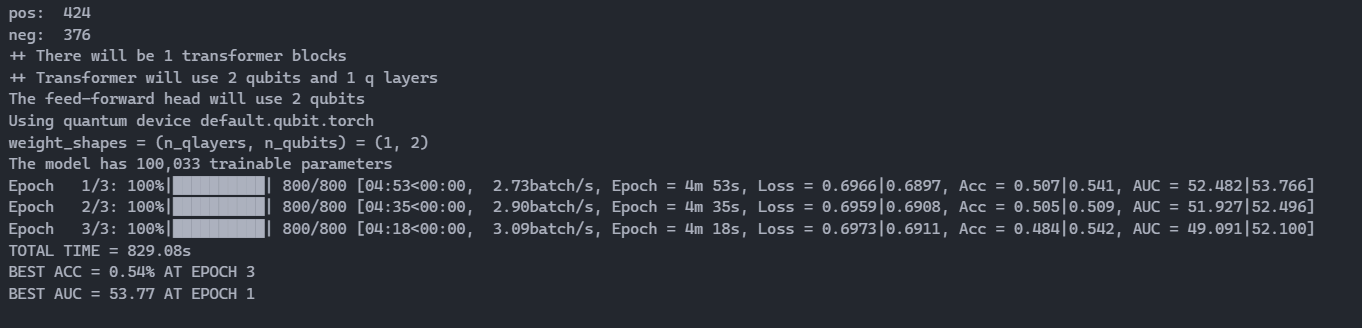


## Evaluation


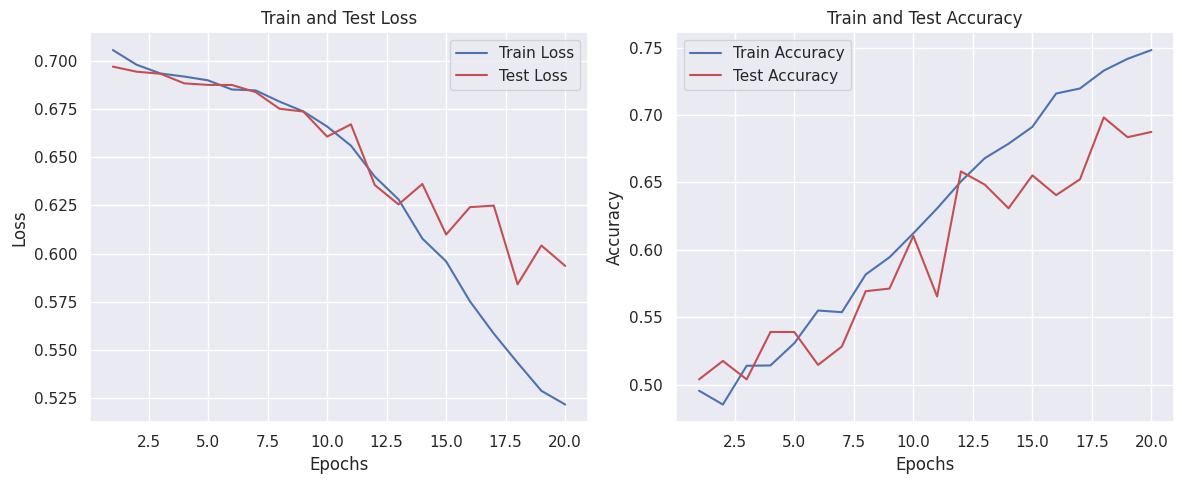

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# plt.style.use("classic")
# plt.style.use("dark_background")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, "b-", label="Train Loss")
plt.plot(epochs, test_loss, "r-", label="Test Loss")
plt.title("Train and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, "b-", label="Train Accuracy")
plt.plot(epochs, test_acc, "r-", label="Test Accuracy")
plt.title("Train and Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

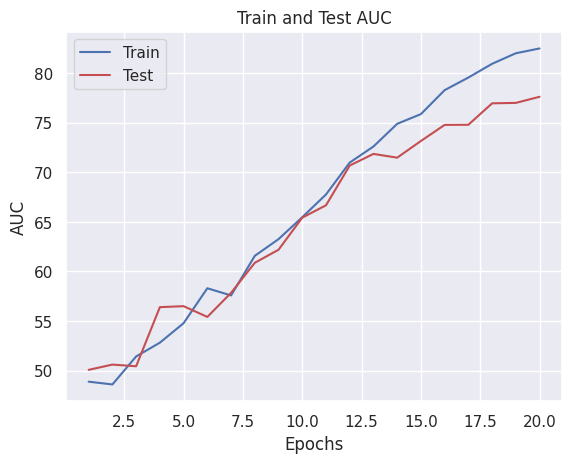

In [24]:
plt.plot(epochs, train_auc, "b-", label="Train")
plt.plot(epochs, test_auc, "r-", label="Test")
plt.title("Train and Test AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [25]:
# checkpoint = torch.load(
#     ".models/model_and_metrics_epoch_10.pt"
# )  # Replace x with the epoch number

# # Load the metrics
# epoch = checkpoint["epoch"]
# train_loss = checkpoint["train_loss"]
# train_acc = checkpoint["train_acc"]
# train_auc = checkpoint["train_auc"]
# test_loss = checkpoint["test_loss"]
# test_acc = checkpoint["test_acc"]
# test_auc = checkpoint["test_auc"]

# test_acc

In [26]:
# fig, ax = plt.subplots(figsize=(4, 3.5))
# # ax.plot(classical_qg_metrics['train_aucs'], label='Classical Training', color='orange', linestyle='--')
# # ax.plot(quantum_qg_metrics['train_aucs'], label='Quantum Training', color='purple', linestyle='--')
# # ax.plot(classical_qg_metrics['val_aucs'], label='Classical Validation', color='orange')
# # ax.plot(quantum_qg_metrics['val_aucs'], label='Quantum Validation', color='purple')
# ax.plot(auc, label="Quantum Validation", color="purple")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("AUC")
# ax.legend()
# ax.grid()
# ax.set_ylim(0.5, 1)